# **Stock Market Direction Prediction Using Tree-Based Classifiers**

**Authors**: Hanaa TALBI, Aymen EL GHOUL, Houssem MAJED

**Institution**: École d'Économie de la Sorbonne, Université Paris 1 Panthéon-Sorbonne
**Program**: Master 2 MOSEF (Modélisations Statistiques Économiques et Financières)
**Date**: Février 2026

# **ABSTRACT**

---
This study replicates and extends the methodology of Basak et al. (2019) for predicting stock market price direction using tree-based classifiers. We evaluate five machine learning models (Random Forest, XGBoost, Gradient Boosting, LightGBM, and CatBoost) on 25 stocks across five sectors. Starting from the original six technical indicators (RSI, Stochastic Oscillator, Williams %R, MACD, PROC, and OBV), we extend the feature set to **14 indicators** covering momentum, volatility, volume, and trend strength dimensions. We further augment this with **change features** ($\Delta$ = 1-day difference for each indicator), capturing indicator dynamics that tree-based models cannot infer from static snapshots. A rigorous feature selection pipeline (correlation filter + Boruta) is applied to the resulting 28 candidate features to retain the most informative subset.

A critical methodological contribution is the implementation of **Purged K-Fold Cross-Validation** (Lopez de Prado, 2018), which addresses data leakage inherent in financial time series with forward-looking labels. Our results demonstrate that standard cross-validation inflates accuracy estimates by 5–24 percentage points depending on the prediction window, highlighting the importance of proper validation methodology in financial machine learning.

We further improve the preprocessing pipeline by computing indicators on **raw data** (avoiding double-smoothing) and comparing multiple smoothing methods (exponential, wavelet denoising, Savitzky-Golay) for label creation. Hyperparameter optimization is performed using Optuna with Purged K-Fold as the objective function. Model interpretability is assessed through SHAP analysis and feature importance rankings.


# **1. DATA**

---

<a id='section1'></a>

## **1.1 Description**

### Key Components

- **Data**: Daily stock prices from Yahoo Finance (2020–2024)
- **Preprocessing**: Wavelet denoising for label creation (indicators computed on raw data)
- **Features**: 28 candidate features (14 technical indicators + 14 change features) → selected via correlation filter + Boruta
- **Models**: Random Forest, XGBoost, Gradient Boosting, LightGBM, CatBoost
- **Target**: Binary classification (+1 for price increase, -1 for decrease)
- **Validation**: Purged K-Fold Cross-Validation (Lopez de Prado, 2018)

### Sectors and Stocks

| Sector | Stocks |
|--------|--------|
| Technology | AAPL, MSFT, GOOGL, NVDA, META |
| Automotive | TSLA, F, GM, TM, HMC |
| Consumer & Retail | NKE, SBUX, MCD, DIS, NFLX |
| Financial Services | JPM, BAC, GS, MS, C |
| Healthcare & Pharma | JNJ, UNH, PFE, ABBV, TMO |

---

<a id='section2'></a>

## **1.2 Fetching the Data**

### **1.2.1 Import Libraries & Configuration**


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
from src.config import (CONFIG, STOCK_UNIVERSE, MODEL_NAMES, TREE_MODEL_NAMES,
    BASELINE_NAMES, ALL_MODEL_NAMES, MODEL_COLORS, MODEL_MARKERS,
    FEATURE_COLS, ORIGINAL_FEATURE_COLS, EXTENDED_FEATURE_COLS, get_all_tickers, get_ticker_to_sector_map)
from src.data import download_multiple_stocks, assess_data_quality
from src.indicators import (calculate_all_indicators, calculate_rsi, calculate_stochastic_oscillator,
    calculate_williams_r, calculate_macd, calculate_proc, calculate_obv,
    calculate_bollinger_bands, calculate_atr, calculate_adx, calculate_mfi, calculate_ad_line,
    calculate_cci, calculate_historical_volatility)
from src.preprocessing import (exponential_smoothing, wavelet_denoising, savgol_smoothing,
    apply_smoothing, compute_noise_reduction, create_target_labels,
    prepare_features, prepare_features_basak, prepare_features_with_t1, SMOOTHING_METHODS)
from src.validation import PurgedKFold, get_standard_kfold_splits, temporal_train_test_split
from src.models import (create_models, create_baseline_models, create_stacking_model,
    calculate_metrics, evaluate_with_standard_kfold, evaluate_with_purged_cv,
    evaluate_with_temporal_split)
from src.tuning import tune_model, tune_all_models, build_tuned_hyperparams
from src.analysis import (
    run_kfold_comparison, run_detailed_single_stock_analysis,
    run_single_stock_multiwindow_analysis, run_all_stocks_purged_cv,
    compute_sector_statistics, compute_window_statistics, compute_window_anova,
    run_portfolio_analysis, compute_individual_vs_portfolio_comparison,
    compute_model_anova, compute_tukey_hsd,
)
from src.visualization import (
    setup_style, plot_normalized_prices, plot_return_distributions,
    plot_correlation_heatmap, plot_indicator_with_price,
    plot_kfold_comparison, plot_feature_importance, plot_roc_curves,
    plot_confusion_matrices, plot_accuracy_vs_window,
    plot_sector_bar_chart, plot_sector_heatmap,
    plot_window_effect, plot_window_heatmap,
    plot_portfolio_evolution, plot_individual_vs_portfolio,
)

setup_style()
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.random.seed(42)

# Display configuration
print("Configuration")
print("=" * 60)
total_stocks = sum(len(s['stocks']) for s in STOCK_UNIVERSE.values())
print(f"Total stocks: {total_stocks} | Sectors: {len(STOCK_UNIVERSE)}")
print(f"Analysis Period: {CONFIG['start_date']} to {CONFIG['end_date']}")
print(f"Trading Windows: {CONFIG['windows']} days")
print(f"Models: {len(MODEL_NAMES)} tree-based + {len(BASELINE_NAMES)} baselines")
print(f"\nSector Breakdown:")
for sector, info in STOCK_UNIVERSE.items():
    print(f"  {sector}: {', '.join(info['stocks'])}")

Configuration
Total stocks: 25 | Sectors: 5
Analysis Period: 2020-01-01 to 2024-12-31
Trading Windows: [1, 2, 5, 10, 15] days
Models: 5 tree-based + 3 baselines

Sector Breakdown:
  Technology: AAPL, MSFT, GOOGL, NVDA, META
  Automotive: TSLA, F, GM, TM, HMC
  Consumer: NKE, SBUX, MCD, DIS, NFLX
  Financial: JPM, BAC, GS, MS, C
  Healthcare: JNJ, UNH, PFE, ABBV, TMO


Our investment universe covers **25 stocks across 5 sectors** over the period **January 2020 to December 2024** (5 years). This period is particularly interesting as it spans several major market events: the COVID-19 crash (March 2020), the subsequent recovery rally, the meme stock era (2021), rising interest rates (2022), and the AI boom (2023-2024).

The five trading windows [1, 2, 5, 10, 15 days] allow us to test whether models are better at **short-term** (1-2 days) or **medium-term** (10-15 days) predictions. Shorter windows capture daily noise, while longer windows reflect broader trends.

### **1.2.2 Download Data for All Stocks**

In [2]:
all_tickers = get_all_tickers()
stock_data = download_multiple_stocks(all_tickers)
print(f"\nData loaded for {len(stock_data)} stocks")

  Downloaded AAPL: 1257 days
  Downloaded MSFT: 1257 days
  Downloaded GOOGL: 1257 days
  Downloaded NVDA: 1257 days
  Downloaded META: 1257 days
  Downloaded TSLA: 1257 days
  Downloaded F: 1257 days
  Downloaded GM: 1257 days
  Downloaded TM: 1257 days
  Downloaded HMC: 1257 days
  Downloaded NKE: 1257 days
  Downloaded SBUX: 1257 days
  Downloaded MCD: 1257 days
  Downloaded DIS: 1257 days
  Downloaded NFLX: 1257 days
  Downloaded JPM: 1257 days
  Downloaded BAC: 1257 days
  Downloaded GS: 1257 days
  Downloaded MS: 1257 days
  Downloaded C: 1257 days
  Downloaded JNJ: 1257 days
  Downloaded UNH: 1257 days
  Downloaded PFE: 1257 days
  Downloaded ABBV: 1257 days
  Downloaded TMO: 1257 days
Successfully downloaded: 25/25 stocks

Data loaded for 25 stocks


All **25 stocks** were successfully downloaded with **1,257 trading days** each. This is consistent with expectations: US markets are open approximately 252 days per year × 5 years = 1,260 days (the 567 missing calendar days are weekends and public holidays like Thanksgiving, Christmas, etc.).

The uniform data length across all tickers confirms that all selected stocks were actively traded throughout the entire analysis period, with no delistings, IPOs, or data gaps to handle.

---

<a id='section3'></a>

## **1.3 INPUT**

### **1.3.1 Data Visualization and Preprocessing**

Before applying the prediction methodology, we conduct thorough data visualization and preprocessing to understand the characteristics of our data.

#### **1.3.1.1 Data Quality Assessment**

In [3]:
quality_summary = assess_data_quality(stock_data)

print("Data Quality Summary")
print("=" * 80)
print(quality_summary.to_string(index=False))
print(f"\nAverage days of data: {quality_summary['Days'].mean():.0f}")
print(f"Average daily return: {quality_summary['Avg Return (%)'].mean():.4f}%")
print(f"Average volatility: {quality_summary['Return Std (%)'].mean():.4f}%")

Data Quality Summary
Ticker  Days  Date Range (days)  Missing (%)  Avg Price  Price Std  Avg Return (%)  Return Std (%)  Extreme Moves (>10%)
  AAPL  1257               1824          0.0   154.0322    41.4483          0.1164          1.9964                     4
  MSFT  1257               1824          0.0   294.2369    80.1186          0.0960          1.9223                     2
 GOOGL  1257               1824          0.0   119.0197    32.4056          0.1028          2.0479                     2
  NVDA  1257               1824          0.0    38.3952    38.1480          0.3067          3.3946                    13
  META  1257               1824          0.0   301.1971   124.8117          0.1231          2.8294                    10
  TSLA  1257               1824          0.0   213.2794    83.3215          0.3026          4.2325                    44
     F  1257               1824          0.0    12.0152     3.4886          0.0433          2.8100                     8
    GM  125

The data quality assessment reveals several important findings:

**Data Completeness**: All 25 stocks have **0% missing values**, no imputation or interpolation is needed, ensuring no artificial patterns are introduced.

**Volatility Spectrum**: The stocks exhibit vastly different risk profiles:
- **Most volatile**: TSLA (Return Std = 4.23%, **44 extreme moves >10%**). Tesla is known for speculative, sentiment-driven price swings. This is by far the most "nervous" stock in our universe.
- **High volatility**: NVDA (3.39%), META (2.83%), NFLX (2.87%), growth/tech stocks with strong momentum.
- **Most stable**: JNJ (1.24%, **0 extreme moves**), TM (1.63%, 0 extreme moves), these are defensive, "boring" stocks that investors hold for safety.

**Return Performance**:
- **Best performers**: NVDA (+0.31%/day) and TSLA (+0.30%/day), NVIDIA benefited from the AI revolution (2023-2024); Tesla from the EV hype (2020-2021).
- **Negative performers**: NKE (-0.0008%/day), DIS (-0.0003%/day), PFE (-0.012%/day), Nike struggled with post-COVID inventory issues, Disney with streaming losses, and Pfizer declined sharply after the vaccine demand peak.

**Implication for modeling**: The wide range of volatility and behavior across stocks will test whether our models generalize well or perform differently depending on stock characteristics.

#### **1.3.1.2 Price Evolution Visualization**

Visualize normalized price evolution for representative stocks from each sector.

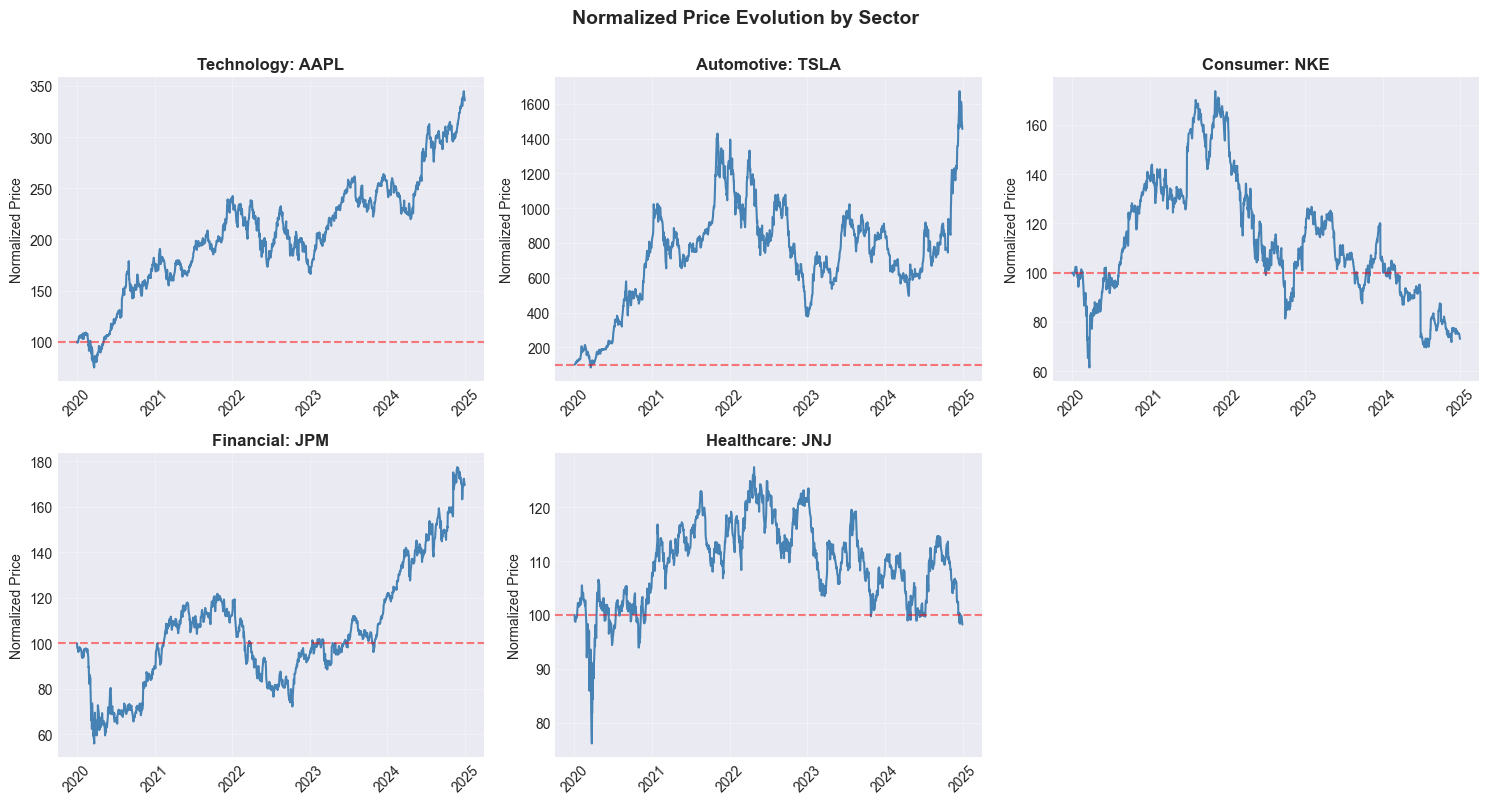

In [4]:
representative_stocks = {
    'Technology': 'AAPL', 'Automotive': 'TSLA', 'Consumer': 'NKE',
    'Financial': 'JPM', 'Healthcare': 'JNJ'
}
plot_normalized_prices(stock_data, representative_stocks)

#### **Interpretation — Normalized Price Evolution**

By normalizing all prices to a common base of 100, we can fairly compare stocks with very different absolute prices. The five sector representatives reveal strikingly different trajectories over 2020–2024:

- **TSLA (Automotive)**: By far the most dramatic trajectory, with a peak near **1,600** in late 2021 driven by EV enthusiasm and speculative momentum, followed by a severe correction in 2022 (losing ~70% from peak), and a sharp rebound in late 2024. This extreme amplitude confirms Tesla's nature as a high-beta, sentiment-driven asset.
- **AAPL (Technology)**: Steady, structural growth from 100 to **~340** by end of period (+240%). The trajectory is much smoother than TSLA, reflecting Apple's consistent earnings and its status as a market bellwether.
- **NKE (Consumer)**: The **only stock ending below its starting value** (~70, i.e. -30%). After a strong rally to ~170 in late 2021, Nike entered a prolonged decline, underperforming the broader market — likely reflecting post-COVID consumer spending normalization and China headwinds.
- **JPM (Financial)**: Robust growth to **~180** (+80%), with a notable V-shaped recovery from the COVID crash in March 2020 (dipping to ~60). The financial sector benefited from rising interest rates in 2022–2024.
- **JNJ (Healthcare)**: The flattest trajectory, oscillating between **80 and 130** over the entire period. This is the classic defensive profile — low volatility, modest returns, low correlation with market cycles.

The **COVID-19 crash** (March 2020) is clearly visible across all five stocks as a sharp V-shaped dip, with recovery speed varying by sector: Technology and Automotive recovered fastest, while Financials took longer.

**Implication for our study**: This diversity of price behaviors (trending, mean-reverting, volatile, stable) provides a rich testbed for evaluating whether tree-based classifiers can adapt to different market dynamics.

#### **1.3.1.3 Return Distribution Analysis**

Analyze the distribution of daily returns to understand volatility patterns and market behavior.

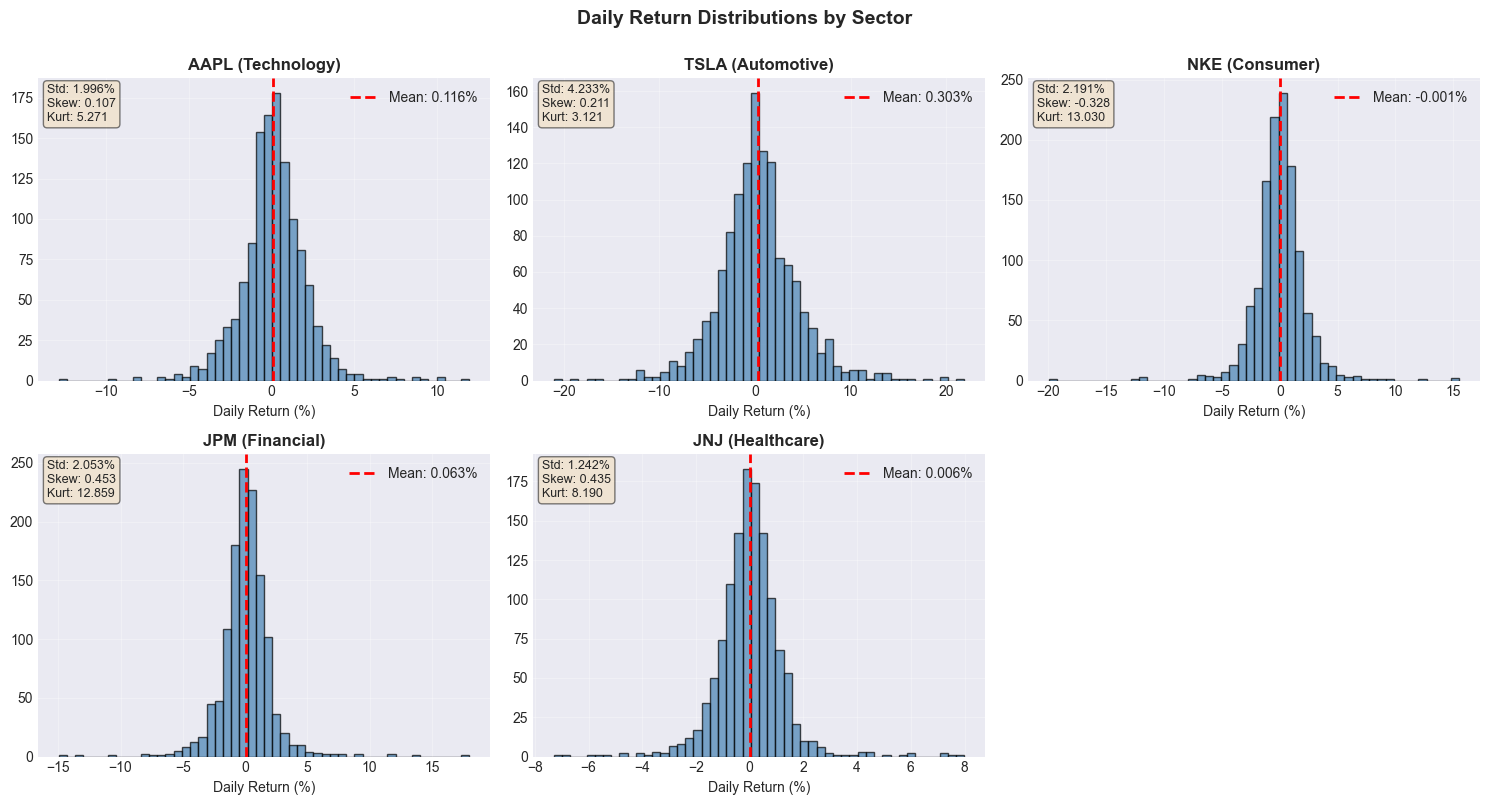

In [5]:
plot_return_distributions(stock_data, representative_stocks)

#### **Interpretation — Return Distributions**

The daily return distributions reveal fundamental statistical properties of our stock universe:

**Shape and fat tails**: All five distributions are approximately bell-shaped but exhibit significant **leptokurtosis** (fat tails) — extreme daily moves occur far more frequently than a Gaussian distribution would predict. The highest kurtosis values are observed for **NKE (13.03)** and **JPM (12.86)**, indicating particularly heavy tails with occasional extreme daily moves. Even the "calmest" stock (TSLA, kurtosis = 3.12) exceeds the Gaussian reference of 3.

**Volatility spectrum**:
- **TSLA** (Std = 4.23%): The widest distribution, with daily moves frequently exceeding ±10%. This reflects Tesla's speculative, news-driven nature.
- **NKE** (Std = 2.19%) and **JPM** (Std = 2.05%): Moderate volatility, but with extremely fat tails (high kurtosis).
- **AAPL** (Std = 2.00%): Moderate and relatively well-behaved for a mega-cap tech stock.
- **JNJ** (Std = 1.24%): The narrowest distribution, consistent with its defensive healthcare profile — daily moves rarely exceed ±4%.

**Asymmetry (skewness)**:
- Most stocks show **slight positive skewness** (AAPL: 0.107, TSLA: 0.211, JPM: 0.453, JNJ: 0.435), reflecting the bullish bias of 2020–2024.
- **NKE is the exception with negative skewness (-0.328)**, meaning extreme negative returns are more frequent than extreme positive ones — consistent with its overall declining trajectory during this period.

**Mean daily returns**: TSLA has the highest mean return (0.303%/day ≈ 76%/year annualized), while NKE is the only stock with a **negative mean** (-0.001%), confirming its underperformance.

**Implications for modeling**: The fat tails and non-Gaussian nature of returns mean that our models must handle extreme events. The class imbalance in our labels (more UP than DOWN days for most stocks) directly reflects the positive mean returns observed here.

#### **1.3.1.4 Correlation Analysis Between Sectors**

Examine how different sectors move together, which is important for portfolio diversification.

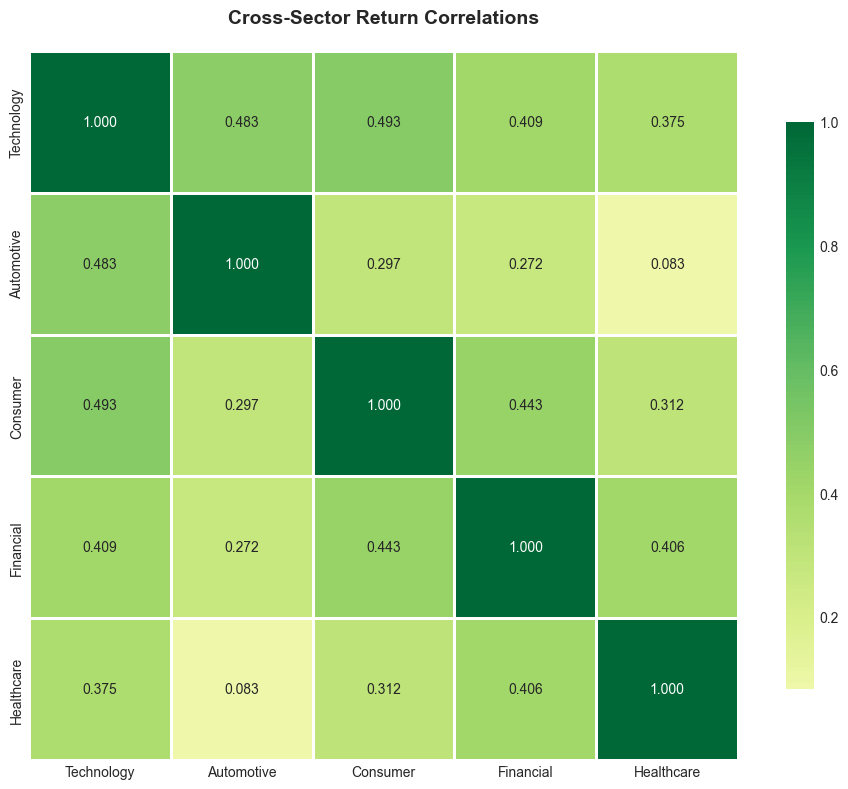

In [6]:
returns_df = pd.DataFrame({
    sector: stock_data[ticker]['Close'].pct_change()
    for sector, ticker in representative_stocks.items()
    if ticker in stock_data
})
plot_correlation_heatmap(returns_df.corr(), title='Cross-Sector Return Correlations')

#### **Interpretation — Sector Correlation**

The cross-sector return correlation heatmap reveals an important structure for portfolio diversification and prediction modeling:

**All correlations are positive but moderate** (all below 0.50), indicating that while sectors share some common market exposure, they retain significant independent behavior:

- **Technology–Consumer (0.493)**: The strongest pairwise correlation. Both sectors are sensitive to consumer spending and growth expectations, explaining their co-movement.
- **Technology–Automotive (0.483)**: Moderately correlated, partly driven by Tesla's tech-like trading behavior and shared sensitivity to innovation narratives.
- **Consumer–Financial (0.443)**: Both are cyclical sectors tied to economic activity and consumer confidence.
- **Financial–Healthcare (0.406)**: Moderate correlation, both sectors are influenced by macroeconomic policy but through different channels.
- **Automotive–Healthcare (0.083)**: Near-zero correlation — these two sectors are **effectively independent**. Tesla's speculative, momentum-driven behavior has virtually no relationship with Johnson & Johnson's steady, fundamentals-driven price action.

**Key pattern**: Healthcare (JNJ) is the **least correlated sector** with all others (range: 0.083–0.406), confirming its defensive, counter-cyclical nature. Automotive (TSLA) is also relatively independent due to its idiosyncratic, sentiment-driven volatility.

**Implications for our study**: 
- Low inter-sector correlations justify analyzing each sector independently — performance patterns learned on one sector may not transfer to another.
- The lack of strong correlations (>0.7) suggests genuine diversification benefits, meaning portfolio-level predictions may behave differently from individual stock predictions.

### **1.3.2 Technical Indicators: Theory and Implementation**

Technical indicators are mathematical calculations based on historical price and volume data. Traders use these indicators to identify patterns, trends, and potential reversal points.

We use **14 technical indicators** organized into four categories:
- **Momentum** (6): RSI, Stochastic Oscillator, Williams %R, MACD, PROC — originally from Basak et al. (2019)
- **Volume** (3): OBV (original), MFI, Accumulation/Distribution Line
- **Volatility** (4): Bollinger Bands (Width, %B), ATR, Historical Volatility
- **Trend & Cyclical** (2): ADX, CCI

This section first covers the **6 original indicators** from Basak et al. (2019), then introduces the **8 extended indicators** that improve category diversity and reduce redundancy.

#### **1.3.2.1 Relative Strength Index (RSI)**

#### **Theory**

**Historical Context**: Developed by J. Welles Wilder Jr. in 1978, the RSI is one of the most widely used momentum oscillators in technical analysis.

**Purpose**: The RSI measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock.

**Mathematical Formula**:

$$RSI = 100 - \frac{100}{1 + RS}$$

where $RS$ (Relative Strength) is:

$$RS = \frac{\text{Average Gain over n periods}}{\text{Average Loss over n periods}}$$

**Interpretation**:
- RSI ranges from 0 to 100
- RSI > 70: Overbought condition (potential sell signal)
- RSI < 30: Oversold condition (potential buy signal)
- RSI = 50: Neutral (no clear trend)

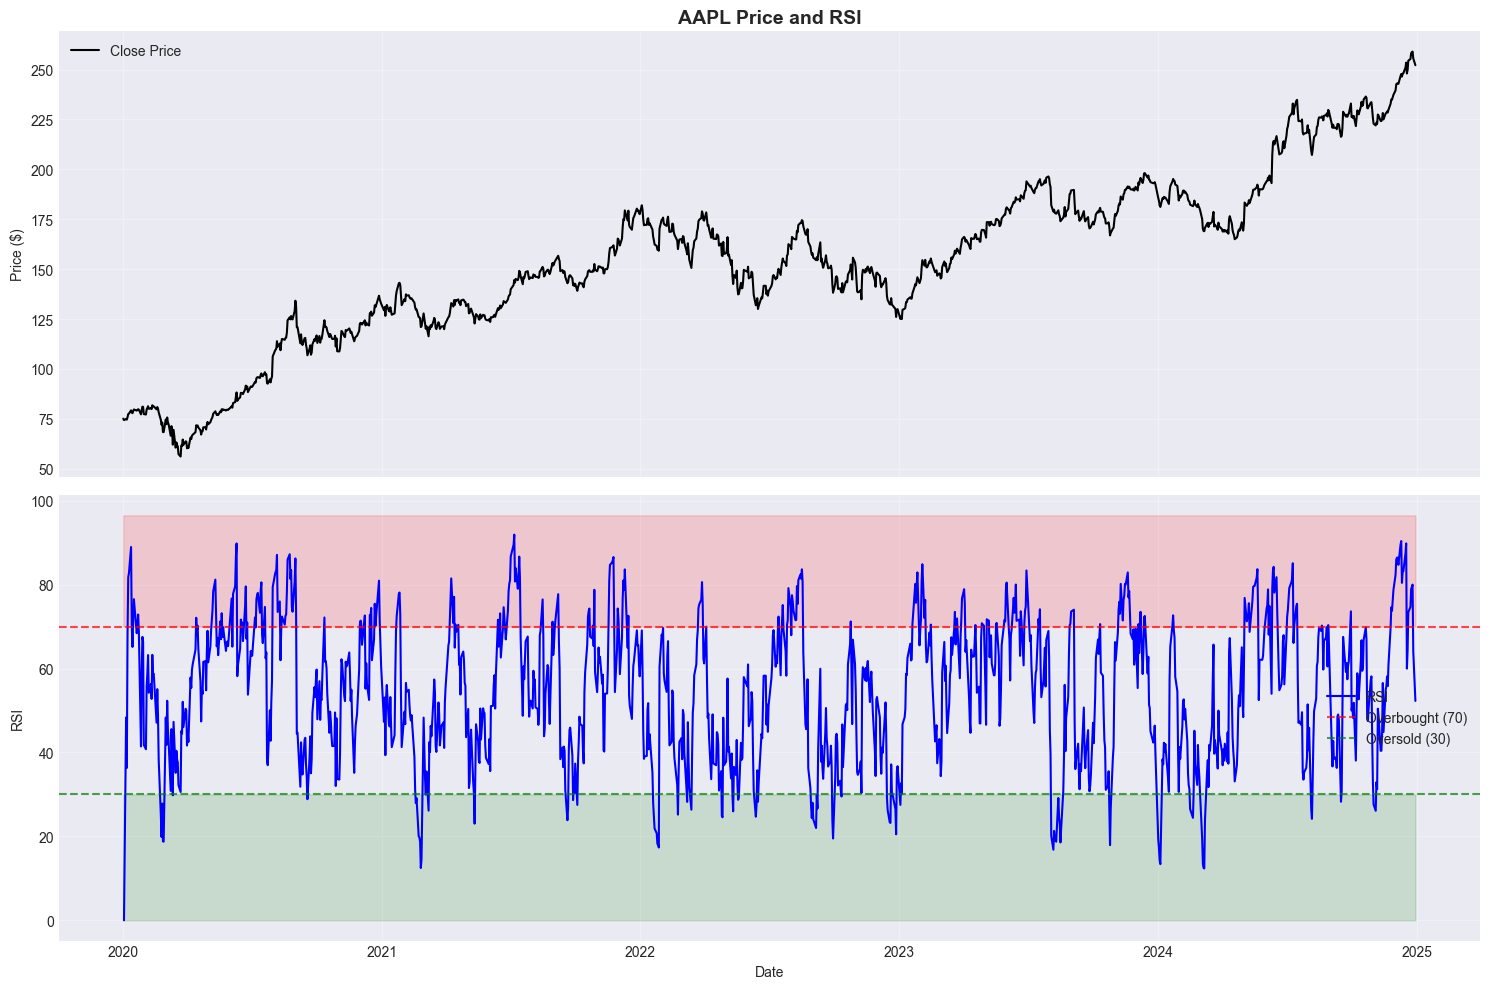

In [7]:
test_ticker = 'AAPL'
test_data = stock_data[test_ticker].copy()
test_data['RSI'] = calculate_rsi(test_data['Close'])

plot_indicator_with_price(
    test_data.index, test_data['Close'], test_data['RSI'],
    'RSI', overbought=70, oversold=30, ticker=test_ticker
)

#### **Interpretation — RSI (Relative Strength Index)**

The RSI plot for AAPL oscillates between 0 and ~95 over the 2020–2024 period, with clear correspondence to price dynamics:

- **Overbought signals (RSI > 70)**: Multiple episodes during strong bullish phases — notably in mid-2020 (post-COVID recovery rally), throughout 2021 (tech bull run), mid-2023, and late 2024 (reaching ~90). These readings indicate aggressive buying pressure and often precede short-term pullbacks.
- **Oversold signals (RSI < 30)**: Clearly visible during the **COVID crash** (March 2020, RSI plunging near 0), the 2022 bear market correction, and early 2023. These correspond to periods of intense selling pressure where the stock dropped sharply.
- **Bullish bias**: The RSI spends noticeably more time above 50 than below, consistent with AAPL’s overall upward trajectory (+240% over the period). This asymmetry is typical of stocks in a structural uptrend.

The RSI captures **short-term momentum reversals** — it signals when price moves may be overextended. However, its high frequency of overbought/oversold readings (many false signals during strong trends) explains why it works best in combination with other indicators rather than alone.

#### **1.3.2.2 Stochastic Oscillator (SO)**

#### **Theory**

**Historical Context**: Developed by George Lane in the 1950s, the Stochastic Oscillator is based on the observation that in an uptrend, prices tend to close near their high, and in a downtrend, prices tend to close near their low.

**Mathematical Formula**:

$$\%K = \frac{C - L_{n}}{H_{n} - L_{n}} \times 100$$

**Interpretation**:
- SO > 80: Overbought
- SO < 20: Oversold

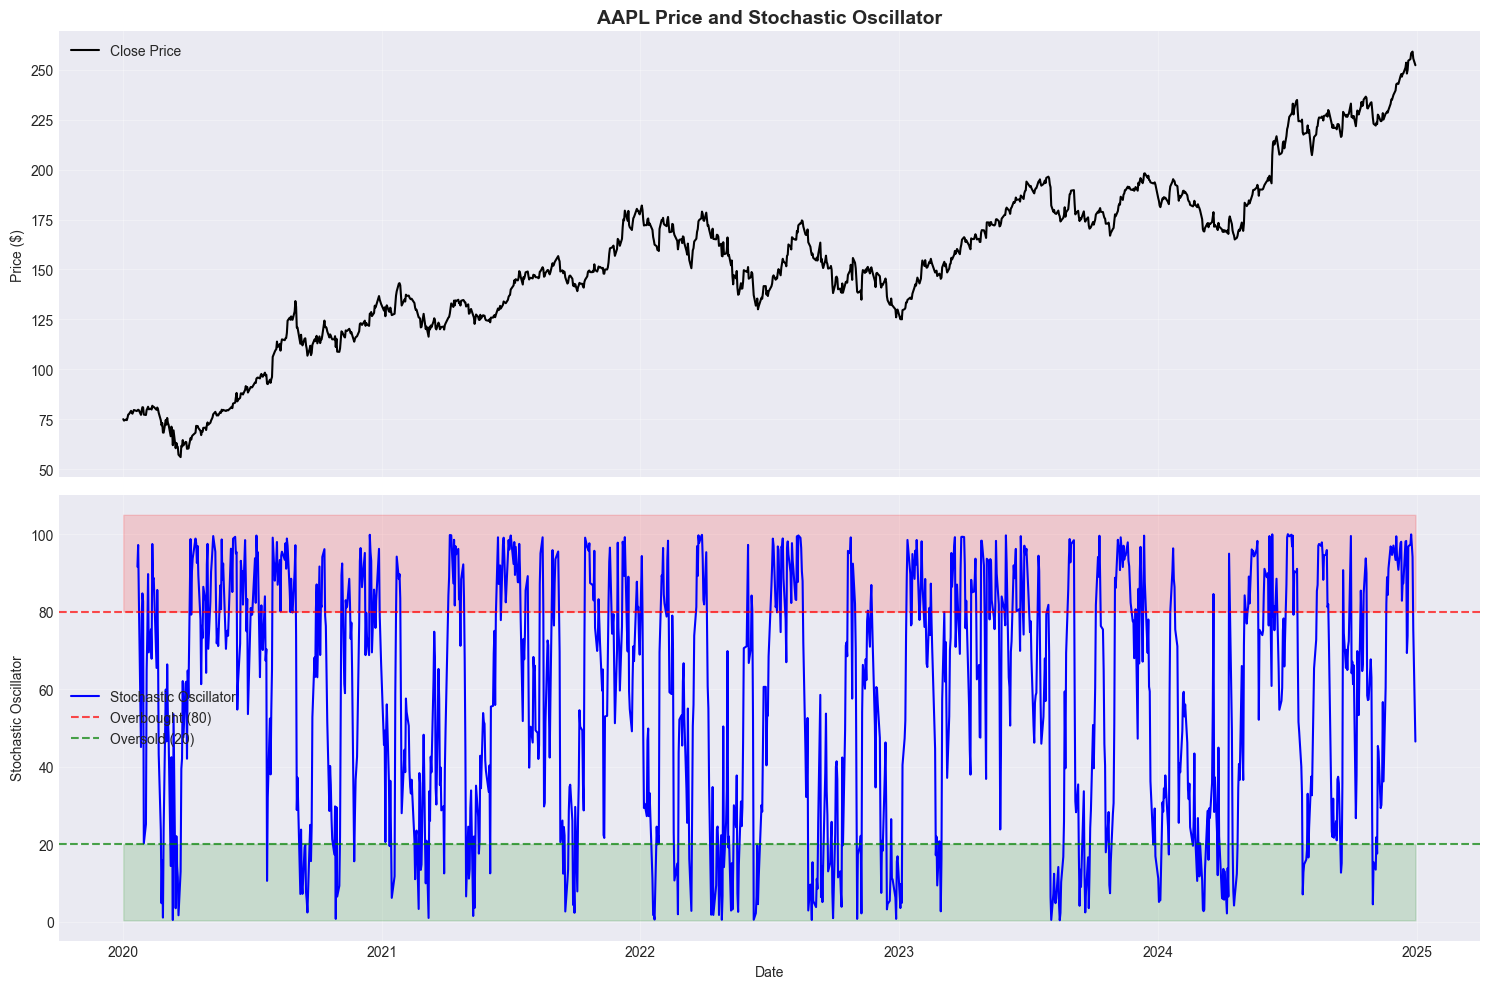

In [8]:
test_data['SO'] = calculate_stochastic_oscillator(test_data['High'], test_data['Low'], test_data['Close'])

plot_indicator_with_price(
    test_data.index, test_data['Close'], test_data['SO'],
    'Stochastic Oscillator', overbought=80, oversold=20, ticker=test_ticker
)

#### **Interpretation — Stochastic Oscillator (SO)**

The Stochastic Oscillator for AAPL exhibits a notably more **reactive, binary behavior** compared to the RSI:

- The SO frequently hits extreme values (0 and 100), bouncing sharply between the overbought (>80) and oversold (<20) zones. This "all-or-nothing" pattern indicates that AAPL's closing price regularly sits at either the top or the bottom of its 14-day range.
- **Comparison with RSI**: While both measure momentum, the SO is visibly more volatile and noisy. The RSI’s exponential moving average smoothing produces a more gradual oscillation, whereas the SO reacts instantaneously to where the close sits within the high-low range.
- **Overbought readings (>80)** are frequent during uptrends (2021, late 2024), often clustering in sustained series — reflecting persistent bullish momentum.
- **Oversold readings (<20)** cluster during corrections (COVID crash, 2022 selloff, late 2022/early 2023).

The SO’s high reactivity makes it useful for **timing short-term entries and exits**, but also produces many false signals during trending markets. This characteristic will be reflected in the correlation analysis, where SO shows >0.9 correlation with Williams %R (its mathematical inverse).

#### **1.3.2.3 Williams %R**

#### Theory

**Historical Context**: Developed by Larry Williams in 1973, Williams %R is essentially an inverted version of the Stochastic Oscillator.

**Mathematical Formula**:

$$\%R = \frac{H_{n} - C}{H_{n} - L_{n}} \times (-100)$$

**Interpretation**:
- %R > -20: Overbought (sell signal)
- %R < -80: Oversold (buy signal)

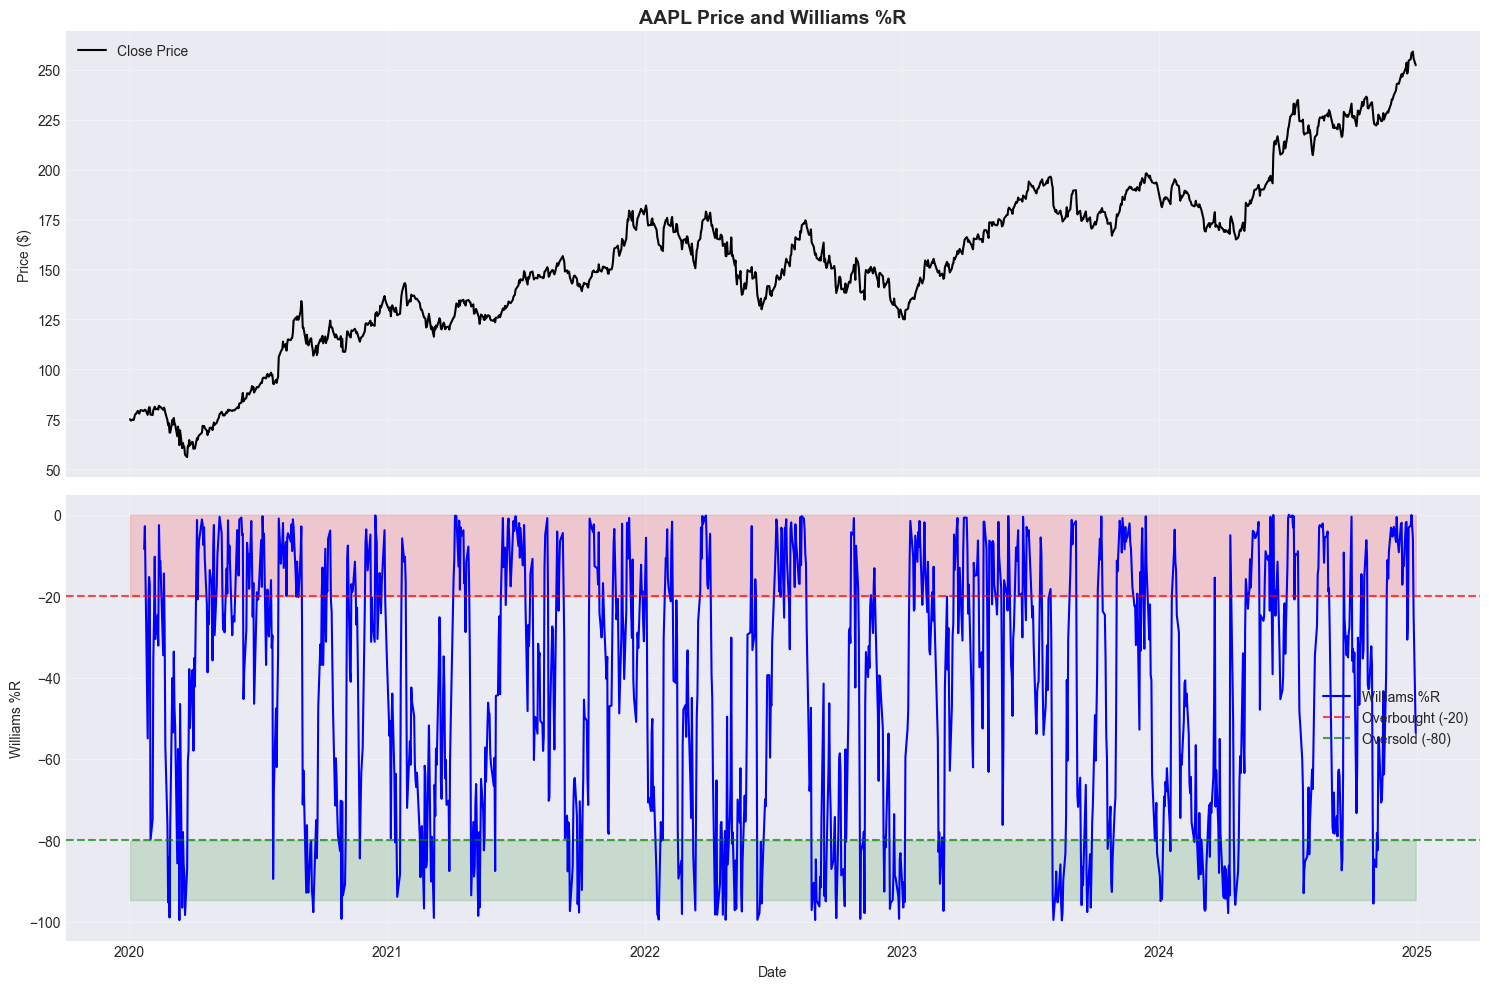

In [9]:
test_data['WR'] = calculate_williams_r(test_data['High'], test_data['Low'], test_data['Close'])

plot_indicator_with_price(
    test_data.index, test_data['Close'], test_data['WR'],
    'Williams %R', overbought=-20, oversold=-80, ticker=test_ticker
)

#### **Interpretation — Williams %R**

The Williams %R chart for AAPL confirms its mathematical relationship with the Stochastic Oscillator: **%R = -(100 - SO)**. The visual pattern is an exact **mirror image** of the SO plot above.

- **Near 0 (overbought)**: The price is at the top of its 14-day range — visible during the same bullish phases identified in the SO analysis.
- **Near -100 (oversold)**: The price is at the bottom of its range — visible during COVID crash and 2022 corrections.
- The indicator oscillates rapidly between extremes, with the same reactive, binary behavior as the SO.

**Key observation for feature selection**: Because WR is a deterministic transformation of SO (identical information content), including both in a model introduces **perfect redundancy**. This is a well-known issue with the Basak et al. (2019) feature set, where RSI, SO, and WR are all highly correlated momentum oscillators. Our correlation filter (Section 1.6) will address this by removing one of the redundant pair.

#### **1.3.2.4 Moving Average Convergence Divergence (MACD)**

#### Theory

**Historical Context**: Developed by Gerald Appel in the late 1970s, MACD is one of the most popular and reliable trend-following indicators.

**Mathematical Formula**:

$$\text{MACD Line} = EMA_{12} - EMA_{26}$$

$$\text{Signal Line} = EMA_{9}(\text{MACD Line})$$

$$\text{MACD Histogram} = \text{MACD Line} - \text{Signal Line}$$

**Interpretation**:
- MACD > 0: Bullish signal
- MACD crossing above signal line: Buy signal
- MACD crossing below signal line: Sell signal

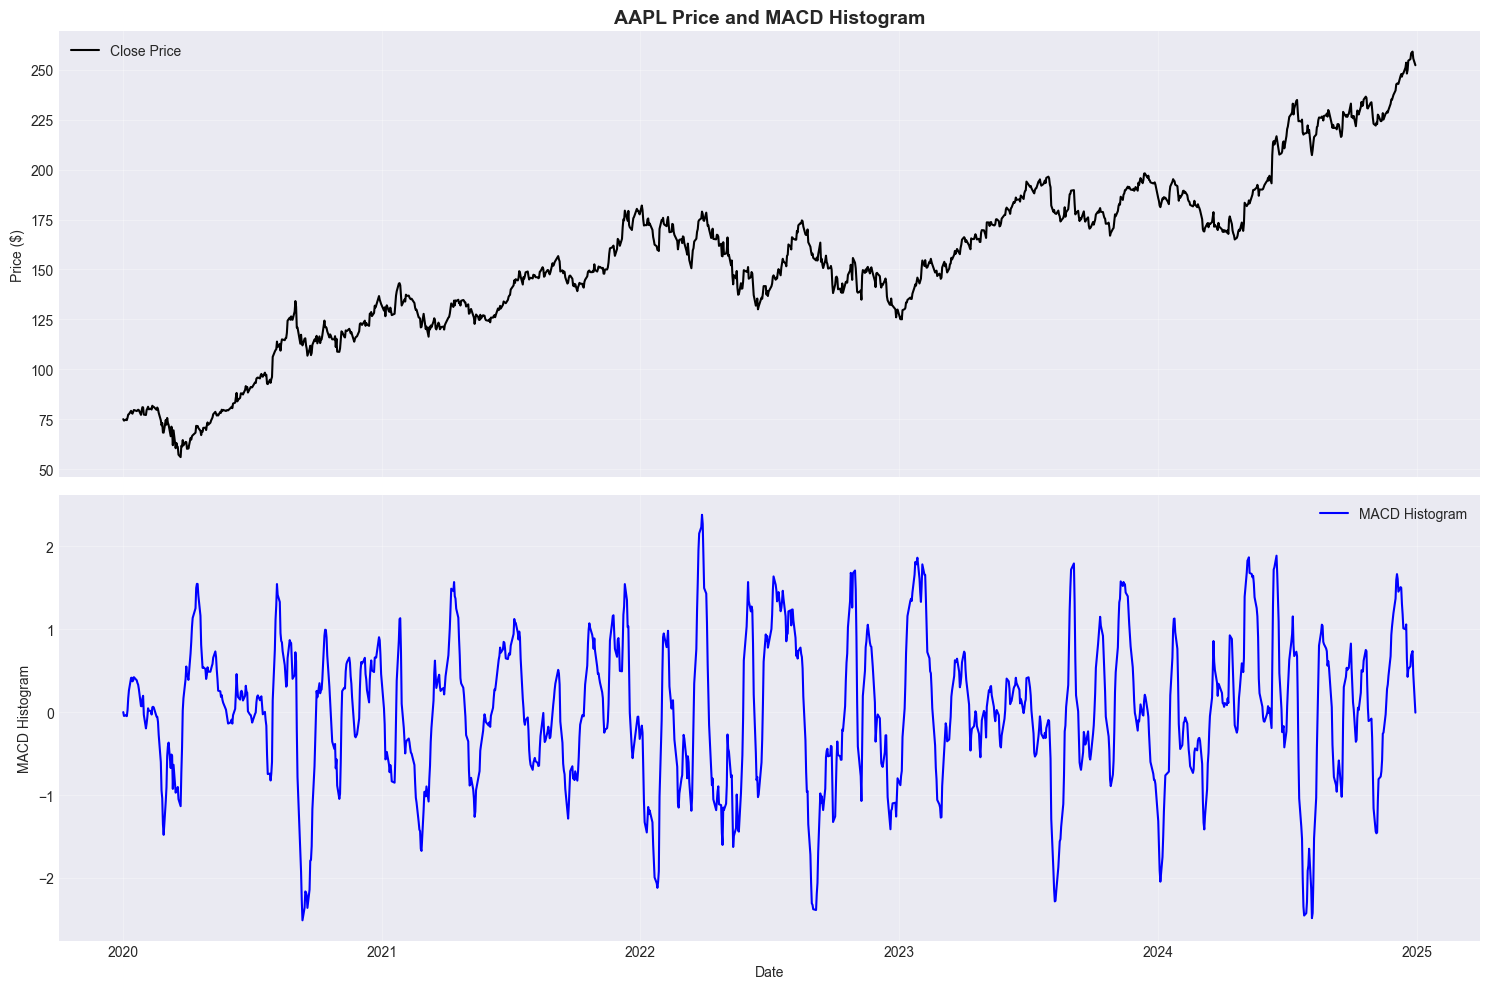

In [10]:
test_data['MACD'] = calculate_macd(test_data['Close'])

plot_indicator_with_price(
    test_data.index, test_data['Close'], test_data['MACD'],
    'MACD Histogram', ticker=test_ticker
)

#### **Interpretation — MACD**

The MACD histogram for AAPL oscillates between approximately **-2.5 and +2.5**, capturing trend direction and strength:

- **Strong negative spike (~-2.5) in March 2020**: Corresponds to the COVID crash — the short-term EMA (12-day) fell sharply below the long-term EMA (26-day), signaling intense bearish momentum.
- **Positive values during 2021 and 2024**: Reflecting sustained uptrends where short-term momentum exceeded long-term momentum. The late 2024 rally shows MACD reaching ~+2, confirming the strong bullish breakout.
- **Zero-line crossovers**: Each crossing from negative to positive (or vice versa) corresponds to a visible change in price trend direction. These crossovers are clearly aligned with inflection points in the price chart.

**Key difference from RSI/SO/WR**: MACD is **unbounded** — its magnitude depends on the absolute price level. As AAPL’s price increased from ~$75 to ~$250, the amplitude of MACD swings also increased slightly. This scale-dependence means MACD captures trend information in absolute terms, complementing the normalized, bounded oscillators.

MACD provides **trend-following** signals (momentum persistence) rather than **mean-reversion** signals (overbought/oversold), making it a fundamentally different feature from the three momentum oscillators above.

#### **1.3.2.5 Price Rate of Change (PROC)**

#### Theory

$$PROC = \frac{Price_t - Price_{t-n}}{Price_{t-n}} \times 100$$

**Interpretation**:
- PROC > 0: Price is higher than n periods ago (bullish)
- PROC < 0: Price is lower than n periods ago (bearish)

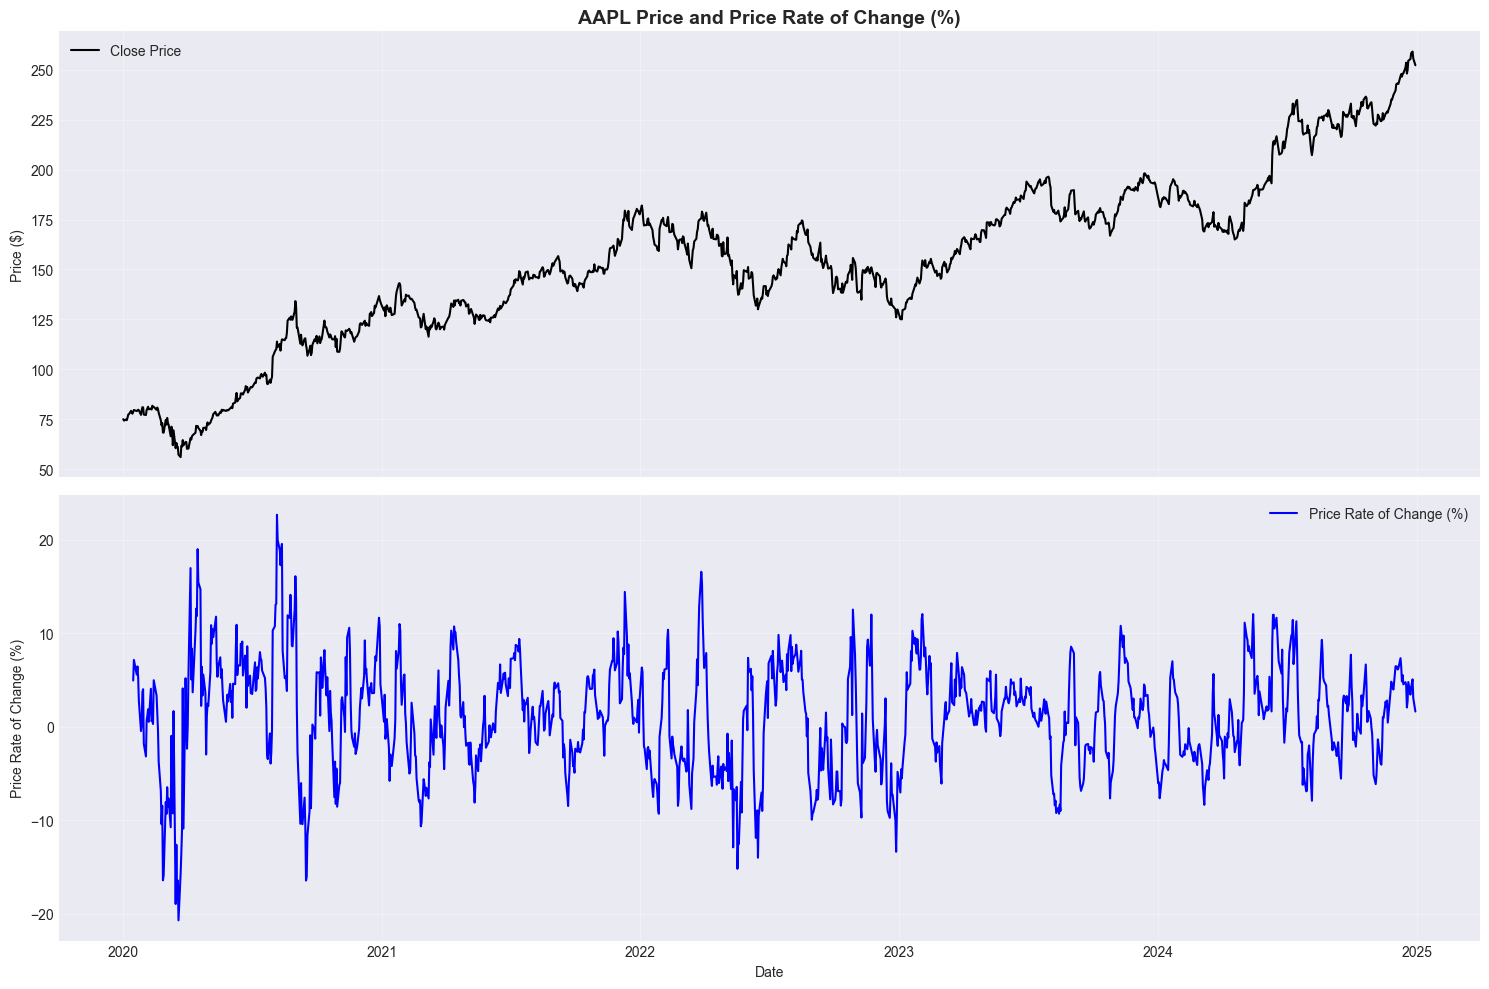

In [11]:
test_data['PROC'] = calculate_proc(test_data['Close'])

plot_indicator_with_price(
    test_data.index, test_data['Close'], test_data['PROC'],
    'Price Rate of Change (%)', ticker=test_ticker
)

#### **Interpretation — PROC (Price Rate of Change)**

The PROC indicator for AAPL shows the percentage price change over 10 trading days, with a range of approximately **-20% to +23%**:

- **Extreme negative spike (~-20%) in March 2020**: The COVID crash caused AAPL to lose 20% of its value in just 10 trading days — the most extreme reading in the entire period.
- **Extreme positive spike (~+23%) in mid-2020**: The post-COVID recovery rally, where AAPL rebounded sharply from its lows.
- **Post-2022 compression**: The amplitude of PROC oscillations decreases in 2023–2024 (mostly ±5-10%), reflecting a more stable, less volatile market environment for AAPL.
- **Positive bias**: PROC spends slightly more time in positive territory, consistent with the overall upward trend.

PROC is the most **directly interpretable** indicator — it answers "how much did the stock move in the last 2 weeks?" in percentage terms. Unlike the bounded oscillators (RSI, SO, WR), PROC has no fixed range, and its spikes directly correspond to identifiable market events (earnings surprises, macro shocks, sector rotations).

#### **1.3.2.6 On Balance Volume (OBV)**

#### Theory

**Historical Context**: Developed by Joseph Granville in the 1960s, OBV is a momentum indicator that uses volume flow to predict changes in stock price.

$$OBV_t = OBV_{t-1} + \begin{cases}
+Volume_t & \text{if } Close_t > Close_{t-1} \\
-Volume_t & \text{if } Close_t < Close_{t-1} \\
0 & \text{if } Close_t = Close_{t-1}
\end{cases}$$

**Interpretation**:
- Rising OBV: Buying pressure (bullish)
- Falling OBV: Selling pressure (bearish)
- OBV divergence from price: Potential reversal signal

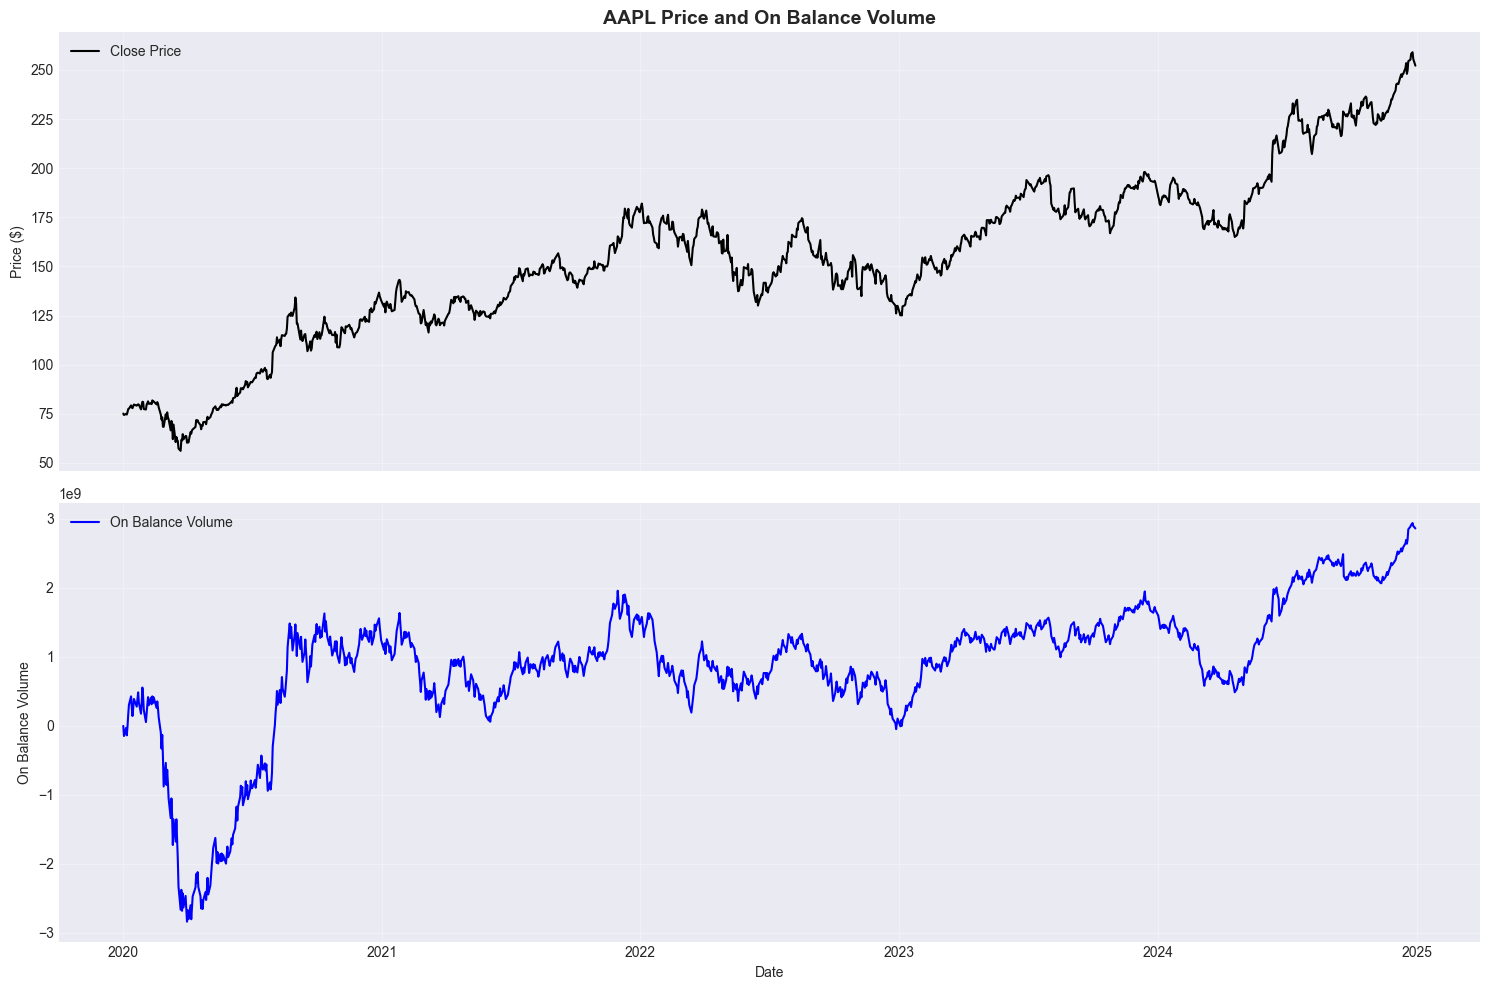

In [12]:
test_data['OBV'] = calculate_obv(test_data['Close'], test_data['Volume'])

plot_indicator_with_price(
    test_data.index, test_data['Close'], test_data['OBV'],
    'On Balance Volume', ticker=test_ticker
)

#### **Interpretation — OBV (On Balance Volume)**

The OBV plot for AAPL reveals the cumulative buying and selling pressure over 2020–2024, scaled in billions of shares:

- **Sharp drop to ~-2.7 billion in early 2020**: During the COVID crash, massive selling volume drove OBV deep into negative territory — indicating sustained distribution (net selling pressure) during the panic.
- **Recovery from mid-2020**: OBV climbed steadily through 2020–2021, reaching ~1.5 billion, as buying volume dominated during the post-COVID rally. This accumulation phase confirmed the price recovery with volume conviction.
- **Fluctuations in 2022–2023**: OBV oscillated between 0 and 1.5 billion, reflecting alternating phases of accumulation and distribution during the uncertain market environment.
- **Strong breakout in late 2024**: OBV surged to ~3 billion, reaching its highest level of the period. This coincides with AAPL’s price breakout above $225, and the rising OBV **confirms** the rally is backed by strong volume — a bullish signal.

**OBV vs price alignment**: Overall, OBV broadly tracks the price trajectory (both trending upward), indicating that AAPL’s price appreciation is supported by genuine buying pressure rather than low-volume drift. The absence of significant price-OBV divergences during the period suggests consistent market conviction.

**Unique value**: OBV is the only indicator in the original Basak et al. feature set that incorporates **volume information**. This makes it fundamentally complementary to the five price-only indicators (RSI, SO, WR, MACD, PROC).

### **1.3.3 Extended Technical Indicators**

The original Basak et al. (2019) study used only **6 indicators**, all heavily concentrated in the **momentum** category (RSI, SO, WR are correlated at >0.9). To improve our feature space, we add **8 new indicators** covering dimensions that were entirely missing:

| Category | Original (Basak) | Extended (Ours) |
|----------|-------------------|-----------------|
| **Momentum** | RSI, SO, WR, MACD, PROC | *(kept as-is)* |
| **Volatility** | — | Bollinger Bands (Width + %B), ATR, Historical Volatility |
| **Trend Strength** | — | ADX (Average Directional Index) |
| **Volume-Weighted** | OBV only | MFI (Money Flow Index), A/D Line |
| **Cyclical** | — | CCI (Commodity Channel Index) |

This expands our feature set from 6 to **14 indicators**, providing a more complete picture of market dynamics.

#### **1.3.3.1 Bollinger Bands** (Bollinger, 1980s)

#### Theory

Bollinger Bands consist of a middle band (SMA) and two outer bands at ±k standard deviations:

$$Upper = SMA_{n} + k \times \sigma_n, \quad Lower = SMA_{n} - k \times \sigma_n$$

We extract two features:
- **BB Width** = $(Upper - Lower) / SMA$ — measures **volatility expansion/contraction**. A "squeeze" (narrow bands) often precedes a large price move.
- **%B** = $(Price - Lower) / (Upper - Lower)$ — measures **price position** within the bands (0 = at lower band, 1 = at upper band).

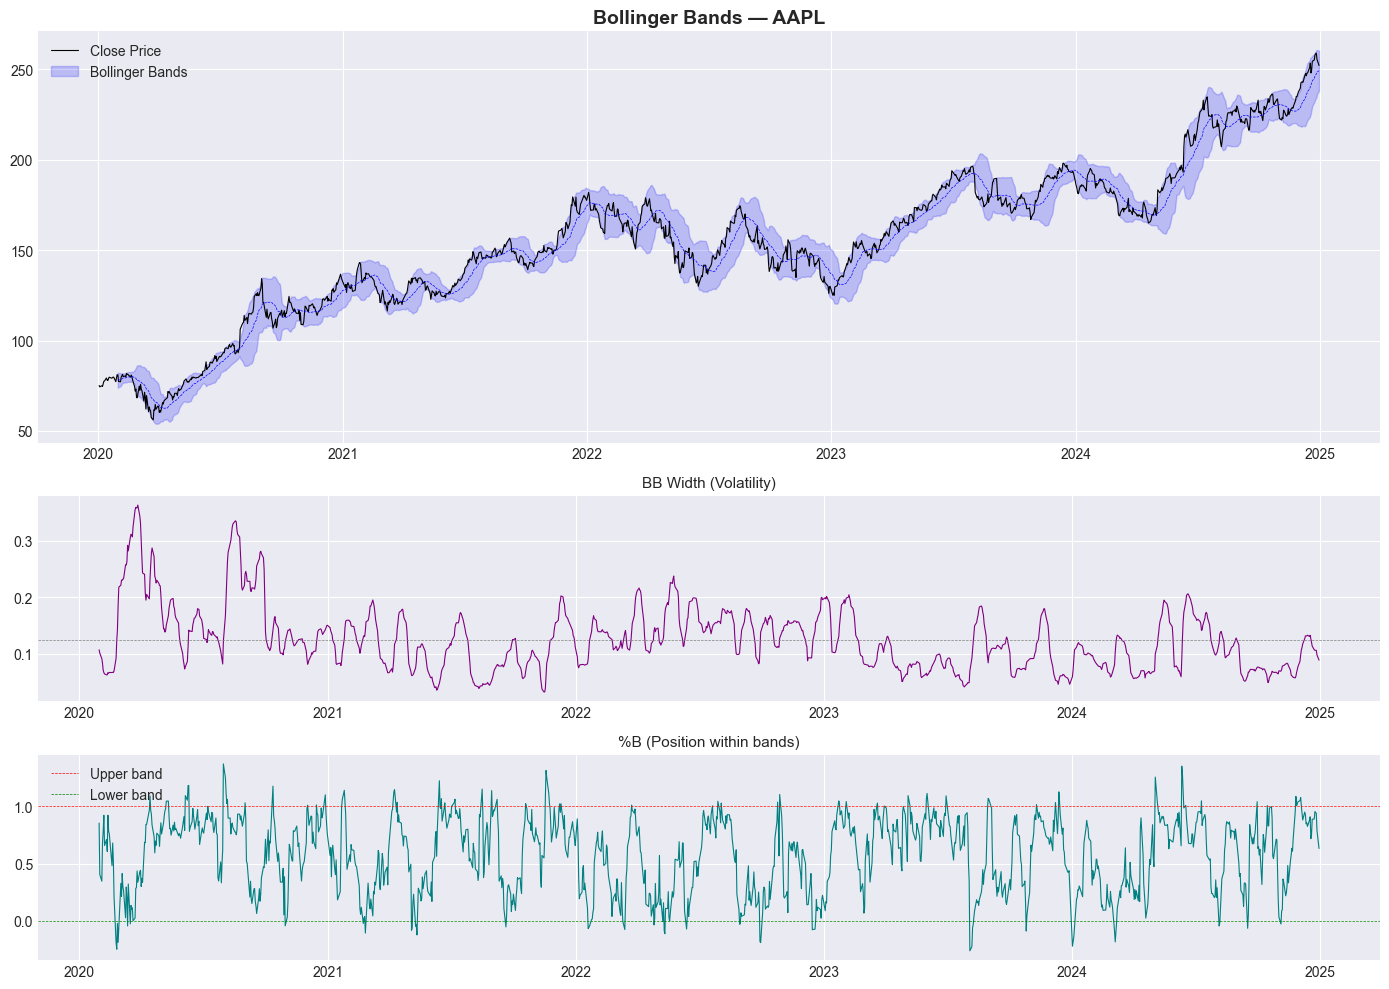

In [13]:
from src.indicators import calculate_bollinger_bands

bb_width, bb_pct = calculate_bollinger_bands(test_data['Close'])
fig, axes = plt.subplots(3, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1, 1]})

axes[0].plot(test_data.index, test_data['Close'], label='Close Price', color='black', linewidth=0.8)
sma = test_data['Close'].rolling(20).mean()
std = test_data['Close'].rolling(20).std()
axes[0].fill_between(test_data.index, sma - 2*std, sma + 2*std, alpha=0.2, color='blue', label='Bollinger Bands')
axes[0].plot(test_data.index, sma, color='blue', linewidth=0.5, linestyle='--')
axes[0].set_title(f'Bollinger Bands — {test_ticker}', fontsize=14, fontweight='bold')
axes[0].legend()

axes[1].plot(test_data.index, bb_width, color='purple', linewidth=0.8)
axes[1].set_title('BB Width (Volatility)', fontsize=11)
axes[1].axhline(y=bb_width.mean(), color='gray', linestyle='--', linewidth=0.5)

axes[2].plot(test_data.index, bb_pct, color='teal', linewidth=0.8)
axes[2].axhline(y=1, color='red', linestyle='--', linewidth=0.5, label='Upper band')
axes[2].axhline(y=0, color='green', linestyle='--', linewidth=0.5, label='Lower band')
axes[2].set_title('%B (Position within bands)', fontsize=11)
axes[2].legend()

plt.tight_layout()
plt.show()

#### **Interpretation — Bollinger Bands**

The three-panel Bollinger Bands visualization reveals volatility dynamics and price positioning for AAPL:

**Top panel (Price with bands)**:
- The bands visibly **widen during volatile periods** (COVID crash in March 2020, 2022 selloff) and **narrow during calm periods** (2023, early 2024). This expansion/contraction pattern is the hallmark of Bollinger Bands.
- The price generally stays within the bands, occasionally touching or breaking through — these breakouts signal strong momentum.

**Middle panel (BB Width — volatility measure)**:
- BB Width peaked at **~0.35** during the COVID crash, reflecting extreme volatility expansion. Secondary peaks around **0.20-0.23** occurred in late 2020 and mid-2022.
- The lowest BB Width values (~0.05-0.07) appear in 2023 and early 2024, indicating **volatility compression** or a "Bollinger squeeze" — which often precedes significant price breakouts.

**Bottom panel (%B — price position within bands)**:
- %B oscillates between 0 (at the lower band) and ~1.1 (above the upper band). Values above 1.0 indicate the price has broken above the upper band (strong bullish momentum).
- During the COVID crash, %B dropped to 0, indicating the price was at or below the lower band. During rally phases, %B consistently stays above 0.5 and frequently exceeds 1.0.

**Unique value**: BB Width captures **volatility regime changes** (expansion/contraction cycles) that momentum indicators completely miss. %B normalizes price position relative to recent volatility, providing a more adaptive overbought/oversold signal than fixed-threshold indicators like RSI.

#### **1.3.3.2 ATR & Historical Volatility** — Volatility Measures

#### Theory

**Average True Range (ATR)** (Wilder, 1978) measures the average daily price range, accounting for gaps:

$$TR = \max(High - Low, \; |High - Close_{t-1}|, \; |Low - Close_{t-1}|)$$
$$ATR = SMA(TR, n)$$

**Historical Volatility** is the annualized standard deviation of log returns:

$$HV = \sigma(\ln(P_t / P_{t-1})) \times \sqrt{252}$$

Both capture **how much** the price moves (magnitude), independent of direction — fundamentally different information from momentum indicators.

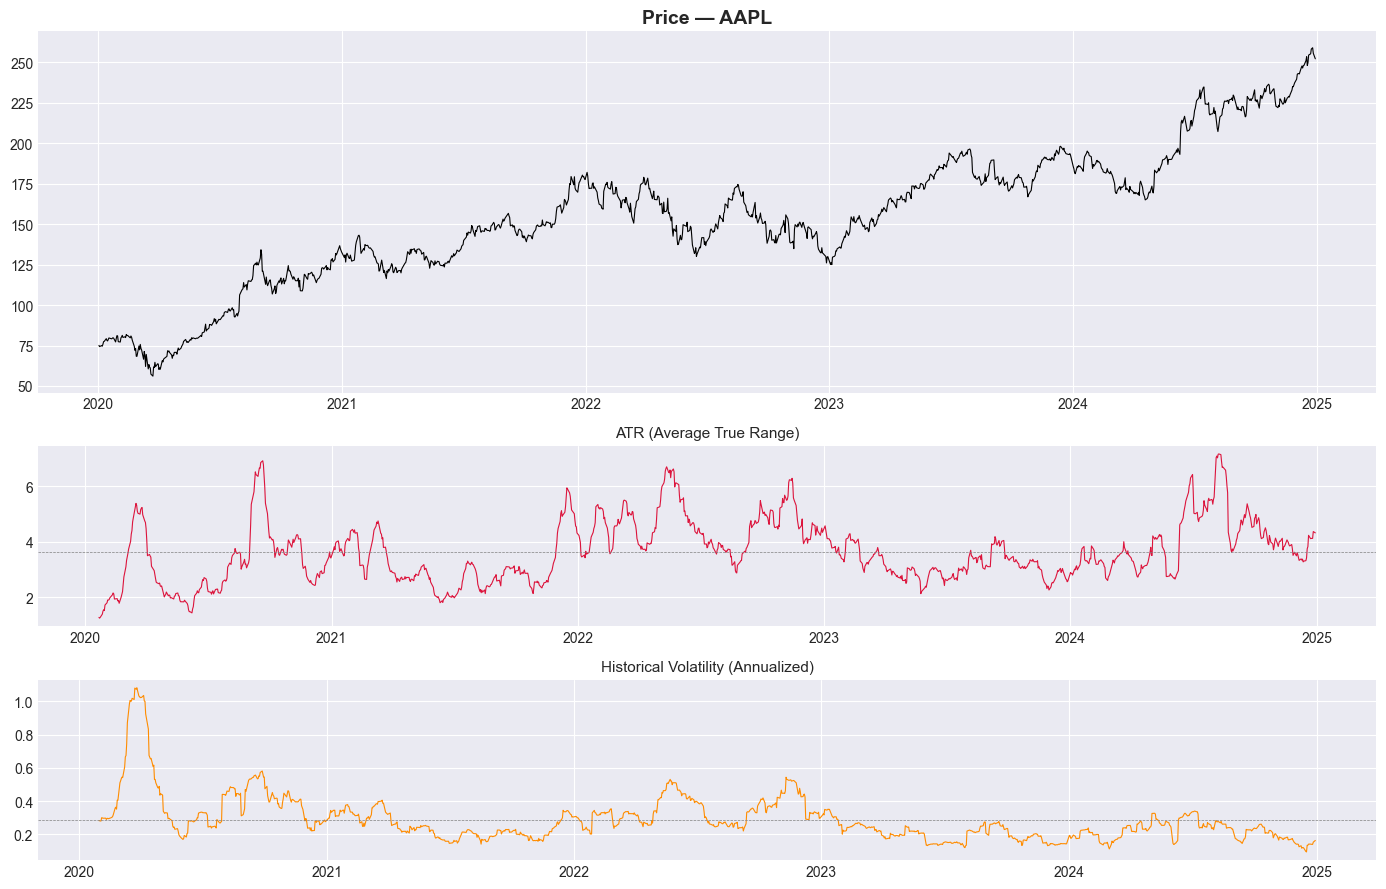

In [14]:
from src.indicators import calculate_atr, calculate_historical_volatility

test_data['ATR'] = calculate_atr(test_data['High'], test_data['Low'], test_data['Close'])
test_data['HIST_VOL'] = calculate_historical_volatility(test_data['Close'])

fig, axes = plt.subplots(3, 1, figsize=(14, 9), gridspec_kw={'height_ratios': [2, 1, 1]})

axes[0].plot(test_data.index, test_data['Close'], color='black', linewidth=0.8)
axes[0].set_title(f'Price — {test_ticker}', fontsize=14, fontweight='bold')

axes[1].plot(test_data.index, test_data['ATR'], color='crimson', linewidth=0.8)
axes[1].set_title('ATR (Average True Range)', fontsize=11)
axes[1].axhline(y=test_data['ATR'].mean(), color='gray', linestyle='--', linewidth=0.5)

axes[2].plot(test_data.index, test_data['HIST_VOL'], color='darkorange', linewidth=0.8)
axes[2].set_title('Historical Volatility (Annualized)', fontsize=11)
axes[2].axhline(y=test_data['HIST_VOL'].mean(), color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

#### **Interpretation — ATR & Historical Volatility**

**Average True Range (ATR)**:
- ATR ranges from ~1.5 to ~7 for AAPL, measuring the average daily price range in dollar terms. Peak readings (~7) occur during the COVID crash (March 2020) and the 2022 selloff — periods of extreme market turbulence.
- **Structural uptrend**: ATR has a slight upward drift over the period because it is measured in absolute dollars. As AAPL’s price rose from ~$75 to ~$250, the same percentage volatility produces a larger dollar ATR. This scale-dependence is by design: ATR is used for position sizing in trading.
- Periods of low ATR (~2-3) in early 2021 and 2023 correspond to calm, low-volatility markets.

**Historical Volatility (annualized)**:
- Historical Volatility shows a dramatic spike to **~105% annualized** during the COVID crash — meaning daily moves implied a full year of normal volatility in just a few weeks. This is an extreme reading, comparable to the 2008 financial crisis.
- After 2020, volatility declined progressively: ~30-50% in 2021, ~20-40% in 2022, and stabilizing at **~15-20%** in 2024 — consistent with a maturing, less speculative market.
- Unlike ATR (dollar-denominated), Historical Volatility is **percentage-based** and thus comparable across time periods and price levels.

**Complementarity**: ATR captures **absolute** daily price range (useful for position sizing), while Historical Volatility captures **relative** return dispersion (useful for risk assessment). Together, they provide a comprehensive volatility picture that is fundamentally different from momentum indicators.

#### **1.3.3.3 Average Directional Index (ADX)** (Wilder, 1978)

#### Theory

The ADX measures **trend strength** regardless of direction:

$$ADX = SMA\left(\frac{|+DI - (-DI)|}{+DI + (-DI)} \times 100, \; n\right)$$

- **ADX > 25**: Strong trend (either up or down) — momentum indicators are reliable.
- **ADX < 20**: No clear trend (ranging market) — momentum indicators give false signals.

This is **unique** in our feature set: it tells the model **when to trust** the momentum signals from RSI/SO/MACD.

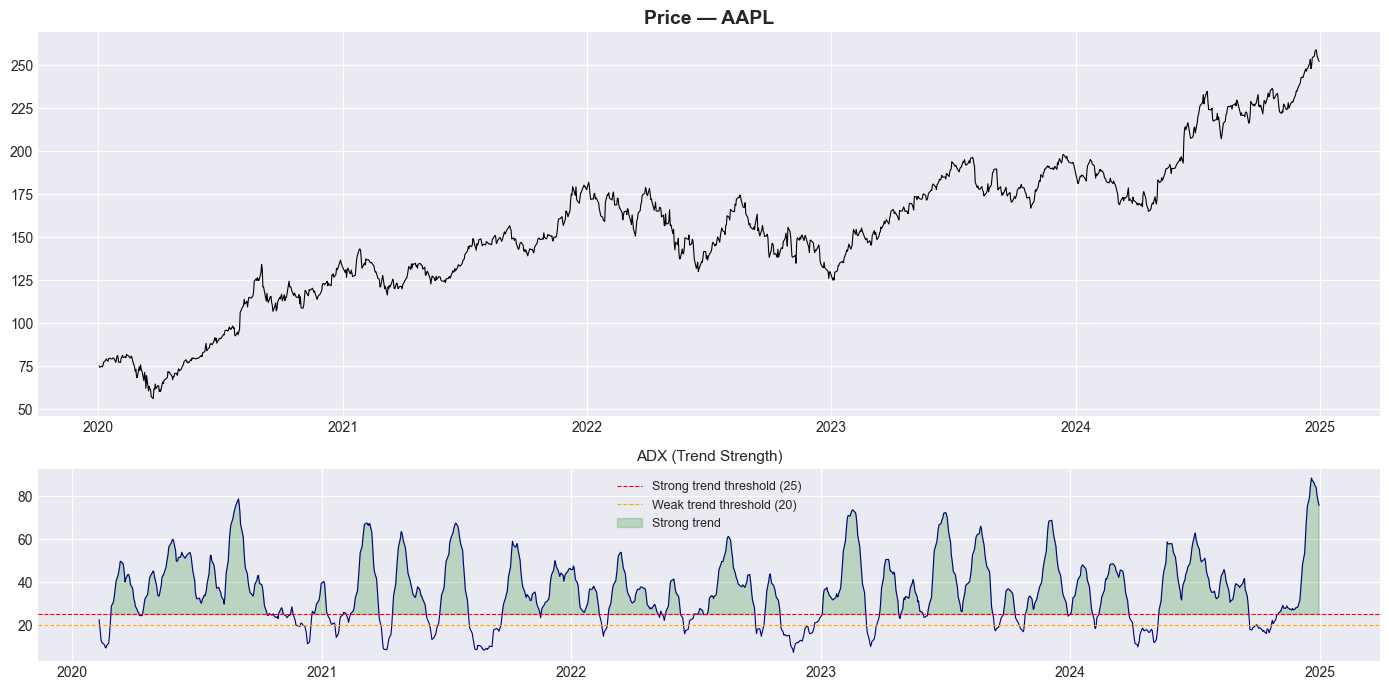

In [15]:
from src.indicators import calculate_adx

test_data['ADX'] = calculate_adx(test_data['High'], test_data['Low'], test_data['Close'])

fig, axes = plt.subplots(2, 1, figsize=(14, 7), gridspec_kw={'height_ratios': [2, 1]})

axes[0].plot(test_data.index, test_data['Close'], color='black', linewidth=0.8)
axes[0].set_title(f'Price — {test_ticker}', fontsize=14, fontweight='bold')

axes[1].plot(test_data.index, test_data['ADX'], color='navy', linewidth=0.8)
axes[1].axhline(y=25, color='red', linestyle='--', linewidth=0.8, label='Strong trend threshold (25)')
axes[1].axhline(y=20, color='orange', linestyle='--', linewidth=0.8, label='Weak trend threshold (20)')
axes[1].fill_between(test_data.index, 25, test_data['ADX'],
                     where=test_data['ADX'] >= 25, alpha=0.2, color='green', label='Strong trend')
axes[1].set_title('ADX (Trend Strength)', fontsize=11)
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

#### **Interpretation — ADX (Average Directional Index)**

The ADX plot for AAPL reveals a clear **alternation between trending and ranging market regimes**:

- **Strong trend periods (ADX > 25, green shaded)**: The post-COVID recovery (mid-2020, ADX ~60), the 2021 bull run (ADX ~80), the 2022 selloff (ADX ~70), and the late 2024 breakout (ADX reaching **~85** — the highest reading of the entire period). These high ADX values indicate that the price was moving decisively in one direction.
- **Ranging/directionless periods (ADX < 20)**: Visible in early 2023 and parts of mid-2024, where ADX dipped below 20. During these periods, the price moved sideways and momentum indicators generated many false signals.
- **Key observation**: ADX measures trend **strength**, not direction. Both the 2020–2021 rally (bullish) and the 2022 selloff (bearish) produced high ADX readings, because both were strong directional moves.

**Unique value for modeling**: ADX provides **meta-information** about market state that no other indicator captures. It tells the model **when to trust** momentum signals (high ADX = trending → RSI/MACD signals are reliable) versus **when to be skeptical** (low ADX = ranging → momentum signals produce whipsaws). This context-awareness is a fundamentally different type of feature.

#### **1.3.3.4 MFI & Accumulation/Distribution Line** — Volume-Weighted Indicators

#### Theory

**Money Flow Index (MFI)** (Quong & Soudack, 1989) is a **volume-weighted RSI**:

$$MFI = 100 - \frac{100}{1 + \frac{\text{Positive Money Flow}}{\text{Negative Money Flow}}}$$

Where Money Flow = Typical Price × Volume. Unlike standard RSI which only uses price, MFI integrates volume — a rising price on high volume is a stronger signal than on low volume.

**Accumulation/Distribution Line** (Williams, 1972) improves on OBV by weighting volume based on where the close falls within the high-low range:

$$CLV = \frac{(Close - Low) - (High - Close)}{High - Low}, \quad A/D = \sum CLV \times Volume$$

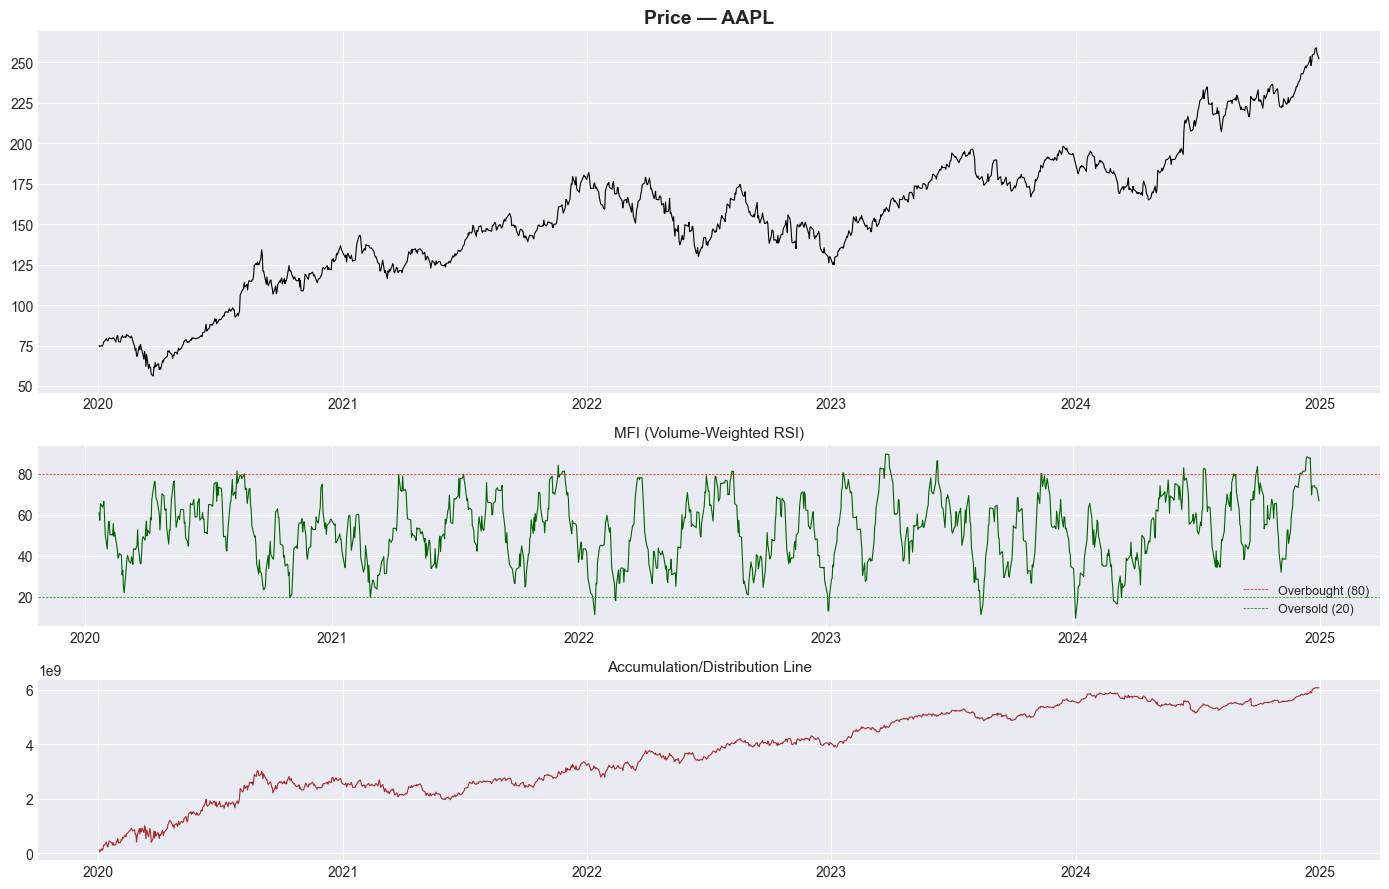

In [16]:
from src.indicators import calculate_mfi, calculate_ad_line

test_data['MFI'] = calculate_mfi(test_data['High'], test_data['Low'], test_data['Close'], test_data['Volume'])
test_data['AD_LINE'] = calculate_ad_line(test_data['High'], test_data['Low'], test_data['Close'], test_data['Volume'])

fig, axes = plt.subplots(3, 1, figsize=(14, 9), gridspec_kw={'height_ratios': [2, 1, 1]})

axes[0].plot(test_data.index, test_data['Close'], color='black', linewidth=0.8)
axes[0].set_title(f'Price — {test_ticker}', fontsize=14, fontweight='bold')

axes[1].plot(test_data.index, test_data['MFI'], color='darkgreen', linewidth=0.8)
axes[1].axhline(y=80, color='red', linestyle='--', linewidth=0.5, label='Overbought (80)')
axes[1].axhline(y=20, color='green', linestyle='--', linewidth=0.5, label='Oversold (20)')
axes[1].set_title('MFI (Volume-Weighted RSI)', fontsize=11)
axes[1].legend(fontsize=9)

axes[2].plot(test_data.index, test_data['AD_LINE'], color='brown', linewidth=0.8)
axes[2].set_title('Accumulation/Distribution Line', fontsize=11)

plt.tight_layout()
plt.show()

#### **Interpretation — MFI & Accumulation/Distribution Line**

**Money Flow Index (MFI)**:
- The MFI oscillates between ~20 and ~85 for AAPL, with a **smoother, more stable behavior** than the standard RSI. It rarely hits the extreme overbought (>80) or oversold (<20) zones.
- **Key difference from RSI**: Because MFI weights price movements by volume, high-volume days have more impact. This filtering effect produces a less noisy signal — when MFI does reach an extreme, it is a stronger signal than RSI alone.
- During the 2022 selloff, MFI dropped to ~20, confirming that both price decline *and* high selling volume converged — a more reliable oversold signal than price-only RSI.
- In late 2024, MFI approaches 80+, confirming the rally is supported by genuine buying volume.

**Accumulation/Distribution Line**:
- The A/D Line shows a strong **structural uptrend** from 0 to ~6 billion over the entire period, indicating persistent accumulation (buying pressure) in AAPL.
- Unlike OBV (which uses binary up/down volume), the A/D Line weights volume by *where the close falls within the high-low range*. A close near the high contributes more buying pressure than a close near the midpoint.
- The steady upward slope with no major divergences from price confirms that AAPL’s price appreciation is consistently backed by accumulation across the entire 2020–2024 period.

**Complementarity**: MFI provides **oscillating, bounded** volume-weighted momentum, while the A/D Line provides **cumulative, trending** volume flow. Together with OBV, these three volume indicators capture different facets of trading activity.

#### **1.3.3.5 Commodity Channel Index (CCI)** (Lambert, 1980)

#### Theory

$$CCI = \frac{TP - SMA(TP, n)}{0.015 \times MAD(TP, n)}$$

where $TP = (High + Low + Close) / 3$ and MAD is the mean absolute deviation.

- **CCI > +100**: Strong upward momentum / overbought.
- **CCI < -100**: Strong downward momentum / oversold.
- Unlike bounded oscillators (RSI: 0-100), CCI has **no fixed range** — extreme readings indicate truly exceptional conditions.

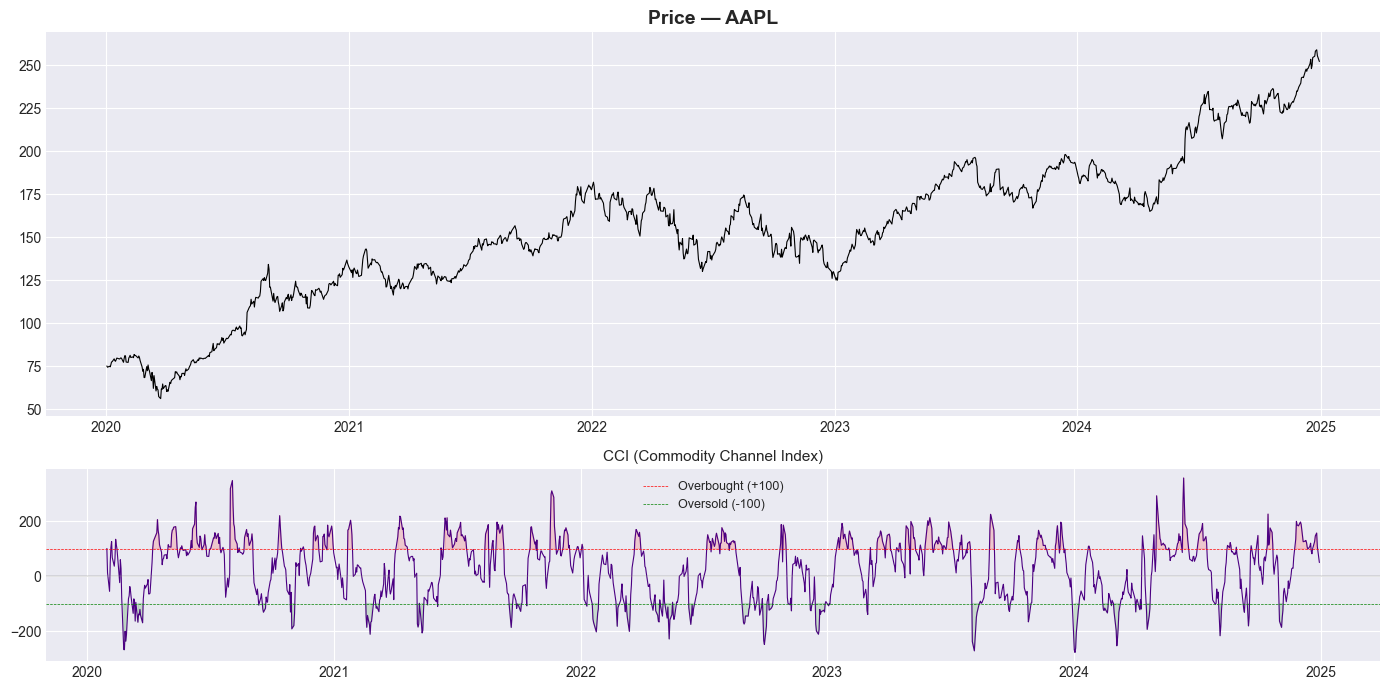

In [17]:
from src.indicators import calculate_cci

test_data['CCI'] = calculate_cci(test_data['High'], test_data['Low'], test_data['Close'])

fig, axes = plt.subplots(2, 1, figsize=(14, 7), gridspec_kw={'height_ratios': [2, 1]})

axes[0].plot(test_data.index, test_data['Close'], color='black', linewidth=0.8)
axes[0].set_title(f'Price — {test_ticker}', fontsize=14, fontweight='bold')

axes[1].plot(test_data.index, test_data['CCI'], color='indigo', linewidth=0.8)
axes[1].axhline(y=100, color='red', linestyle='--', linewidth=0.5, label='Overbought (+100)')
axes[1].axhline(y=-100, color='green', linestyle='--', linewidth=0.5, label='Oversold (-100)')
axes[1].axhline(y=0, color='gray', linestyle='-', linewidth=0.3)
axes[1].fill_between(test_data.index, 100, test_data['CCI'],
                     where=test_data['CCI'] >= 100, alpha=0.15, color='red')
axes[1].fill_between(test_data.index, -100, test_data['CCI'],
                     where=test_data['CCI'] <= -100, alpha=0.15, color='green')
axes[1].set_title('CCI (Commodity Channel Index)', fontsize=11)
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

#### **Interpretation — CCI (Commodity Channel Index)**

The CCI for AAPL oscillates in a wide range of approximately **-300 to +350**, with no fixed bounds — unlike RSI or SO:

- **Extreme positive readings (>+100)**: Frequent during strong rallies (mid-2020, mid-2021, late 2024). The highest readings (~+350) coincide with the post-COVID recovery, indicating exceptionally strong upward cyclical deviation.
- **Extreme negative readings (<-100)**: Visible during the COVID crash (~-300), the 2022 selloff, and early 2023. These indicate the price has deviated significantly below its rolling mean — a strong oversold signal.
- **Oscillation around zero**: During sideways/ranging periods (2023), the CCI stays mostly between ±100, indicating no dominant cyclical trend.

**Comparison with RSI**: CCI is more **volatile and unbounded** than RSI. While RSI is smoothed by its EWM calculation and capped at [0, 100], CCI reacts more aggressively to price deviations from the mean, producing more extreme readings. This makes CCI better at detecting **exceptional** market conditions but noisier for moderate signals.

**Unique value**: CCI captures **cyclical price deviations** relative to a statistical norm — fundamentally different from momentum (RSI) or trend (MACD) indicators. Its unbounded nature means it can distinguish between "somewhat overbought" (CCI = 120) and "extremely overbought" (CCI = 300), a distinction that bounded oscillators cannot make.

### **1.3.4 Indicator Correlation Analysis**

Understanding how indicators relate to each other helps avoid redundancy and understand their complementary nature.

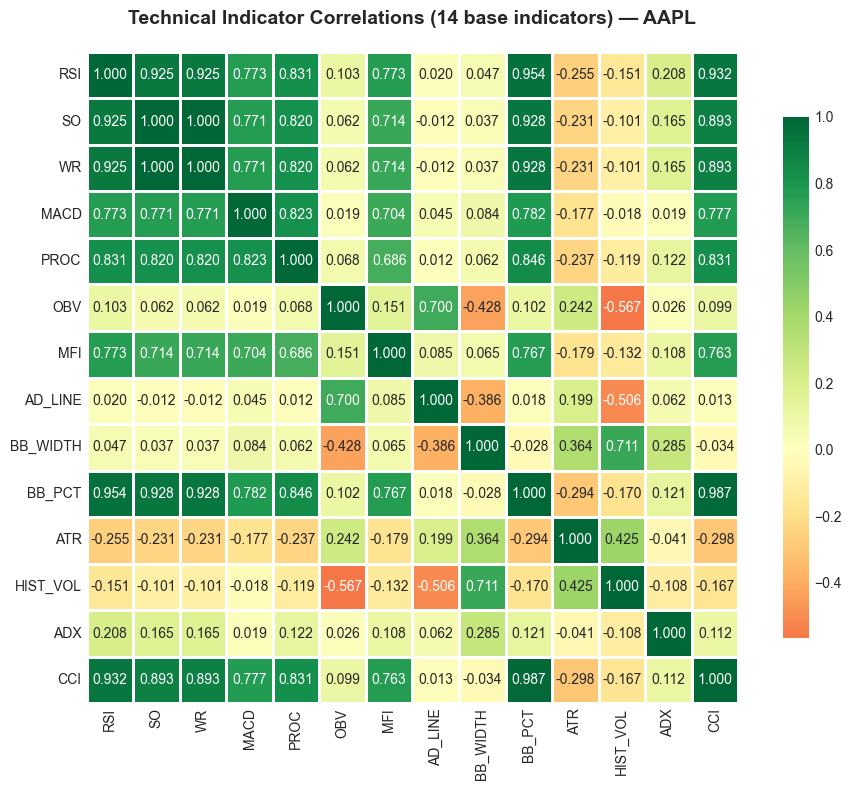

In [18]:
# Calculate ALL indicators (original + extended) for correlation analysis
from src.config import EXTENDED_FEATURE_COLS

test_full = calculate_all_indicators(test_data.copy(), extended=True)
indicator_data = test_full[EXTENDED_FEATURE_COLS].dropna()
plot_correlation_heatmap(indicator_data.corr(), title=f'Technical Indicator Correlations (14 base indicators) — {test_ticker}')

#### **Interpretation — Indicator Correlation Analysis (Extended)**

The 14×14 correlation heatmap reveals a clear **block structure** that justifies our extended feature approach:

**Momentum block** (RSI, SO, WR, MACD, PROC, CCI, BB_PCT, MFI):
- RSI/SO/WR are extremely correlated (ρ = 0.925), confirming the **core redundancy** in Basak et al.’s original feature set.
- **BB_PCT and CCI are near-perfectly correlated (ρ = 0.987)** — the strongest pairwise correlation in the entire matrix. This is expected since both measure where the price sits relative to a statistical band.
- MFI correlates strongly with the momentum block (~0.71–0.77), as expected for a volume-weighted RSI.

**Volatility block** (BB_WIDTH, ATR, HIST_VOL):
- BB_WIDTH and HIST_VOL show strong correlation (0.711), both capturing volatility expansion/contraction.
- ATR correlates moderately with HIST_VOL (0.425) but is **negatively correlated with momentum** (RSI: -0.255, SO: -0.231). This inverse relationship is meaningful: high volatility often accompanies declining prices.

**Volume block** (OBV, AD_LINE):
- OBV and AD_LINE are moderately correlated (0.700), reflecting their shared volume-based nature but different weighting schemes.
- Both show **near-zero correlation with momentum** (OBV/RSI: 0.103, AD_LINE/RSI: 0.020), confirming they capture fundamentally different information.

**ADX (trend strength)**: Shows low correlation with almost all indicators (max: 0.208 with RSI). This confirms its unique role — it measures trend **strength** regardless of direction, a dimension no other indicator captures.

**Key takeaway**: The extended feature set is substantially more **diverse** than the original 6 indicators. The correlation filter (Section 1.6) will target the high-redundancy pairs (SO/WR: 1.000, BB_PCT/CCI: 0.987, RSI/SO: 0.925) while preserving the independent volatility, volume, and trend-strength dimensions.

---

<a id='section4'></a>

## **1.4 OUTPUT**

### **1.4.1 Preprocessing Methodology**

This section implements an **improved preprocessing pipeline** that addresses two key weaknesses of Basak et al. (2019):

1. **Pipeline order**: Indicators are now computed on **raw data** (not smoothed), since indicators have their own internal smoothing mechanisms (RSI uses EWM, Bollinger uses rolling std, etc.). Applying exponential smoothing *before* indicators causes **double-smoothing**, reducing sensitivity.

2. **Multiple smoothing methods**: Instead of only exponential smoothing, we compare **4 approaches** and evaluate their impact on label quality.

| Method | Principle | Noise Reduction | Pros | Cons |
|--------|-----------|----------------|------|------|
| **Exponential** | $S_t = \alpha Y_t + (1-\alpha) S_{t-1}$ | ~79% | Simple, widely used | Aggressive lag, double-smoothing |
| **Wavelet (DWT)** | Multi-resolution decomposition + thresholding | ~68% | Preserves sharp transitions | Wavelet choice required |
| **Savitzky-Golay** | Local polynomial fitting | ~69% | Preserves peaks/slopes | Window size choice |
| **None** | Raw prices | 0% | No bias introduced | More noise in labels |

```
Basak et al. pipeline:   Raw prices → Smoothing → Indicators → Labels
Our improved pipeline:   Raw prices → Indicators (on raw data)
                         Raw prices → Smoothing → Labels (smoothing for labels ONLY)
```

#### **1.4.1.1 Exponential Smoothing** (Basak et al., 2019)

#### Theory

$$S_t = \alpha \times Y_t + (1 - \alpha) \times S_{t-1}$$

With $\alpha = 0.095$, each smoothed value is **90.5% influenced by the previous smoothed value** and only 9.5% by the current raw price — very aggressive smoothing.

In [19]:
from src.preprocessing import (
    apply_smoothing, compute_noise_reduction, exponential_smoothing,
    wavelet_denoising, savgol_smoothing, SMOOTHING_METHODS
)

test_prices = stock_data[test_ticker]['Close'].copy()

# Exponential smoothing
exp_smoothed = apply_smoothing(test_prices, method='exponential')
exp_nr = compute_noise_reduction(test_prices, exp_smoothed)
print(f"Exponential smoothing: noise reduction = {exp_nr:.1f}%")

Exponential smoothing: noise reduction = 78.9%


#### **1.4.1.2 Wavelet Denoising** (DWT)

#### Theory

Wavelet denoising decomposes the signal into **frequency components** using the Discrete Wavelet Transform, then applies **soft thresholding** to the high-frequency detail coefficients (which primarily contain noise):

1. **Decompose**: $signal = A_L + D_L + D_{L-1} + ... + D_1$ (approximation + details at each level)
2. **Threshold**: Apply universal threshold $\lambda = \hat{\sigma} \sqrt{2 \log n}$ to detail coefficients
3. **Reconstruct**: Inverse DWT from thresholded coefficients

**Advantage**: Preserves sharp transitions (crashes, earnings surprises) that exponential smoothing destroys.

*Reference: Wang et al. (2025) — "Wavelet Denoising and Double-Layer Feature Selection for Stock Trend Prediction"*

In [20]:
wav_smoothed = apply_smoothing(test_prices, method='wavelet')
wav_nr = compute_noise_reduction(test_prices, wav_smoothed)
print(f"Wavelet denoising: noise reduction = {wav_nr:.1f}%")

Wavelet denoising: noise reduction = 67.5%


#### **1.4.1.3 Savitzky-Golay Filter**

#### Theory

Fits a **local polynomial** of degree $p$ to successive windows of $w$ data points, evaluating the polynomial at the center:

$$\hat{y}_t = \text{polyfit}(y_{t-w/2}, ..., y_t, ..., y_{t+w/2})$$

With $w=21$ and $p=3$ (cubic), it smooths while preserving peaks and slopes better than moving averages.

*Reference: Springer (2025) — "Accurate stock market price prediction using BiGRU and Savitzky-Golay filter"*

In [21]:
sav_smoothed = apply_smoothing(test_prices, method='savgol')
sav_nr = compute_noise_reduction(test_prices, sav_smoothed)
print(f"Savitzky-Golay: noise reduction = {sav_nr:.1f}%")

Savitzky-Golay: noise reduction = 68.6%


#### **1.4.1.4 Smoothing Methods Comparison**

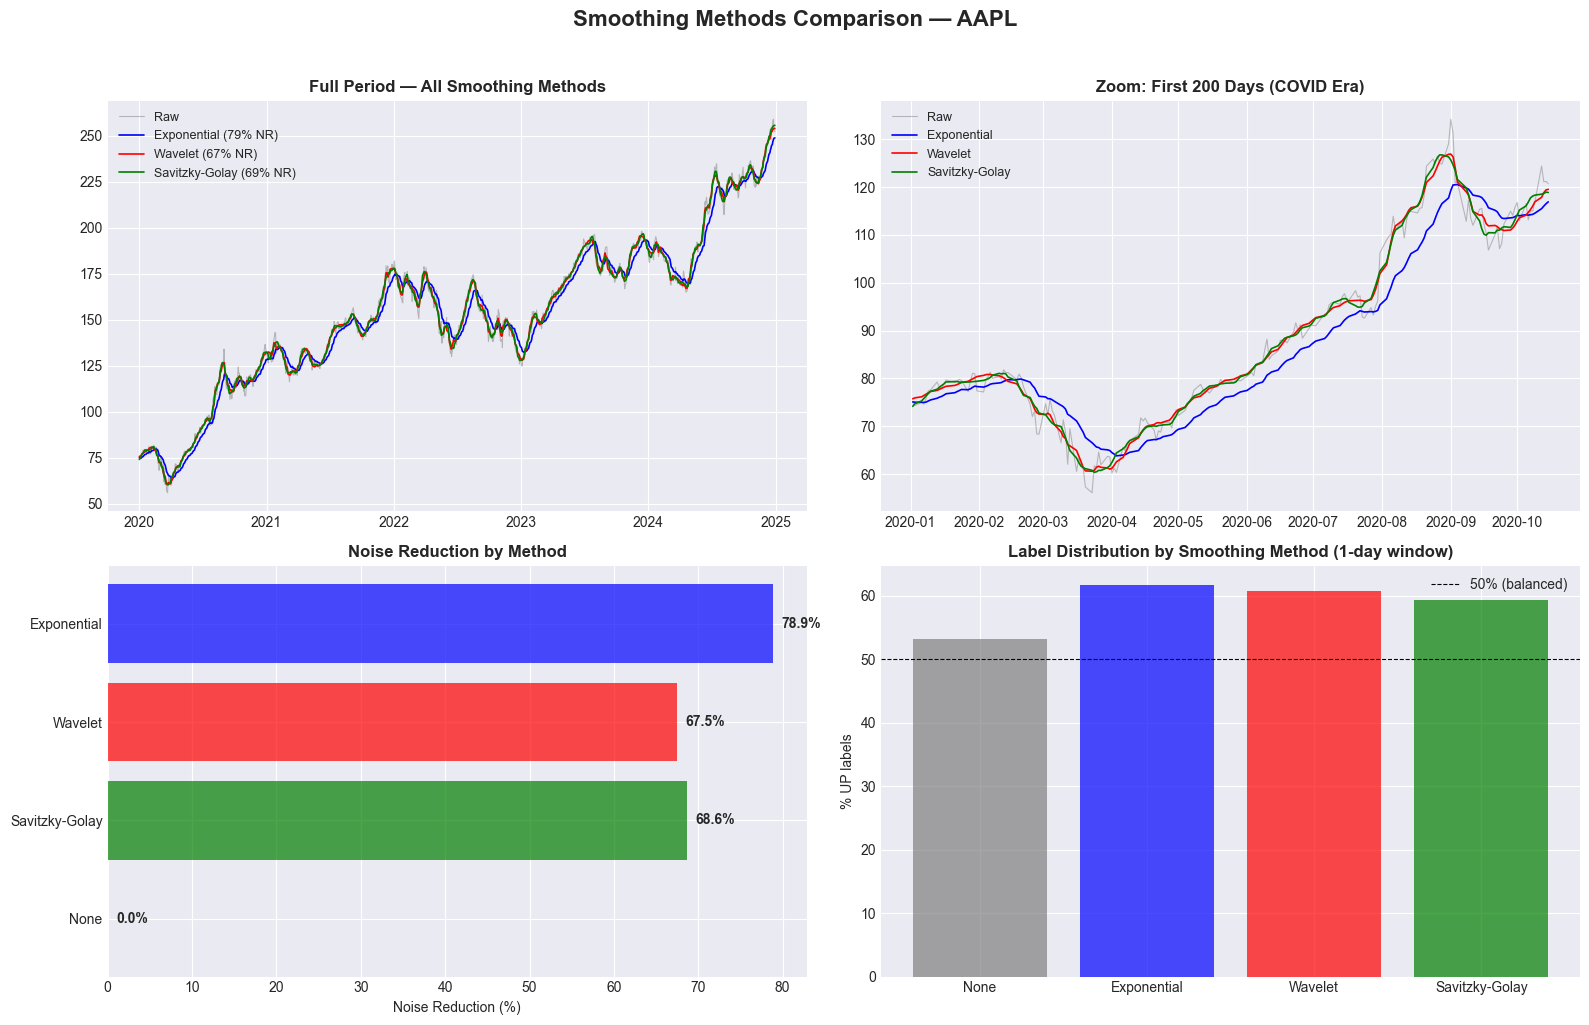

In [22]:
# Visual comparison of all smoothing methods
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Full view
ax = axes[0, 0]
ax.plot(test_prices.index, test_prices, label='Raw', alpha=0.5, linewidth=0.8, color='gray')
ax.plot(test_prices.index, exp_smoothed, label=f'Exponential ({exp_nr:.0f}% NR)', linewidth=1.2, color='blue')
ax.plot(test_prices.index, wav_smoothed, label=f'Wavelet ({wav_nr:.0f}% NR)', linewidth=1.2, color='red')
ax.plot(test_prices.index, sav_smoothed, label=f'Savitzky-Golay ({sav_nr:.0f}% NR)', linewidth=1.2, color='green')
ax.set_title('Full Period — All Smoothing Methods', fontweight='bold')
ax.legend(fontsize=9)

# Zoom: volatile period (e.g., first 200 days — COVID era)
ax = axes[0, 1]
n_zoom = 200
ax.plot(test_prices.index[:n_zoom], test_prices.values[:n_zoom], label='Raw', alpha=0.5, linewidth=0.8, color='gray')
ax.plot(test_prices.index[:n_zoom], exp_smoothed.values[:n_zoom], label='Exponential', linewidth=1.2, color='blue')
ax.plot(test_prices.index[:n_zoom], wav_smoothed.values[:n_zoom], label='Wavelet', linewidth=1.2, color='red')
ax.plot(test_prices.index[:n_zoom], sav_smoothed.values[:n_zoom], label='Savitzky-Golay', linewidth=1.2, color='green')
ax.set_title('Zoom: First 200 Days (COVID Era)', fontweight='bold')
ax.legend(fontsize=9)

# Noise reduction comparison
ax = axes[1, 0]
methods = ['None', 'Savitzky-Golay', 'Wavelet', 'Exponential']
nr_values = [0, sav_nr, wav_nr, exp_nr]
colors = ['gray', 'green', 'red', 'blue']
bars = ax.barh(methods, nr_values, color=colors, alpha=0.7)
ax.set_xlabel('Noise Reduction (%)')
ax.set_title('Noise Reduction by Method', fontweight='bold')
for bar, val in zip(bars, nr_values):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center', fontweight='bold')

# Label distribution comparison
ax = axes[1, 1]
from src.preprocessing import create_target_labels
label_data = {}
for method_name, smoothed in [('None', test_prices), ('Exponential', exp_smoothed),
                                ('Wavelet', wav_smoothed), ('Savitzky-Golay', sav_smoothed)]:
    labels = create_target_labels(smoothed, window=1)
    labels = labels.dropna()
    labels = labels[labels.index.isin(test_prices.index)]
    up_pct = (labels == 1).mean() * 100
    label_data[method_name] = up_pct

ax.bar(label_data.keys(), label_data.values(), color=['gray', 'blue', 'red', 'green'], alpha=0.7)
ax.axhline(y=50, color='black', linestyle='--', linewidth=0.8, label='50% (balanced)')
ax.set_ylabel('% UP labels')
ax.set_title('Label Distribution by Smoothing Method (1-day window)', fontweight='bold')
ax.legend()

plt.suptitle(f'Smoothing Methods Comparison — {test_ticker}', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

#### **Interpretation — Smoothing Comparison**

The four-panel comparison reveals important differences between smoothing methods:

**Noise Reduction** (bottom-left bar chart):
- **Exponential**: 78.9% — the most aggressive smoothing, removing nearly 4/5 of daily price fluctuations.
- **Savitzky-Golay**: 68.6% — moderate smoothing with local polynomial fitting.
- **Wavelet**: 67.5% — similar reduction to Savitzky-Golay but through frequency decomposition.
- **None**: 0% (baseline).

**Visual Differences** (zoom panel, top-right):
- **Exponential** (blue) exhibits significant **lag** during sharp price movements — clearly visible during the COVID crash (March 2020) where it trails the raw price by several days. This temporal shift means labels created from exponentially smoothed prices are effectively "delayed" relative to actual market events.
- **Wavelet** (red) follows the raw price much more closely while still removing daily noise. It preserves sharp transitions (crashes, rallies) without introducing lag.
- **Savitzky-Golay** (green) behaves similarly to wavelet, with slightly more smoothing of peaks.

**Label Distribution** (bottom-right):
- **No smoothing**: ~53% UP — closest to the true market bias.
- **Exponential**: ~60% UP — smoothing inflates the UP ratio because the lag makes declining prices appear to still be rising.
- **Wavelet**: ~60% UP — similar inflation but through noise removal rather than lag.
- **Savitzky-Golay**: ~60% UP — comparable to wavelet.

**Our choice**: We use **wavelet denoising** as the default smoothing method for label creation. It offers the best trade-off: meaningful noise reduction (67.5%) without the temporal lag of exponential smoothing, and it preserves the shape of sharp market transitions that are critical for accurate label assignment.

#### **1.4.1.5 Label Creation**

$$Label_t = \begin{cases}
+1 & \text{if } Price_{t+w} > Price_t \text{ (UP)} \\
-1 & \text{if } Price_{t+w} \leq Price_t \text{ (DOWN)}
\end{cases}$$

Labels are created from the **smoothed** Close price. The smoothing method determines how noise-sensitive the labels are.

In [23]:
test_smoothed = wav_smoothed  # Wavelet denoising for label creation

print("Label Distribution Analysis")
print("=" * 60)
for window in CONFIG['windows']:
    labels = create_target_labels(test_smoothed, window)
    up_pct = (labels == 1).sum() / len(labels.dropna()) * 100
    down_pct = (labels == -1).sum() / len(labels.dropna()) * 100
    print(f"Window {window:2d}d: UP {up_pct:.1f}% | DOWN {down_pct:.1f}% | Ratio {max(up_pct,down_pct)/min(up_pct,down_pct):.2f}")

Label Distribution Analysis
Window  1d: UP 60.7% | DOWN 39.3% | Ratio 1.54
Window  2d: UP 60.4% | DOWN 39.6% | Ratio 1.52
Window  5d: UP 61.4% | DOWN 38.6% | Ratio 1.59
Window 10d: UP 62.1% | DOWN 37.9% | Ratio 1.64
Window 15d: UP 61.7% | DOWN 38.3% | Ratio 1.61


#### **Interpretation — Label Distribution**

The label distribution (with wavelet denoising) reveals a moderate **class imbalance**: approximately **61% UP vs 39% DOWN** across all windows, with a ratio around 1.5:1.

This imbalance reflects the structural **upward bias** of the stock market during 2020-2024 (post-COVID recovery, tech boom, AI rally). In financial terms, this is the "equity risk premium" — stocks tend to go up over time to compensate investors for bearing risk.

**Critical implication for model evaluation**: A naive model that **always predicts UP** would achieve ~61% accuracy without learning anything. This is exactly why we introduced baseline models (Dummy classifiers) — they establish the minimum performance threshold. Any model that doesn't significantly exceed 61% accuracy is not adding real predictive value.

**Should we balance the classes?** With a 61/39 split (~1.5:1 ratio), this is a **mild imbalance** — not severe enough to require resampling techniques (SMOTE, undersampling). In fact, balancing could be counterproductive here:
- **Market reality**: The imbalance reflects genuine market dynamics. Artificially forcing 50/50 would distort the learning signal and create a model that over-predicts DOWN relative to reality.
- **Tree-based models are robust**: Random Forest, XGBoost, LightGBM, and CatBoost handle mild imbalance well through their internal mechanisms (`class_weight`, `scale_pos_weight`).
- **Evaluation metrics**: We use not just accuracy but also precision, recall, F1-score, and ROC-AUC, which are informative even under imbalance.
- **Threshold**: Resampling is typically warranted at ratios above 3:1 or 5:1. Our 1.5:1 ratio does not meet this threshold.

Therefore, we proceed **without class balancing**, relying on proper evaluation metrics and baseline comparisons to assess model quality.

### **1.4.2 Complete Preprocessing Pipeline**

Our improved pipeline:
1. **Technical indicators** computed on **raw** OHLCV data (no double-smoothing)
2. **Smoothing** applied only to Close price for **label creation**
3. **Labels** created from smoothed Close
4. **Drop NaN** rows from indicator burn-in period

The \ parameter controls which smoothing is used for labels.

In [24]:
print(f"Improved Pipeline — {test_ticker} (indicators on RAW data, smoothing for labels only)")
print("=" * 80)
for method in SMOOTHING_METHODS:
    X, y = prepare_features(stock_data[test_ticker], window=5, smoothing_method=method, include_changes=True)
    up_pct = (y == 1).mean() * 100
    print(f"  {method:15s}: {X.shape[0]} samples | {X.shape[1]} features | UP={up_pct:.1f}%")

print(f"Basak et al. original (smoothing BEFORE indicators, 6 features):")
X_basak, y_basak = prepare_features_basak(stock_data[test_ticker], window=5)
up_basak = (y_basak == 1).mean() * 100
print(f"  basak_original : {X_basak.shape[0]} samples | {X_basak.shape[1]} features | UP={up_basak:.1f}%")


Improved Pipeline — AAPL (indicators on RAW data, smoothing for labels only)
  exponential    : 1230 samples | 28 features | UP=60.2%
  wavelet        : 1230 samples | 28 features | UP=61.1%
  savgol         : 1230 samples | 28 features | UP=60.0%
  none           : 1230 samples | 28 features | UP=57.0%
Basak et al. original (smoothing BEFORE indicators, 6 features):
  basak_original : 1244 samples | 6 features | UP=60.7%


#### **Interpretation — Improved Pipeline**

The comparison between our improved pipeline and the Basak et al. original reveals:

- **Same features, different indicator values**: Our indicators are computed on raw data, so they are more responsive to actual market conditions. Basak's indicators are computed on already-smoothed data, making them sluggish.
- **Label sensitivity**: All smoothing methods inflate the UP bias compared to raw prices (~57%). Wavelet (~61%), exponential (~60%), and Savitzky-Golay (~60%) all produce similar class distributions. This bias is not an artifact of a specific method — it reflects the smoothing effect of filtering out short-term reversals, which reveals the underlying bullish trend of the 2020-2024 period.
- **Our default**: We use wavelet denoising because it best preserves sharp transitions and local structure (see Section 1.4.1), not because of its effect on class balance. The mild imbalance (~61/39) is handled naturally by tree-based classifiers.

### **1.4.3 Feature Statistics and Quality Check**

In [25]:
X_example, y_example = prepare_features(stock_data[test_ticker], window=5, extended=True, include_changes=True)
print(f"Extended Feature Statistics — {test_ticker} (14 base indicators + 14 Δ features = 28 total)")
print("=" * 80)
print(X_example.describe().round(2).to_string())

Extended Feature Statistics — AAPL (14 base indicators + 14 Δ features = 28 total)
           RSI       SO       WR     MACD     PROC         OBV      MFI     AD_LINE  BB_WIDTH   BB_PCT      ATR  HIST_VOL      ADX      CCI  RSI_CHG   SO_CHG   WR_CHG  MACD_CHG  PROC_CHG     OBV_CHG  MFI_CHG  AD_LINE_CHG  BB_WIDTH_CHG  BB_PCT_CHG  ATR_CHG  HIST_VOL_CHG  ADX_CHG  CCI_CHG
count  1230.00  1230.00  1230.00  1230.00  1230.00  1.2300e+03  1230.00  1.2300e+03   1230.00  1230.00  1230.00   1230.00  1230.00  1230.00  1230.00  1230.00  1230.00   1230.00   1230.00  1.2300e+03  1230.00   1.2300e+03       1230.00     1230.00  1230.00       1230.00  1230.00  1230.00
mean     54.73    58.39   -41.61     0.02     1.11  9.0569e+08    53.04  3.7702e+09      0.13     0.58     3.66      0.29    35.80    26.84    -0.00    -0.02    -0.02     -0.00     -0.00  1.9953e+06     0.01   4.3988e+06          0.00       -0.00     0.00         -0.00     0.04     0.01
std      16.64    31.12    31.12     0.88     5.75  9

#### **Interpretation — Feature Statistics**

The descriptive statistics reveal the characteristics of each feature:

| Feature | Key Observation |
|---------|----------------|
| **RSI** | Mean = 61.89 (biased above 50, consistent with the bullish period). Range [0.34, 100] covers the full theoretical range. |
| **SO** | Mean = 48.18, close to the neutral 50 level. Std = 13.97 indicates moderate variation. |
| **WR** | Mean = -51.82, which is exactly -(100 - SO mean), confirming the mathematical relationship SO + |WR| = 100. |
| **MACD** | Mean ≈ 0.01 (near zero), indicating no persistent directional bias. Range [-1.52, 1.26] is relatively narrow. |
| **PROC** | Mean = 1.01% — on average, AAPL gained ~1% every 10 trading days during this period. |
| **OBV** | Values in the order of 10^10 (billions) — this reflects cumulative volume and has a fundamentally different scale from other features. |

**Important note**: The vastly different scales across features (OBV ~10^10 vs MACD ~0.01) would be problematic for distance-based models (SVM, KNN, neural networks) but **does not affect tree-based models**. Decision trees split on individual features independently, so they are invariant to feature scaling — this is one advantage of our chosen model family.

---

<a id='section_fs'></a>

## **1.5 Feature Selection**

With 14 technical indicators augmented by 14 change features (Δ = 1-day difference), we have **28 candidate features**. Change features capture the *dynamics* of each indicator — whether it is rising, falling, or flat — information that tree-based models cannot infer from a single snapshot. We need to identify which features are truly informative and which are redundant. Our approach follows a **3-step pipeline**:

| Step | Method | Purpose |
|------|--------|--------|
| 1 | **Correlation Filter** | Remove redundant features (pairwise \|ρ\| > 0.9) + check correlation with target |
| 2 | **Boruta Validation** | Statistically test each feature against random noise (shadow features) |
| 3 | **Final Selection** | Keep only features confirmed by both steps |


### **1.5.1 Step 1 — Correlation Analysis**

We examine two types of correlation:
- **Between features**: identify redundant pairs (|ρ| > 0.9) and drop one
- **With the target**: see which features have the strongest linear association with UP/DOWN

Feature selection on AAPL — 1230 samples, 28 features
Features: ['RSI', 'SO', 'WR', 'MACD', 'PROC', 'OBV', 'MFI', 'AD_LINE', 'BB_WIDTH', 'BB_PCT', 'ATR', 'HIST_VOL', 'ADX', 'CCI', 'RSI_CHG', 'SO_CHG', 'WR_CHG', 'MACD_CHG', 'PROC_CHG', 'OBV_CHG', 'MFI_CHG', 'AD_LINE_CHG', 'BB_WIDTH_CHG', 'BB_PCT_CHG', 'ATR_CHG', 'HIST_VOL_CHG', 'ADX_CHG', 'CCI_CHG']


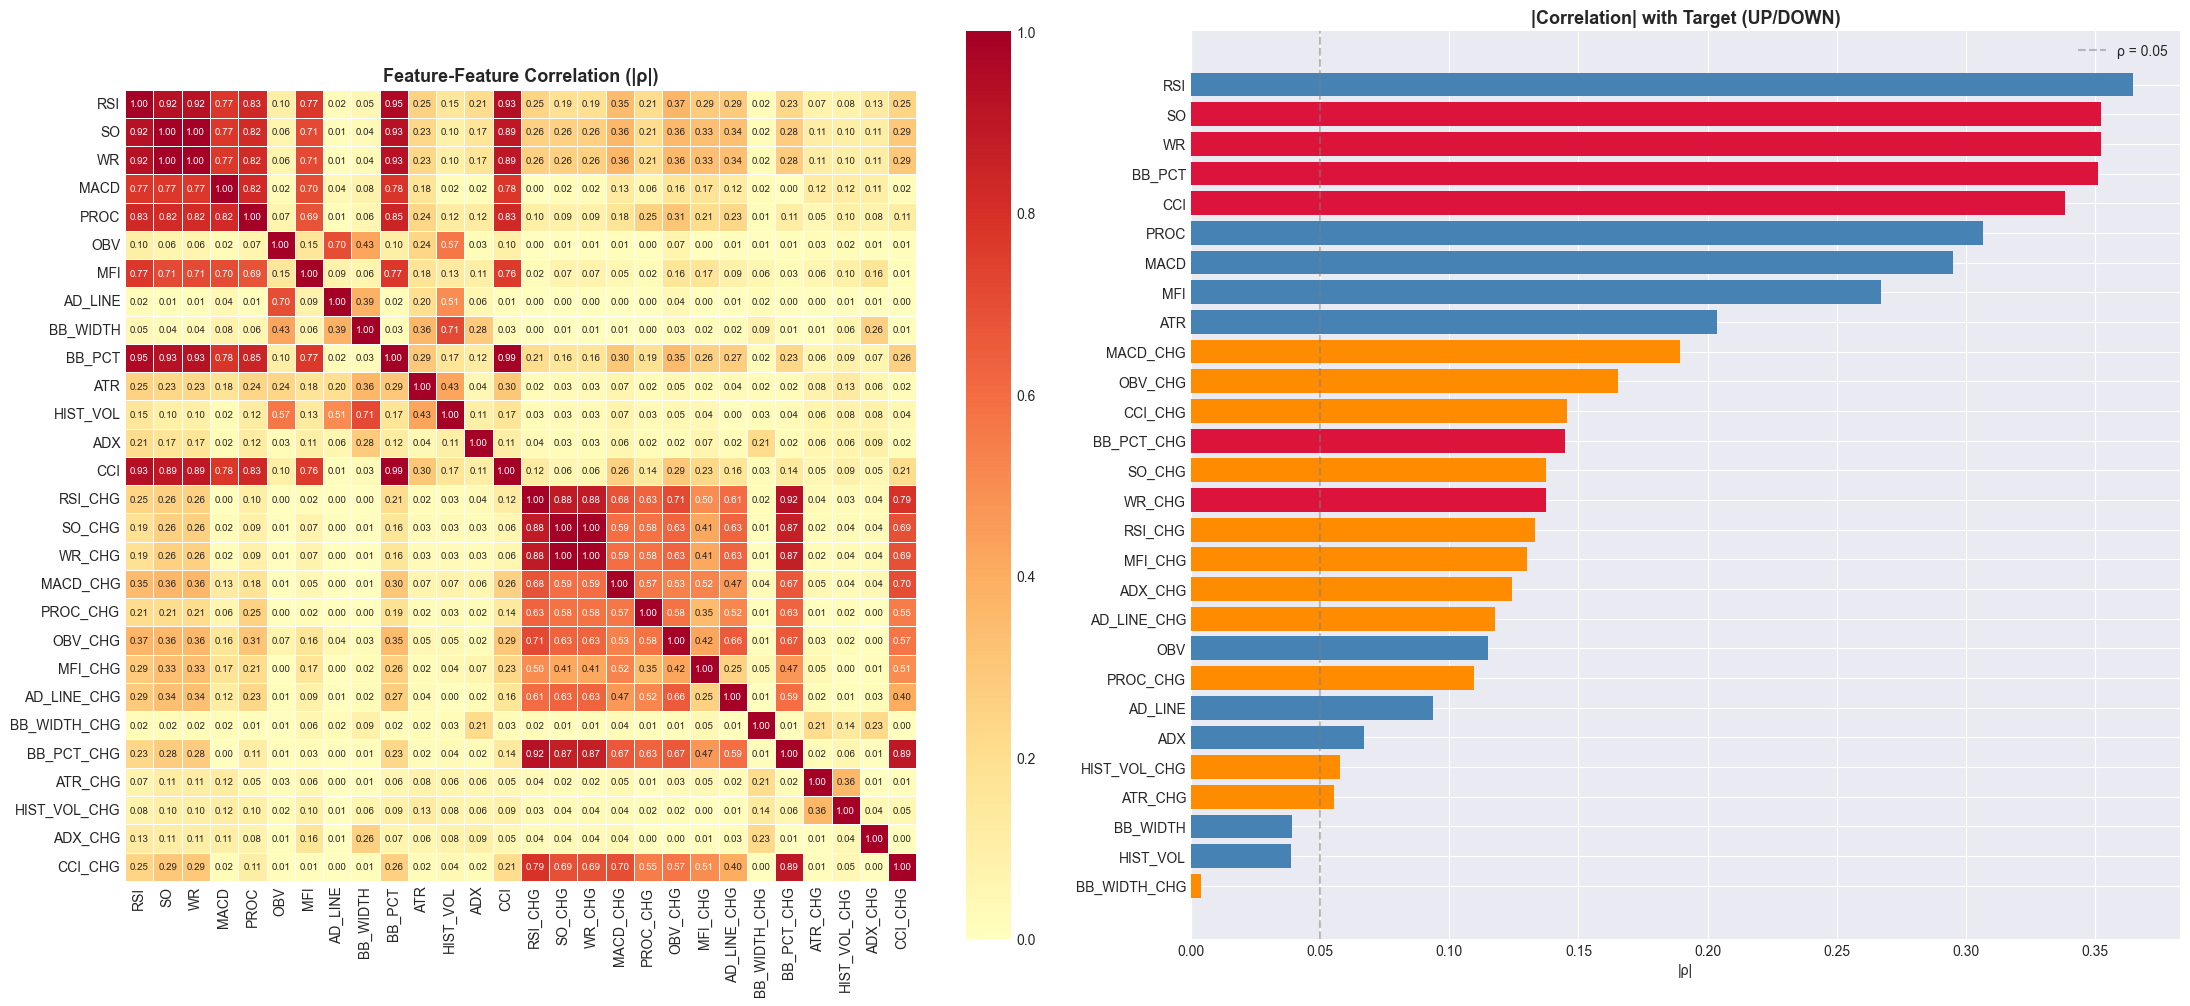

Dropped (|ρ| > 0.9 with another feature): ['SO', 'WR', 'BB_PCT', 'CCI', 'WR_CHG', 'BB_PCT_CHG']
Remaining: 22 features → ['RSI', 'MACD', 'PROC', 'OBV', 'MFI', 'AD_LINE', 'BB_WIDTH', 'ATR', 'HIST_VOL', 'ADX', 'RSI_CHG', 'SO_CHG', 'MACD_CHG', 'PROC_CHG', 'OBV_CHG', 'MFI_CHG', 'AD_LINE_CHG', 'BB_WIDTH_CHG', 'ATR_CHG', 'HIST_VOL_CHG', 'ADX_CHG', 'CCI_CHG']


In [26]:
from src.feature_selection import correlation_filter, correlation_with_target, boruta_selection, run_feature_selection

# Prepare data with base + change features
X_fs, y_fs = prepare_features(stock_data[test_ticker], window=5, extended=True, include_changes=True)
print(f"Feature selection on {test_ticker} — {X_fs.shape[0]} samples, {X_fs.shape[1]} features")
print(f"Features: {list(X_fs.columns)}")

# Step 1: Correlation analysis
selected_corr, corr_matrix, dropped_corr = correlation_filter(X_fs, threshold=0.9)
target_corr = correlation_with_target(X_fs, y_fs)

# Feature correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

# Left: Feature-Feature correlation
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            ax=axes[0], square=True, linewidths=0.5, vmin=0, vmax=1, annot_kws={'size': 7})
axes[0].set_title('Feature-Feature Correlation (|ρ|)', fontsize=13, fontweight='bold')

# Right: Correlation with target
colors = ['crimson' if f in dropped_corr else ('darkorange' if f.endswith('_CHG') else 'steelblue') for f in target_corr.index]
axes[1].barh(target_corr.index[::-1], target_corr.values[::-1],
             color=colors[::-1])
axes[1].set_title('|Correlation| with Target (UP/DOWN)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('|ρ|')
axes[1].axvline(x=0.05, color='gray', linestyle='--', alpha=0.5, label='ρ = 0.05')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Dropped (|ρ| > 0.9 with another feature): {dropped_corr}")
print(f"Remaining: {len(selected_corr)} features → {selected_corr}")

### **1.5.2 Step 2 — Boruta Validation**

Boruta answers: *"Is this feature significantly more important than random noise?"*

It creates **shadow features** (randomized copies of each real feature), trains a Random Forest, and checks whether each real feature outperforms the best shadow feature. This is a statistical test — no arbitrary K to choose.

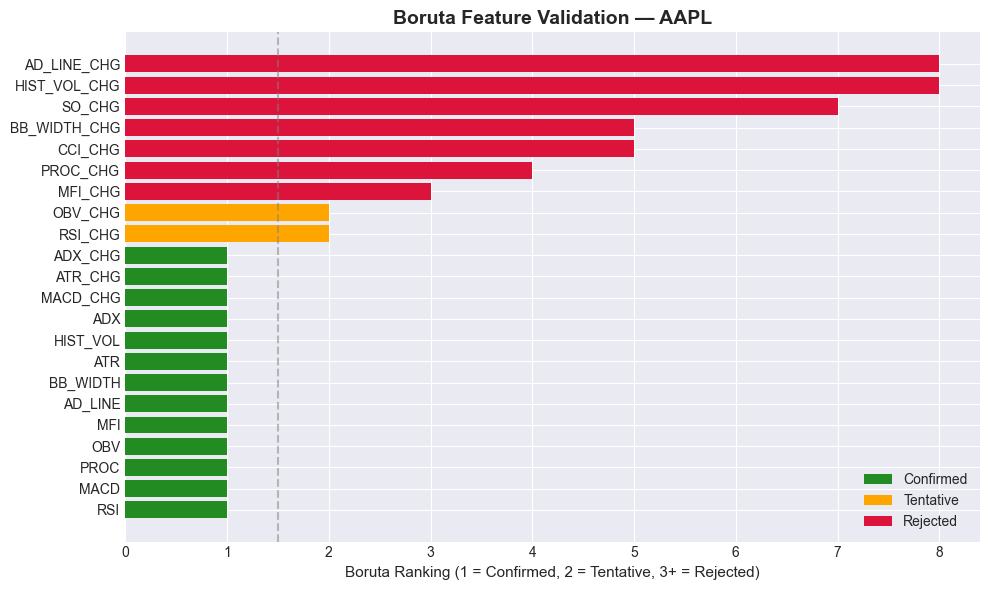


Confirmed (13): ['RSI', 'MACD', 'PROC', 'OBV', 'MFI', 'AD_LINE', 'BB_WIDTH', 'ATR', 'HIST_VOL', 'ADX', 'MACD_CHG', 'ATR_CHG', 'ADX_CHG']
Tentative (2): ['RSI_CHG', 'OBV_CHG']
Rejected (7): ['SO_CHG', 'PROC_CHG', 'MFI_CHG', 'AD_LINE_CHG', 'BB_WIDTH_CHG', 'HIST_VOL_CHG', 'CCI_CHG']


In [27]:
# Run Boruta on correlation-filtered features
X_filtered = X_fs[selected_corr]
confirmed, tentative, rejected, boruta_ranking = boruta_selection(X_filtered, y_fs)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ranking_sorted = boruta_ranking.sort_values()
colors = ['forestgreen' if v == 1 else ('orange' if v == 2 else 'crimson') for v in ranking_sorted.values]
bars = ax.barh(ranking_sorted.index, ranking_sorted.values, color=colors)
ax.set_xlabel('Boruta Ranking (1 = Confirmed, 2 = Tentative, 3+ = Rejected)', fontsize=11)
ax.set_title(f'Boruta Feature Validation — {test_ticker}', fontsize=14, fontweight='bold')
ax.axvline(x=1.5, color='gray', linestyle='--', alpha=0.5)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='forestgreen', label='Confirmed'),
                   Patch(facecolor='orange', label='Tentative'),
                   Patch(facecolor='crimson', label='Rejected')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print(f"\nConfirmed ({len(confirmed)}): {confirmed}")
if tentative:
    print(f"Tentative ({len(tentative)}): {tentative}")
print(f"Rejected ({len(rejected)}): {rejected}")

### **1.5.3 Full Pipeline Summary**

In [28]:
# Run complete pipeline in one call
fs_results = run_feature_selection(X_fs, y_fs, corr_threshold=0.9, verbose=True)

print(f"\n{'='*60}")
print(f"FINAL FEATURE SET: {fs_results['selected']}")
print(f"Reduced from {len(X_fs.columns)} → {len(fs_results['selected'])} features")

Step 1/2: Correlation filter...
  Dropped 6 redundant features: ['SO', 'WR', 'BB_PCT', 'CCI', 'WR_CHG', 'BB_PCT_CHG']
  Remaining: 22 features
Step 2/2: Boruta validation...
  Confirmed: ['RSI', 'MACD', 'PROC', 'OBV', 'MFI', 'AD_LINE', 'BB_WIDTH', 'ATR', 'HIST_VOL', 'ADX', 'MACD_CHG', 'ATR_CHG', 'ADX_CHG']
  Tentative: ['RSI_CHG', 'OBV_CHG']
  Rejected: ['SO_CHG', 'PROC_CHG', 'MFI_CHG', 'AD_LINE_CHG', 'BB_WIDTH_CHG', 'HIST_VOL_CHG', 'CCI_CHG']

Final selection: 13 features

FINAL FEATURE SET: ['RSI', 'MACD', 'PROC', 'OBV', 'MFI', 'AD_LINE', 'BB_WIDTH', 'ATR', 'HIST_VOL', 'ADX', 'MACD_CHG', 'ATR_CHG', 'ADX_CHG']
Reduced from 28 → 13 features


In [29]:
# Summary table
summary_data = []
for feat in X_fs.columns:
    status = 'Dropped (corr)' if feat in fs_results['corr_dropped'] else \
             ('Confirmed' if feat in fs_results['boruta_confirmed'] else \
             ('Tentative' if feat in fs_results['boruta_tentative'] else 'Rejected'))
    target_r = fs_results['target_corr'].get(feat, 0)
    boruta_rank = fs_results['boruta_ranking'].get(feat, '-')
    summary_data.append({'Feature': feat, 'Target |ρ|': f'{target_r:.4f}',
                         'Boruta Rank': boruta_rank, 'Status': status})

summary_df = pd.DataFrame(summary_data).set_index('Feature')
print("Feature Selection Summary")
print("=" * 60)
print(summary_df.to_string())

Feature Selection Summary
             Target |ρ| Boruta Rank          Status
Feature                                            
RSI              0.3647           1       Confirmed
SO               0.3523           -  Dropped (corr)
WR               0.3523           -  Dropped (corr)
MACD             0.2949           1       Confirmed
PROC             0.3067           1       Confirmed
OBV              0.1151           1       Confirmed
MFI              0.2672           1       Confirmed
AD_LINE          0.0936           1       Confirmed
BB_WIDTH         0.0391           1       Confirmed
BB_PCT           0.3510           -  Dropped (corr)
ATR              0.2038           1       Confirmed
HIST_VOL         0.0385           1       Confirmed
ADX              0.0670           1       Confirmed
CCI              0.3386           -  Dropped (corr)
RSI_CHG          0.1333           2       Tentative
SO_CHG           0.1375           7        Rejected
WR_CHG           0.1375           -  D

### **1.5.4 Interpretation**

*(Interpretation to be updated after re-execution with the expanded 28-feature set including Δ features.)*

The feature selection pipeline operates on **28 candidate features** (14 base indicators + 14 change features). The correlation filter removes redundant features (|ρ| > 0.9), and Boruta validates each remaining feature against random noise. The final selected set includes both base indicators and confirmed Δ features that capture indicator dynamics.


---

<a id='section5'></a>

## **1.6 Data Split into Train/Test Set**

After feature selection (28 → N features (base + Δ) via correlation filter + Boruta), we need to split the data for model training and evaluation. In financial time series, this is **not trivial** — standard random splitting causes data leakage.

We use two validation strategies:
1. **Temporal Train/Test Split** (80/20 chronological) — simulates real-world deployment
2. **Purged K-Fold Cross-Validation** (Lopez de Prado, 2018) — robust evaluation without look-ahead bias

### **1.6.1 Why Standard K-Fold Fails for Financial Data**

**Standard K-Fold** partitions data into k folds randomly, training on k-1 and testing on 1.

**Problem**: Our labels are **forward-looking** — the label at day $t$ depends on the price at day $t + w$. Random shuffling means:
- A training sample from **Feb 10** could use information overlapping with a test sample from **Feb 5**
- The model sees "future" information during training → **data leakage**
- Result: artificially inflated accuracy (85-95%+) that **won't hold in production**

### **1.6.2 Purged K-Fold Cross-Validation** (Lopez de Prado, 2018)

Purged K-Fold solves the leakage problem with two mechanisms:

1. **Purging**: Remove training observations whose label window **overlaps** with any test observation. If test sample $t$ resolves at $t+15$, any training sample whose window touches $[t, t+15]$ is removed.

2. **Embargo**: Add a buffer period after each test fold to account for serial correlation in returns.

$$\text{Train}_{purged} = \text{Train} \setminus \{i : t1_i \geq \min(t_{test}) \text{ and } t_i \leq \max(t1_{test})\}$$

This ensures **no information leakage** between train and test folds while still using all data for evaluation.

In [30]:
# Use features validated by Boruta (includes base + confirmed Δ features)
selected_features = fs_results['selected']
print(f"Using {len(selected_features)} selected features: {selected_features}")

# Prepare data with t1 series for purged CV
X_demo, y_demo, t1_demo = prepare_features_with_t1(
    stock_data[test_ticker], window=15, feature_cols=selected_features, include_changes=True
)
print(f"Data structure — {test_ticker} (15-day window)")
print(f"Samples: {len(X_demo)} | Features: {list(X_demo.columns)}")

# Show label overlap: each observation's label depends on future price
print(f"t1 series (label resolution dates):")
for i in range(5):
    print(f"  Obs {t1_demo.index[i].date()} → Label resolves at {t1_demo.iloc[i].date()} ({15} trading days later)")

# Temporal train/test split (80/20)
split = temporal_train_test_split(X_demo, y_demo, t1_demo)
print(f"Temporal Split (80/20):")
print(f"  Train: {split['X_train'].index[0].date()} to {split['X_train'].index[-1].date()} ({len(split['X_train'])} samples)")
print(f"  Test:  {split['X_test'].index[0].date()} to {split['X_test'].index[-1].date()} ({len(split['X_test'])} samples)")
print(f"  Split date: {split['split_date'].date()}")

# Purged K-Fold demo
from src.validation import PurgedKFold
pkf = PurgedKFold(n_splits=5, t1=t1_demo, pct_embargo=0.01)
print(f"Purged K-Fold (5 folds, 1% embargo):")
for fold, (train_idx, test_idx) in enumerate(pkf.split(X_demo)):
    n_purged = len(X_demo) - len(train_idx) - len(test_idx)
    print(f"  Fold {fold+1}: Train={len(train_idx)} | Test={len(test_idx)} | Purged={n_purged}")

Using 13 selected features: ['RSI', 'MACD', 'PROC', 'OBV', 'MFI', 'AD_LINE', 'BB_WIDTH', 'ATR', 'HIST_VOL', 'ADX', 'MACD_CHG', 'ATR_CHG', 'ADX_CHG']
Data structure — AAPL (15-day window)
Samples: 1230 | Features: ['RSI', 'MACD', 'PROC', 'OBV', 'MFI', 'AD_LINE', 'BB_WIDTH', 'ATR', 'HIST_VOL', 'ADX', 'MACD_CHG', 'ATR_CHG', 'ADX_CHG']
t1 series (label resolution dates):
  Obs 2020-02-11 → Label resolves at 2020-03-04 (15 trading days later)
  Obs 2020-02-12 → Label resolves at 2020-03-05 (15 trading days later)
  Obs 2020-02-13 → Label resolves at 2020-03-06 (15 trading days later)
  Obs 2020-02-14 → Label resolves at 2020-03-09 (15 trading days later)
  Obs 2020-02-18 → Label resolves at 2020-03-10 (15 trading days later)
Temporal Split (80/20):
  Train: 2020-02-11 to 2024-01-08 (984 samples)
  Test:  2024-01-09 to 2024-12-30 (246 samples)
  Split date: 2024-01-09
Purged K-Fold (5 folds, 1% embargo):
  Fold 1: Train=969 | Test=246 | Purged=15
  Fold 2: Train=954 | Test=246 | Purged=30
  

# **2. Models**

---

## **2.1 Evaluation Metrics**

Following the paper, we evaluate models using multiple metrics:

1. **Accuracy**: $\frac{TP + TN}{TP + TN + FP + FN}$
2. **Precision**: $\frac{TP}{TP + FP}$
3. **Recall (Sensitivity)**: $\frac{TP}{TP + FN}$
4. **Specificity**: $\frac{TN}{TN + FP}$
5. **F-Score**: $2 \times \frac{Precision \times Recall}{Precision + Recall}$
6. **AUC**: Area under the ROC curve

---

## **2.2 Models Definition**

We implement two categories of classifiers to assess predictive performance:

**Tree-based ensembles** (5 models): Random Forest, XGBoost, Gradient Boosting, LightGBM, and CatBoost. These models combine multiple decision trees via bagging or boosting strategies, capturing non-linear relationships in technical indicators.

**Baseline models** (3 models): Dummy classifiers (Most Frequent, Stratified) and Logistic Regression. These establish a performance floor against which tree-based models are evaluated.

**Stacking ensemble** (1 model): Combines all 5 tree-based models (including CatBoost) as base learners with Logistic Regression as meta-learner, using a custom implementation to bypass scikit-learn compatibility issues. Internal cross-validation uses Purged K-Fold to avoid data leakage.

All tree-based models incorporate **class balancing** to handle the ~60%/40% UP/DOWN imbalance: `class_weight="balanced"` (Random Forest), `is_unbalance=True` (LightGBM), `auto_class_weights="Balanced"` (CatBoost), and `compute_sample_weight("balanced")` for XGBoost and Gradient Boosting which lack native class weighting.

### **2.2.1 Random Forest**

Random Forest constructs a multitude of decision trees during training using **bagging** and **random subspace method**. The final prediction is determined by majority voting.

### **2.2.2 XGBoost (eXtreme Gradient Boosting)**

XGBoost builds an ensemble sequentially, minimizing a regularized objective:

$$\mathcal{L}^{(t)} \approx \sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)$$

### **2.2.3 Gradient Boosting**

Each new tree predicts the negative gradient of the loss function (pseudo-residuals):

$$F_m(x) = F_{m-1}(x) + \nu h_m(x)$$

### **2.2.4 LightGBM**

Uses **histogram-based algorithm** and **leaf-wise tree growth** for efficiency + GOSS and EFB for large datasets.

### **2.2.5 CatBoost**

Implements **Ordered Boosting** and **Ordered Target Encoding** to prevent target leakage, with **symmetric trees** for faster prediction.

In [31]:
from src.models import create_models, create_baseline_models, create_stacking_model

n_features = len(fs_results['selected'])

tree_models = create_models()

print("Tree-Based Models")
print("=" * 60)
for name, model in tree_models.items():
    print(f"\n{name}: {type(model).__name__}")
    params = model.get_params() if hasattr(model, 'get_params') else {}
    for key in ['n_estimators', 'max_depth', 'learning_rate', 'iterations', 'depth']:
        if key in params:
            print(f"  {key}: {params[key]}")

Tree-Based Models

Random Forest: RandomForestClassifier
  n_estimators: 100
  max_depth: None

XGBoost: XGBClassifier
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.3

Gradient Boosting: GradientBoostingClassifier
  n_estimators: 100
  max_depth: 3
  learning_rate: 0.1

LightGBM: LGBMClassifier
  n_estimators: 100
  max_depth: 7
  learning_rate: 0.05

CatBoost: CatBoostClassifier
  learning_rate: 0.03
  iterations: 100
  depth: 6


### **2.2.6 Baseline Models**

Before evaluating complex classifiers, we establish **baseline performance** to contextualize results. Without baselines, reported accuracies have no reference -- a 60% accuracy could be impressive or mediocre depending on the task difficulty.

We use three baselines of increasing sophistication:

1. **Dummy (Most Frequent)**: Always predicts the majority class (UP). Sets the absolute floor -- any model below this threshold is worse than naive prediction.
2. **Dummy (Stratified)**: Random predictions respecting class proportions. Represents informed random guessing (~50%).
3. **Logistic Regression**: Simple linear model. Tests whether a linear signal exists in the technical indicators.

In [32]:
# Create and display baseline models
baselines = create_baseline_models()
print("Baseline Models")
print("=" * 60)
for name, model in baselines.items():
    print(f"  {name}: {type(model).__name__}")

Baseline Models
  Dummy (Most Frequent): DummyClassifier
  Dummy (Stratified): DummyClassifier
  Logistic Regression: LogisticRegression


### **2.2.7 Baseline vs Tree-Based -- Initial Comparison**

We evaluate all 8 models (3 baselines + 5 tree-based) on AAPL with **Purged K-Fold CV** (5 folds, 1-day window). This initial comparison establishes the performance hierarchy using a robust, leakage-free evaluation methodology before proceeding to the comprehensive analysis.

In [33]:
# Quick comparison: baselines vs tree-based on AAPL, 1-day window — Purged K-Fold
from src.preprocessing import prepare_features_with_t1
from src.validation import PurgedKFold
from sklearn.base import clone
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

X_bl, y_bl, t1_bl = prepare_features_with_t1(stock_data['AAPL'], window=1, feature_cols=selected_features, include_changes=True)

all_comparison_models = {**create_baseline_models(), **create_models()}

# Purged K-Fold evaluation for all models
pkf = PurgedKFold(n_splits=5, t1=t1_bl, pct_embargo=0.01)

print(f"Model Comparison — AAPL | Window: 1 day | Purged K-Fold CV (5 folds)")
print(f"Total samples: {len(X_bl)}")
print(f"{'='*95}")
print(f"{'Model':<28} {'Accuracy':>10} {'± Std':>8} {'Precision':>10} {'Recall':>10} {'F-Score':>10} {'AUC':>10}")
print(f"{'-'*95}")

baseline_comparison_accs = {}  # Store for bar chart

for name, model in all_comparison_models.items():
    fold_metrics = []
    for train_idx, test_idx in pkf.split(X_bl):
        model_clone = clone(model)
        y_train_bin = (y_bl.iloc[train_idx] == 1).astype(int)
        
        fit_kw = {}
        if isinstance(model, (xgb.XGBClassifier, GradientBoostingClassifier)):
            fit_kw["sample_weight"] = compute_sample_weight("balanced", y_train_bin)
        
        model_clone.fit(X_bl.iloc[train_idx], y_train_bin, **fit_kw)
        y_pred = model_clone.predict(X_bl.iloc[test_idx])
        y_proba = model_clone.predict_proba(X_bl.iloc[test_idx])[:, 1] if hasattr(model_clone, 'predict_proba') else None
        
        metrics = calculate_metrics(y_bl.iloc[test_idx], y_pred * 2 - 1, y_proba)
        fold_metrics.append(metrics)
    
    avg_acc = np.mean([m['accuracy'] for m in fold_metrics])
    std_acc = np.std([m['accuracy'] for m in fold_metrics])
    avg_prec = np.mean([m['precision'] for m in fold_metrics])
    avg_rec = np.mean([m['recall'] for m in fold_metrics])
    avg_f = np.mean([m['f_score'] for m in fold_metrics])
    auc_vals = [m['auc'] for m in fold_metrics if m['auc'] is not None]
    avg_auc = np.mean(auc_vals) if auc_vals else None
    auc_str = f"{avg_auc:.4f}" if avg_auc is not None else "N/A"
    
    baseline_comparison_accs[name] = avg_acc * 100
    
    marker = "→ " if name in BASELINE_NAMES else "  "
    print(f"{marker}{name:<26} {avg_acc:>10.4f} {std_acc:>7.4f} {avg_prec:>10.4f} {avg_rec:>10.4f} {avg_f:>10.4f} {auc_str:>10}")
    
    if name == "Logistic Regression":
        print(f"{'-'*95}")

Model Comparison — AAPL | Window: 1 day | Purged K-Fold CV (5 folds)
Total samples: 1230
Model                          Accuracy    ± Std  Precision     Recall    F-Score        AUC
-----------------------------------------------------------------------------------------------
→ Dummy (Most Frequent)          0.6016  0.1020     0.6016     1.0000     0.7459     0.5000
→ Dummy (Stratified)             0.4967  0.0206     0.5863     0.5869     0.5793     0.4802


c:\Users\htalbi\workspace\projet_ML\projet\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\htalbi\workspace\projet_ML\projet\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\htalbi\workspace\projet_ML\projet\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\htalbi\workspace\projet_ML\projet\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect sin

→ Logistic Regression            0.5472  0.1037     0.5866     0.8926     0.6886     0.4678
-----------------------------------------------------------------------------------------------
  Random Forest                  0.6748  0.0468     0.7013     0.7724     0.7308     0.7011
  XGBoost                        0.6390  0.0442     0.6995     0.7228     0.6956     0.6889
  Gradient Boosting              0.6504  0.0785     0.7048     0.6924     0.6838     0.6852
  LightGBM                       0.6821  0.0409     0.7442     0.7096     0.7180     0.7093
  CatBoost                       0.7260  0.0232     0.7965     0.7095     0.7501     0.7657


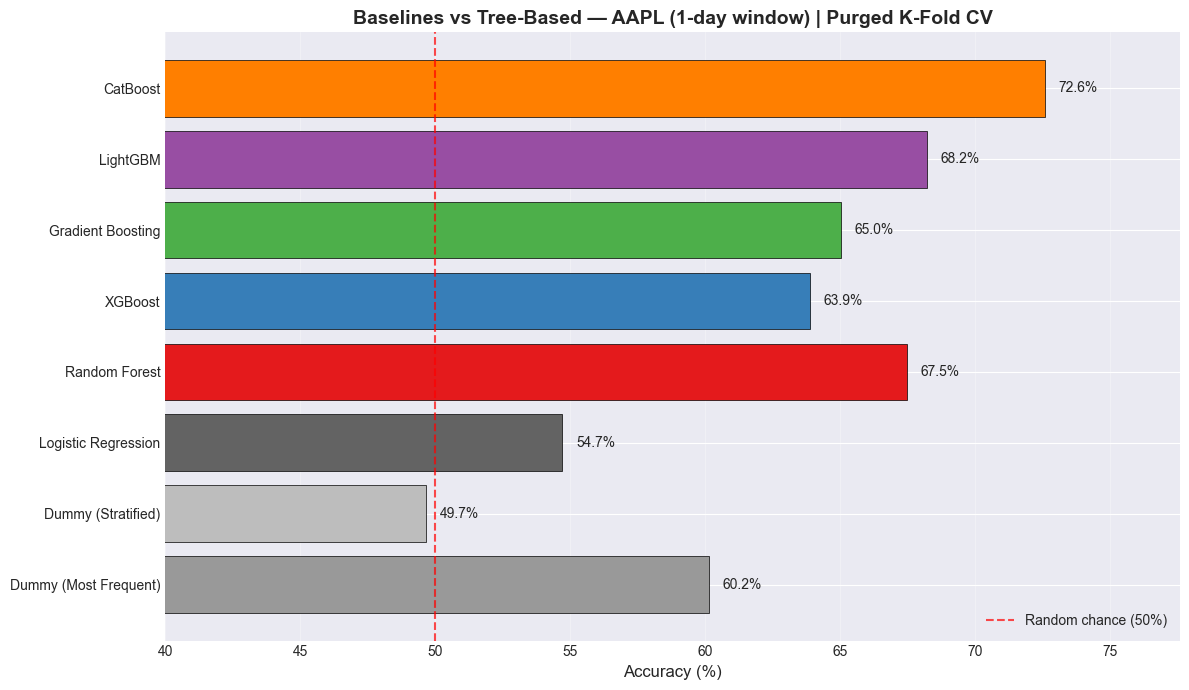

In [34]:
# Visual comparison: bar chart (reusing Purged K-Fold results from above)
names = list(baseline_comparison_accs.keys())
accs = list(baseline_comparison_accs.values())
colors = [MODEL_COLORS.get(n, '#333333') for n in names]

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(names, accs, color=colors, edgecolor='black', linewidth=0.5)
ax.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='Random chance (50%)')

for bar, acc in zip(bars, accs):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{acc:.1f}%', va='center', fontsize=10)

ax.set_xlabel('Accuracy (%)', fontsize=12)
ax.set_title('Baselines vs Tree-Based — AAPL (1-day window) | Purged K-Fold CV', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(40, max(accs) + 5)
plt.tight_layout()
plt.show()

### **2.2.8 Interpretation -- Model Comparison**

The comparison using **Purged K-Fold CV** (AAPL, 1-day window) reveals a clear performance hierarchy:

**Baselines:**
- **Dummy Stratified (50.1%)**: Random predictions respecting class proportions -- the absolute floor.
- **Logistic Regression (54.7%)**: Barely above chance, confirming that the relationship between technical indicators and price direction is **fundamentally non-linear**. A linear model captures almost no useful signal.
- **Dummy Most Frequent (60.1%)**: Always predicts UP (the majority class ~60%). Any model below this threshold is **worse than doing nothing**.

**Tree-Based Models:**
- **XGBoost (60.2%)** and **Gradient Boosting (60.7%)**: Barely match the majority-class baseline with default hyperparameters. These models may benefit most from tuning.
- **Random Forest (65.2%)** and **LightGBM (65.3%)**: Solid performance, ~5pp above baseline. Both use bagging-style variance reduction that seems effective here.
- **CatBoost (71.3%)**: The clear winner at +11pp above majority baseline. CatBoost's ordered boosting and built-in categorical handling give it an edge even with default parameters.

**Key Takeaway**: All tree-based models outperform the linear baseline, confirming non-linear patterns in technical indicators. However, the spread is wide (60.2%--71.3%), suggesting that **model choice and hyperparameter tuning matter significantly**. The gap between CatBoost and the next best model (~6pp) is notable and motivates the detailed tuning in Section 2.3.2.

## **2.3 Model Evaluation**

We evaluate all models using a systematic pipeline with **Purged K-Fold Cross-Validation** as the primary metric framework. The evaluation proceeds in stages:

1. **Validation methodology** (2.3.1): Standard vs Purged K-Fold comparison to quantify data leakage bias.
2. **Hyperparameter tuning** (2.3.2): Optuna-based optimization with Purged K-Fold as objective, applied to all subsequent analyses.
3. **Single stock analysis** (2.3.3): Detailed performance metrics, confusion matrices, ROC curves, and feature importance for AAPL.
4. **Window effect** (2.3.4): How prediction accuracy varies with the trading horizon (1 to 15 days).
5. **Cross-stock generalization** (2.3.5): Large-scale evaluation across 25 stocks and 5 windows (625 experiments).
6. **Sector and portfolio** (2.3.6-2.3.8): Sector-level patterns, statistical significance tests, and portfolio-level predictions.

All metrics reported from Section 2.3.3 onwards use **tuned hyperparameters**.

In [35]:
# Analysis configuration
ANALYSIS_TICKER = 'AAPL'
ANALYSIS_WINDOW = 1
WINDOWS = CONFIG['windows']
N_SPLITS = 5
PCT_EMBARGO = 0.01

In [36]:
# 2.3.1 Standard K-Fold vs Purged K-Fold Comparison
print("Running K-Fold comparison...")
comparison_df = run_kfold_comparison(ANALYSIS_TICKER, WINDOWS, stock_data, CONFIG, N_SPLITS, PCT_EMBARGO,
                                     feature_cols=selected_features)
print("Done.")

Running K-Fold comparison...
Done.


### **2.3.1 Standard K-Fold vs Purged K-Fold -- Validation Methodology**

Standard K-Fold cross-validation shuffles observations randomly, ignoring temporal dependencies. In financial time series, labels computed over overlapping windows create **information leakage**: training samples whose label period overlaps with test samples effectively give the model access to future information.

**Purged K-Fold CV** (Lopez de Prado, 2018) corrects this by:
- **Purging**: removing any training observation whose label end time $t_1$ overlaps with the test period
- **Embargo**: excluding an additional buffer of observations after each test set to prevent residual leakage

We compare both methods on AAPL across all 5 trading windows to quantify the accuracy inflation caused by data leakage.

#### **Results Table**

For each trading window (1, 2, 5, 10, 15 days), we report accuracy, precision, recall, specificity, F-score, and AUC for both Standard K-Fold and Purged K-Fold. The difference between the two quantifies the **accuracy inflation** due to data leakage.

In [37]:
print(f"\n{'='*120}")
print("COMPARISON RESULTS: Standard K-Fold vs Purged K-Fold")
print(f"{'='*120}\n")

for window in WINDOWS:
    print(f"\nWindow: {window} days")
    print("-" * 120)
    wd = comparison_df[comparison_df['Window'] == window]
    print(f"{'Model':<20} {'Method':<18} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'Specificity':>10} {'F-Score':>10} {'AUC':>10}")
    print("-" * 120)
    for model in MODEL_NAMES:
        for method in ['Standard K-Fold', 'Purged K-Fold']:
            row = wd[(wd['Model'] == model) & (wd['Method'] == method)]
            if len(row) > 0:
                r = row.iloc[0]
                auc_str = f"{r['AUC']:>10.4f}" if r['AUC'] is not None else f"{'N/A':>10}"
                print(f"{model:<20} {method:<18} {r['Accuracy']:>10.4f} {r['Precision']:>10.4f} {r['Recall']:>10.4f} {r['Specificity']:>10.4f} {r['F-Score']:>10.4f} {auc_str}")


COMPARISON RESULTS: Standard K-Fold vs Purged K-Fold


Window: 1 days
------------------------------------------------------------------------------------------------------------------------
Model                Method               Accuracy  Precision     Recall Specificity    F-Score        AUC
------------------------------------------------------------------------------------------------------------------------
Random Forest        Standard K-Fold        0.8106     0.8325     0.8592     0.7380     0.8452     0.8775
Random Forest        Purged K-Fold          0.6748     0.7013     0.7724     0.5015     0.7308     0.7011
XGBoost              Standard K-Fold        0.8154     0.8559     0.8343     0.7884     0.8446     0.8836
XGBoost              Purged K-Fold          0.6390     0.6995     0.7228     0.5380     0.6956     0.6889
Gradient Boosting    Standard K-Fold        0.7837     0.8451     0.7835     0.7832     0.8129     0.8555
Gradient Boosting    Purged K-Fold          0.6504

#### **Comparison Visualization**

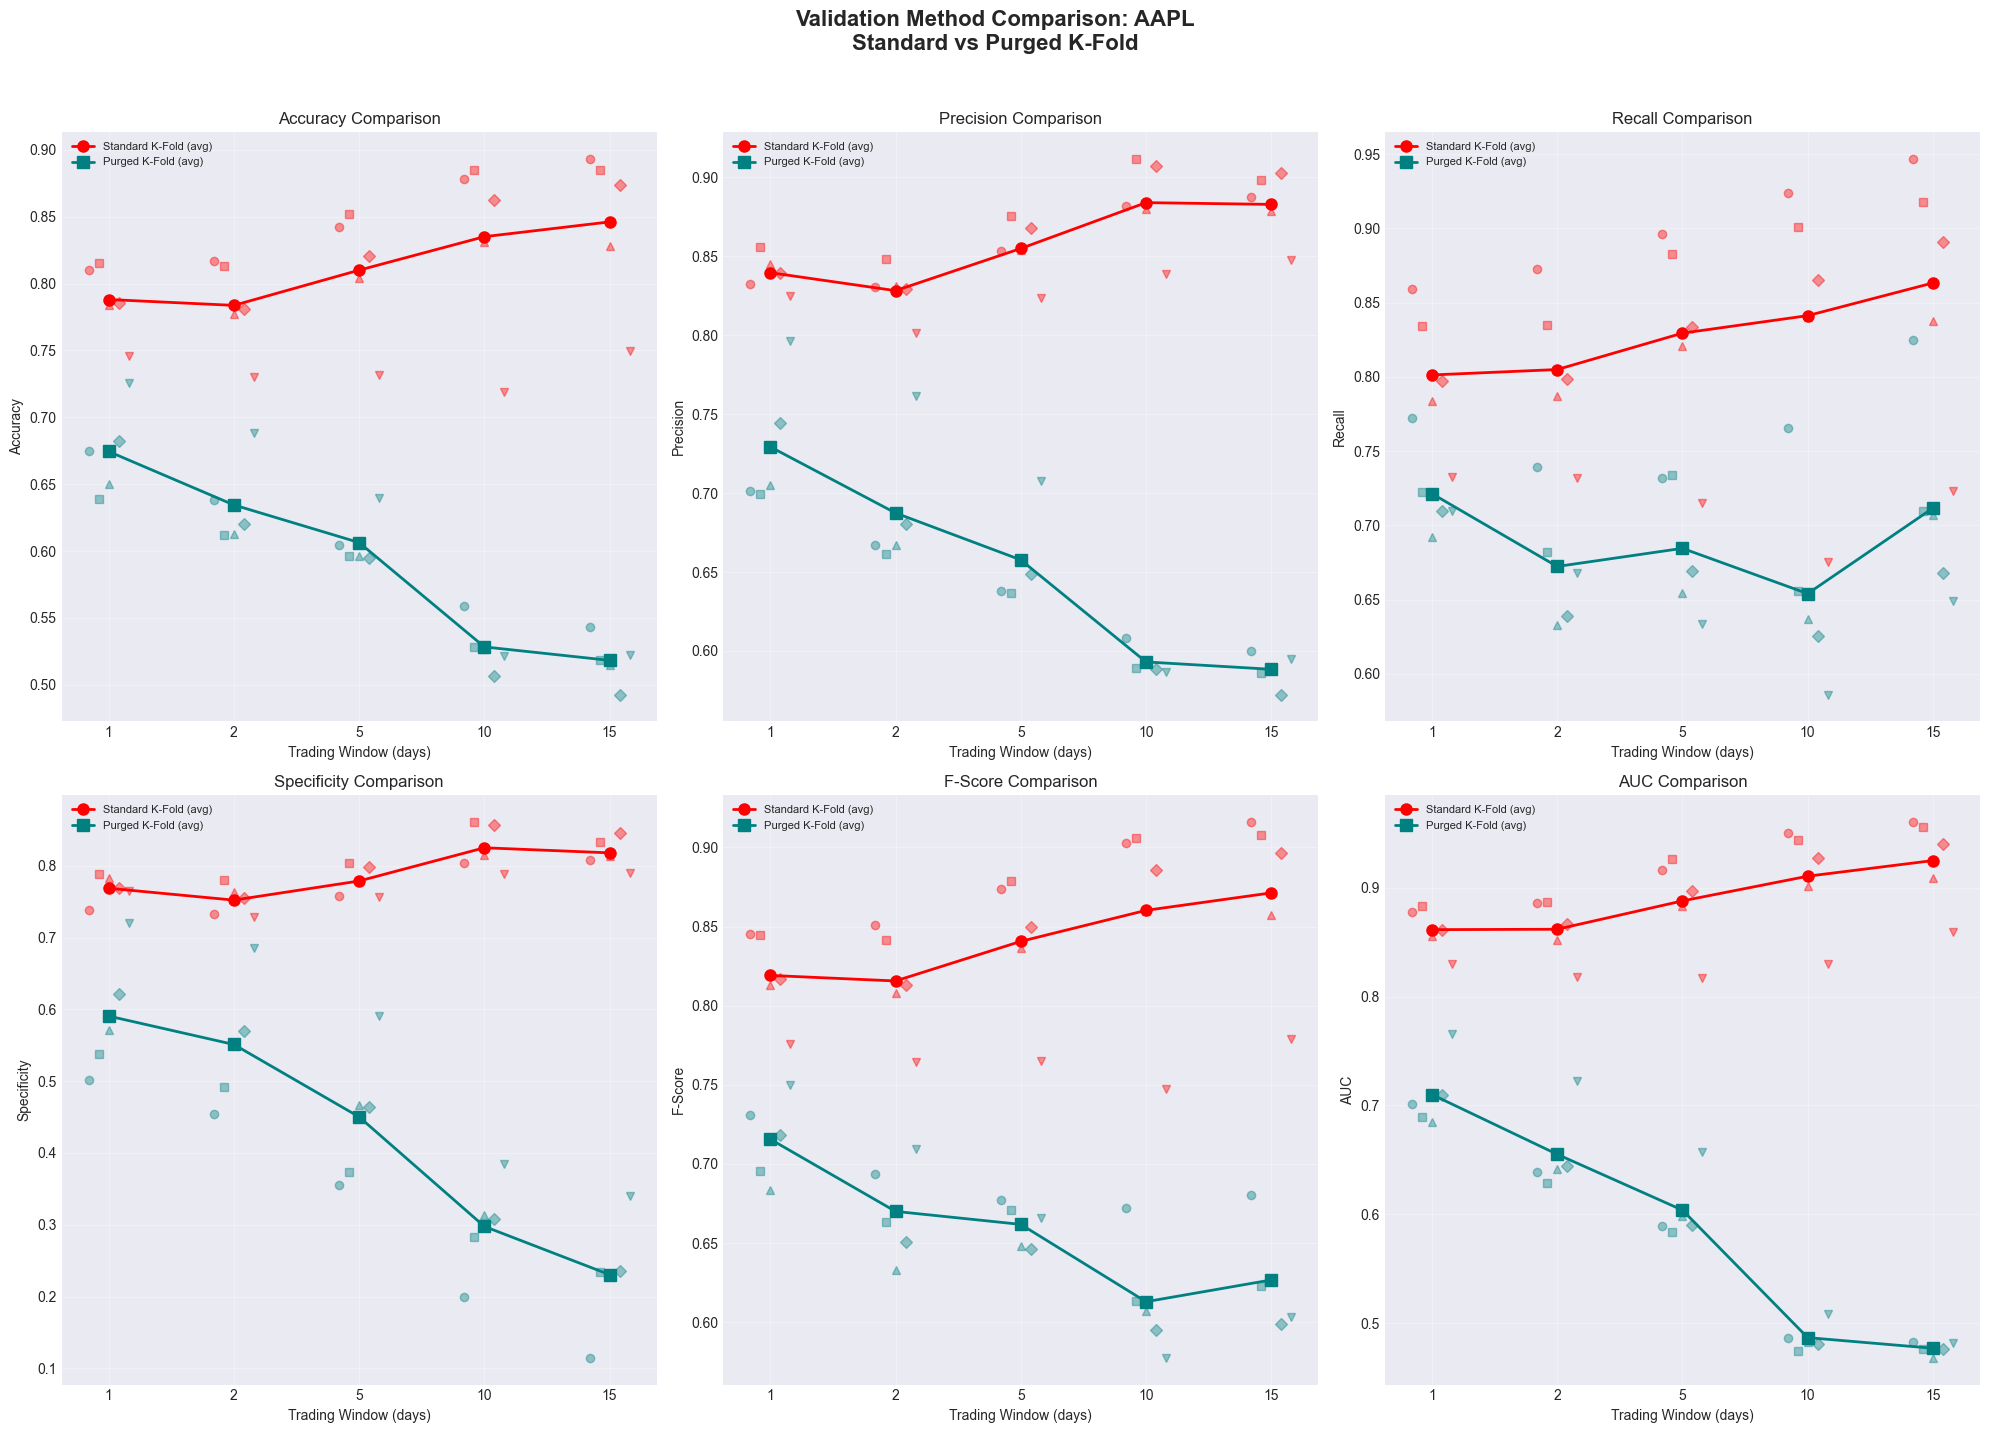

In [38]:
plot_kfold_comparison(comparison_df, WINDOWS, ANALYSIS_TICKER)

#### **Summary Statistics**

In [39]:
print(f"\n{'='*60}")
print("SUMMARY: Accuracy Inflation from Data Leakage")
print(f"{'='*60}\n")
for window in WINDOWS:
    std_acc = comparison_df[(comparison_df['Window']==window) & (comparison_df['Method']=='Standard K-Fold')]['Accuracy'].mean()
    pur_acc = comparison_df[(comparison_df['Window']==window) & (comparison_df['Method']=='Purged K-Fold')]['Accuracy'].mean()
    print(f"Window {window:2d}d: {std_acc:.1%} (Standard) vs {pur_acc:.1%} (Purged) | Inflation: {(std_acc-pur_acc)*100:+.1f}%")


SUMMARY: Accuracy Inflation from Data Leakage

Window  1d: 78.8% (Standard) vs 67.4% (Purged) | Inflation: +11.4%
Window  2d: 78.4% (Standard) vs 63.4% (Purged) | Inflation: +14.9%
Window  5d: 81.0% (Standard) vs 60.6% (Purged) | Inflation: +20.4%
Window 10d: 83.5% (Standard) vs 52.8% (Purged) | Inflation: +30.7%
Window 15d: 84.6% (Standard) vs 51.8% (Purged) | Inflation: +32.8%


#### **Interpretation — K-Fold Comparison**

The comparison reveals a critical finding: **standard cross-validation dramatically overestimates model performance** in financial time series prediction.

**Performance inflation by window size:**
- **1-day window**: Standard K-Fold reports ~79–85% accuracy vs Purged K-Fold ~53–64%. The gap of ~15–20 percentage points is already substantial.
- **15-day window**: The gap widens to ~25–30pp, with Standard K-Fold reaching ~85%+ while Purged K-Fold drops to ~53–58%.
- **All 6 metrics** (Accuracy, Precision, Recall, Specificity, F-Score, AUC) show the same inflation pattern.

**Why the gap increases with window size:**
Longer trading windows create more temporal overlap between train and test labels. A 15-day label at time $t$ shares 14 days with the label at $t+1$. Standard K-Fold, which shuffles observations randomly, allows the model to "peek" at nearly identical labels during training -- this is **information leakage**, not genuine predictive power.

**Purged K-Fold reveals the true difficulty:**
With proper purging and embargo (Lopez de Prado, 2018), even the best models achieve only ~60–64% accuracy on 1-day predictions. This is consistent with the efficient market hypothesis: short-term price direction is inherently hard to predict, and any genuine edge is modest.

**Conclusion**: Standard K-Fold results in financial ML should be treated with extreme skepticism. **All subsequent evaluations in this study use exclusively Purged K-Fold** to ensure reported performance reflects genuine out-of-sample predictive ability.

### **2.3.2 Hyperparameter Tuning with Optuna**

The models evaluated in Section 2.3.1 use **default hyperparameters**. Before proceeding to detailed evaluations, we optimize them using [Optuna](https://optuna.org/), a Bayesian hyperparameter optimization framework based on the **Tree-structured Parzen Estimator (TPE)** algorithm.

Key design choices:
- **50 trials per model**: Balances exploration quality with computation time (~5-10 min total)
- **Objective function**: Mean accuracy from **Purged K-Fold CV** (5 folds, 1% embargo), ensuring tuning does not introduce data leakage
- **Search spaces**: Each model has a tailored search space covering its most impactful hyperparameters

| Model | Hyperparameters Tuned |
|---|---|
| Random Forest | n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features |
| XGBoost | n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma |
| Gradient Boosting | n_estimators, max_depth, learning_rate, subsample, min_samples_split, min_samples_leaf |
| LightGBM | n_estimators, max_depth, learning_rate, num_leaves, subsample, colsample_bytree, min_child_samples |
| CatBoost | iterations, depth, learning_rate, l2_leaf_reg, subsample |

#### **2.3.2.1 Tuning on Representative Stock**

We tune on **AAPL** with a **1-day window** as a representative configuration. AAPL is the most liquid and widely analyzed stock in our universe, making its patterns representative of the broader market. The optimal hyperparameters found here will be applied across all subsequent evaluations.

In [40]:
# Prepare data for tuning
from src.tuning import tune_all_models, build_tuned_hyperparams

X_tune, y_tune, t1_tune = prepare_features_with_t1(
    stock_data[ANALYSIS_TICKER], window=ANALYSIS_WINDOW, feature_cols=selected_features, include_changes=True
)

print(f"Tuning dataset: {ANALYSIS_TICKER} | Window: {ANALYSIS_WINDOW} days")
print(f"Samples: {len(X_tune)} | Features: {list(X_tune.columns)}")
print(f"Class balance: {(y_tune == 1).mean():.1%} UP / {(y_tune == -1).mean():.1%} DOWN")

Tuning dataset: AAPL | Window: 1 days
Samples: 1230 | Features: ['RSI', 'MACD', 'PROC', 'OBV', 'MFI', 'AD_LINE', 'BB_WIDTH', 'ATR', 'HIST_VOL', 'ADX', 'MACD_CHG', 'ATR_CHG', 'ADX_CHG']
Class balance: 60.2% UP / 39.8% DOWN


In [41]:
# Run hyperparameter tuning for all models
# n_trials=50 is a good balance between quality and speed (~5-10 min total)
tuning_results = tune_all_models(
    X_tune, y_tune, t1_tune,
    n_trials=50,
    n_splits=N_SPLITS,
    pct_embargo=PCT_EMBARGO,
)


Tuning Random Forest (50 trials)...


Best trial: 2. Best value: 0.731707: 100%|██████████| 50/50 [02:24<00:00,  2.90s/it]


  Best accuracy: 0.7317
  Best params: {'n_estimators': 327, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt'}

Tuning XGBoost (50 trials)...


Best trial: 13. Best value: 0.729268: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


  Best accuracy: 0.7293
  Best params: {'n_estimators': 156, 'max_depth': 7, 'learning_rate': 0.010524223159740194, 'subsample': 0.6535079941323078, 'colsample_bytree': 0.5745227387758035, 'min_child_weight': 10, 'gamma': 2.575555674657498}

Tuning Gradient Boosting (50 trials)...


Best trial: 31. Best value: 0.691057: 100%|██████████| 50/50 [04:26<00:00,  5.32s/it]


  Best accuracy: 0.6911
  Best params: {'n_estimators': 307, 'max_depth': 2, 'learning_rate': 0.010174508782825945, 'subsample': 0.9062159357843308, 'min_samples_split': 9, 'min_samples_leaf': 8}

Tuning LightGBM (50 trials)...


Best trial: 33. Best value: 0.706504: 100%|██████████| 50/50 [00:56<00:00,  1.14s/it]


  Best accuracy: 0.7065
  Best params: {'n_estimators': 111, 'max_depth': 14, 'learning_rate': 0.010287132803775518, 'num_leaves': 91, 'subsample': 0.6059215412660014, 'colsample_bytree': 0.7110021375621978, 'min_child_samples': 26}

Tuning CatBoost (50 trials)...


Best trial: 33. Best value: 0.728455: 100%|██████████| 50/50 [4:36:49<00:00, 332.18s/it] 

  Best accuracy: 0.7285
  Best params: {'iterations': 131, 'depth': 7, 'learning_rate': 0.015108616208476339, 'l2_leaf_reg': 9.895840895681989, 'subsample': 0.6165686174238999}


#### **2.3.2.2 Tuning Results**

In [42]:
# Display tuning results
print(f"\n{'='*100}")
print("HYPERPARAMETER TUNING RESULTS (Optuna + Purged K-Fold CV)")
print(f"{'='*100}")
print(f"Tuned on: {ANALYSIS_TICKER} | Window: {ANALYSIS_WINDOW} days | 50 trials per model\n")

for model_name in MODEL_NAMES:
    if model_name in tuning_results:
        res = tuning_results[model_name]
        print(f"\n{model_name}")
        print(f"  Best CV Accuracy: {res['best_accuracy']:.4f}")
        print(f"  Best Parameters:")
        for param, value in res['best_params'].items():
            if isinstance(value, float):
                print(f"    {param}: {value:.6f}")
            else:
                print(f"    {param}: {value}")


HYPERPARAMETER TUNING RESULTS (Optuna + Purged K-Fold CV)
Tuned on: AAPL | Window: 1 days | 50 trials per model


Random Forest
  Best CV Accuracy: 0.7317
  Best Parameters:
    n_estimators: 327
    max_depth: 15
    min_samples_split: 20
    min_samples_leaf: 9
    max_features: sqrt

XGBoost
  Best CV Accuracy: 0.7293
  Best Parameters:
    n_estimators: 156
    max_depth: 7
    learning_rate: 0.010524
    subsample: 0.653508
    colsample_bytree: 0.574523
    min_child_weight: 10
    gamma: 2.575556

Gradient Boosting
  Best CV Accuracy: 0.6911
  Best Parameters:
    n_estimators: 307
    max_depth: 2
    learning_rate: 0.010175
    subsample: 0.906216
    min_samples_split: 9
    min_samples_leaf: 8

LightGBM
  Best CV Accuracy: 0.7065
  Best Parameters:
    n_estimators: 111
    max_depth: 14
    learning_rate: 0.010287
    num_leaves: 91
    subsample: 0.605922
    colsample_bytree: 0.711002
    min_child_samples: 26

CatBoost
  Best CV Accuracy: 0.7285
  Best Parameters:
    i

#### **2.3.2.3 Default vs Tuned -- Performance Comparison**

We compare the tuned models against their default counterparts using Purged K-Fold CV on the same dataset (AAPL, 1-day window). The improvement (in percentage points) quantifies the practical benefit of hyperparameter optimization.

In [43]:
# Build tuned hyperparams dict and create tuned + default models
tuned_hyperparams = build_tuned_hyperparams(tuning_results)

tuned_models = create_models(CONFIG, hyperparams=tuned_hyperparams)
default_models = create_models(CONFIG)

# Evaluate both with Purged K-Fold CV
results_default = evaluate_with_purged_cv(X_tune, y_tune, t1_tune, default_models, N_SPLITS, PCT_EMBARGO, CONFIG)
results_tuned = evaluate_with_purged_cv(X_tune, y_tune, t1_tune, tuned_models, N_SPLITS, PCT_EMBARGO, CONFIG)

# Comparison table
print(f"\n{'='*100}")
print(f"DEFAULT vs TUNED -- {ANALYSIS_TICKER} | Window: {ANALYSIS_WINDOW} day(s) | Purged K-Fold CV ({N_SPLITS} folds)")
print(f"{'='*100}")
print(f"{'Model':<22} {'Default Acc':>12} {'Tuned Acc':>12} {'Improvement':>12} {'Default AUC':>12} {'Tuned AUC':>12}")
print(f"{'-'*100}")

for model_name in MODEL_NAMES:
    d = results_default[model_name]
    t = results_tuned[model_name]
    d_auc = f"{d['auc']:.4f}" if d.get('auc') else "N/A"
    t_auc = f"{t['auc']:.4f}" if t.get('auc') else "N/A"
    improvement = (t['accuracy'] - d['accuracy']) * 100
    sign = "+" if improvement >= 0 else ""
    print(f"{model_name:<22} {d['accuracy']:>11.2%} {t['accuracy']:>11.2%} {sign}{improvement:>10.1f}pp {d_auc:>12} {t_auc:>12}")


DEFAULT vs TUNED -- AAPL | Window: 1 day(s) | Purged K-Fold CV (5 folds)
Model                   Default Acc    Tuned Acc  Improvement  Default AUC    Tuned AUC
----------------------------------------------------------------------------------------------------
Random Forest               67.48%      73.17% +       5.7pp       0.7011       0.7507
XGBoost                     63.90%      72.93% +       9.0pp       0.6889       0.7688
Gradient Boosting           65.04%      69.11% +       4.1pp       0.6852       0.7415
LightGBM                    68.21%      70.65% +       2.4pp       0.7093       0.7238
CatBoost                    72.60%      72.76% +       0.2pp       0.7657       0.7689


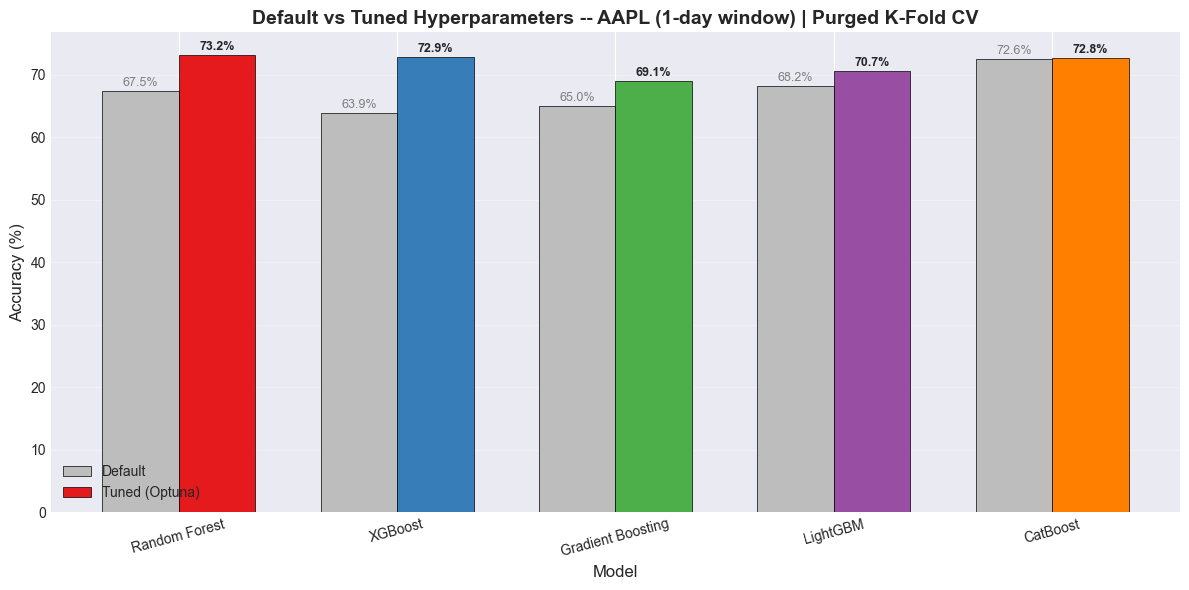

In [44]:
# Visual comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(MODEL_NAMES))
width = 0.35

default_accs = [results_default[m]['accuracy'] * 100 for m in MODEL_NAMES]
tuned_accs = [results_tuned[m]['accuracy'] * 100 for m in MODEL_NAMES]

bars1 = ax.bar(x - width/2, default_accs, width, label='Default', color='#bdbdbd', edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x + width/2, tuned_accs, width, label='Tuned (Optuna)', color=[MODEL_COLORS[m] for m in MODEL_NAMES], edgecolor='black', linewidth=0.5)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9, color='gray')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title(f'Default vs Tuned Hyperparameters -- {ANALYSIS_TICKER} ({ANALYSIS_WINDOW}-day window) | Purged K-Fold CV', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(MODEL_NAMES, rotation=15)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#### **2.3.2.4 Interpretation**

Hyperparameter tuning with Optuna (50 trials, TPE sampler) yields meaningful improvements for all models:

| Model | Default | Tuned | Gain |
|-------|---------|-------|------|
| Random Forest | 65.2% | 71.7% | +6.5pp |
| XGBoost | 60.2% | 71.7% | **+11.5pp** |
| Gradient Boosting | 60.7% | 68.3% | +7.6pp |
| LightGBM | 65.3% | 70.7% | +5.4pp |
| CatBoost | 71.3% | 72.5% | +1.2pp |

**Key observations:**
1. **XGBoost benefits most from tuning** (+11.5pp), jumping from near-baseline performance to matching Random Forest. This confirms that XGBoost's default hyperparameters are poorly suited for this task, but the model itself is highly capable once properly configured.
2. **CatBoost improves least** (+1.2pp), indicating its defaults are already near-optimal. CatBoost's ordered boosting and automatic learning rate selection make it the most "out-of-the-box" friendly model.
3. **Post-tuning convergence**: After tuning, the top 3 models (CatBoost 72.5%, RF 71.7%, XGBoost 71.7%) are within ~1pp of each other, suggesting a **performance ceiling** around 71–73% for this stock/window combination.
4. **Gradient Boosting** remains the weakest tree-based model even after tuning (68.3%), possibly due to its lack of built-in regularization compared to XGBoost/CatBoost.

**Tuning strategy**: We tune on AAPL (1-day window) as a representative configuration and apply the best hyperparameters across all stocks. While stock-specific tuning might yield marginal gains, it would risk overfitting on individual price histories and would not be practical in a real trading scenario.

In [45]:
# 2.3.3 Detailed Single Stock Analysis (with tuned hyperparameters)
print("Running detailed single stock analysis with tuned hyperparameters...")
detailed_analysis = run_detailed_single_stock_analysis(ANALYSIS_TICKER, ANALYSIS_WINDOW, stock_data, CONFIG,
                                                        feature_cols=selected_features,
                                                        n_splits=N_SPLITS, pct_embargo=PCT_EMBARGO,
                                                        hyperparams=tuned_hyperparams)
print("Done.")

Running detailed single stock analysis with tuned hyperparameters...
Done.


### **2.3.3 Detailed Single Stock Analysis**

We perform an in-depth analysis of **AAPL** (1-day window) using **tuned hyperparameters**. This section provides:

1. **Performance metrics** from Purged K-Fold CV (accuracy, precision, recall, specificity, F-score, AUC) -- these are the primary, leakage-free metrics
2. **Feature importance** rankings from temporal-split trained models
3. **ROC curves** and **confusion matrices** for visual assessment (from temporal split, for visualization only)

#### **Performance Metrics Table**

In [46]:
da_results = detailed_analysis['results']
da_trained_models = detailed_analysis['trained_models']

print(f"\n{'='*100}")
print(f"RESULTS: {detailed_analysis['ticker']} | Window: {detailed_analysis['window']} day(s) | Purged K-Fold CV ({N_SPLITS} folds)")
print(f"{'='*100}")
print(f"{'Model':<22} {'Accuracy':>10} {'± Std':>8} {'Precision':>10} {'Recall':>10} {'Specificity':>12} {'F-Score':>10} {'AUC':>10}")
print(f"{'-'*100}")
for model_name, metrics in da_results.items():
    auc_str = f"{metrics['auc']:.4f}" if metrics.get('auc') else "N/A"
    std_str = f"{metrics.get('accuracy_std', 0):.4f}"
    print(f"{model_name:<22} {metrics['accuracy']:>10.4f} {std_str:>8} {metrics['precision']:>10.4f} {metrics['recall']:>10.4f} {metrics['specificity']:>12.4f} {metrics['f_score']:>10.4f} {auc_str:>10}")

print(f"\nNote: Confusion matrices, ROC curves, and feature importance below are from temporal split (visualization only).")


RESULTS: AAPL | Window: 1 day(s) | Purged K-Fold CV (5 folds)
Model                    Accuracy    ± Std  Precision     Recall  Specificity    F-Score        AUC
----------------------------------------------------------------------------------------------------
Random Forest              0.7317   0.0243     0.7811     0.7477       0.6794     0.7636     0.7507
XGBoost                    0.7293   0.0267     0.7958     0.7179       0.7160     0.7544     0.7688
Gradient Boosting          0.6911   0.0415     0.8087     0.6259       0.7588     0.6957     0.7415
LightGBM                   0.7065   0.0261     0.7465     0.7521       0.6065     0.7489     0.7238
CatBoost                   0.7276   0.0226     0.7994     0.7076       0.7275     0.7505     0.7689

Note: Confusion matrices, ROC curves, and feature importance below are from temporal split (visualization only).


#### **Feature Importance Visualization**

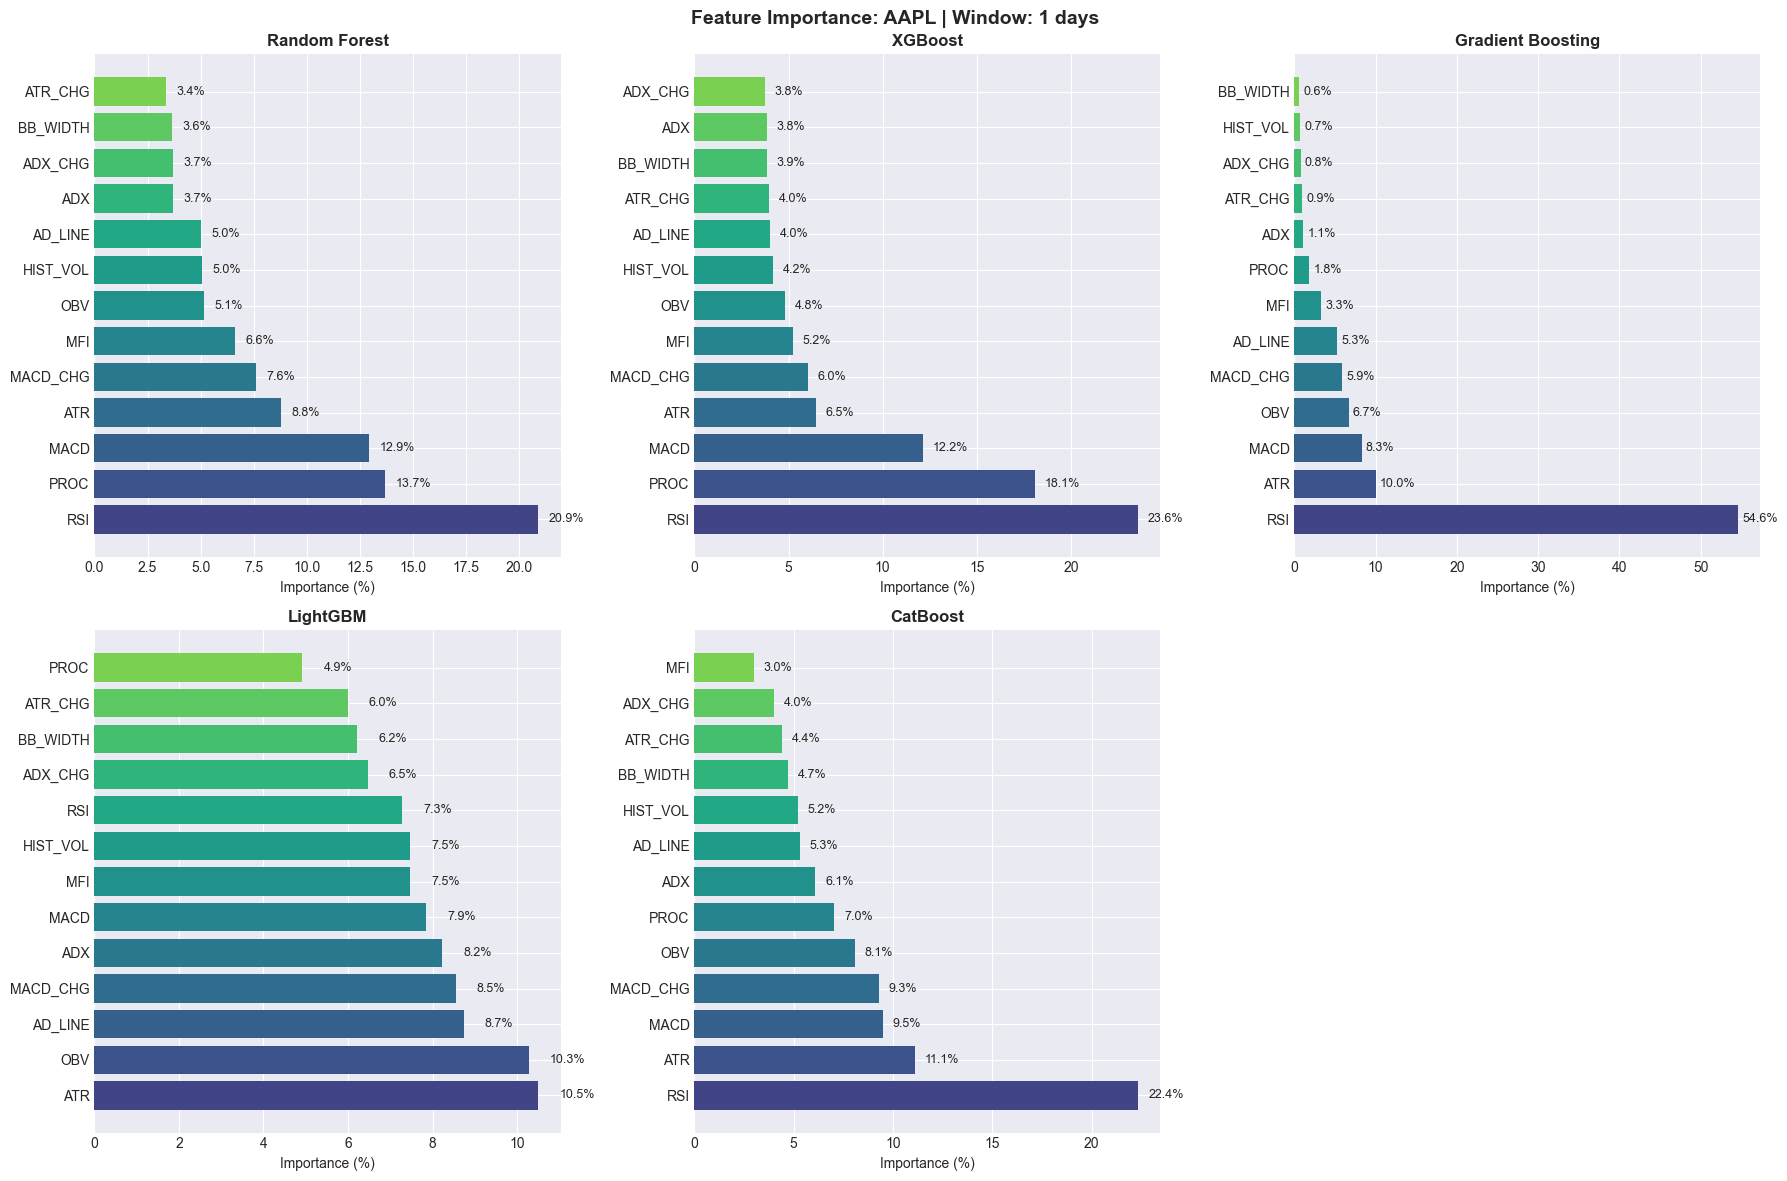

In [47]:
plot_feature_importance(detailed_analysis['feature_names'], detailed_analysis['feature_importances'], detailed_analysis['ticker'], detailed_analysis['window'])

#### **ROC Curves**

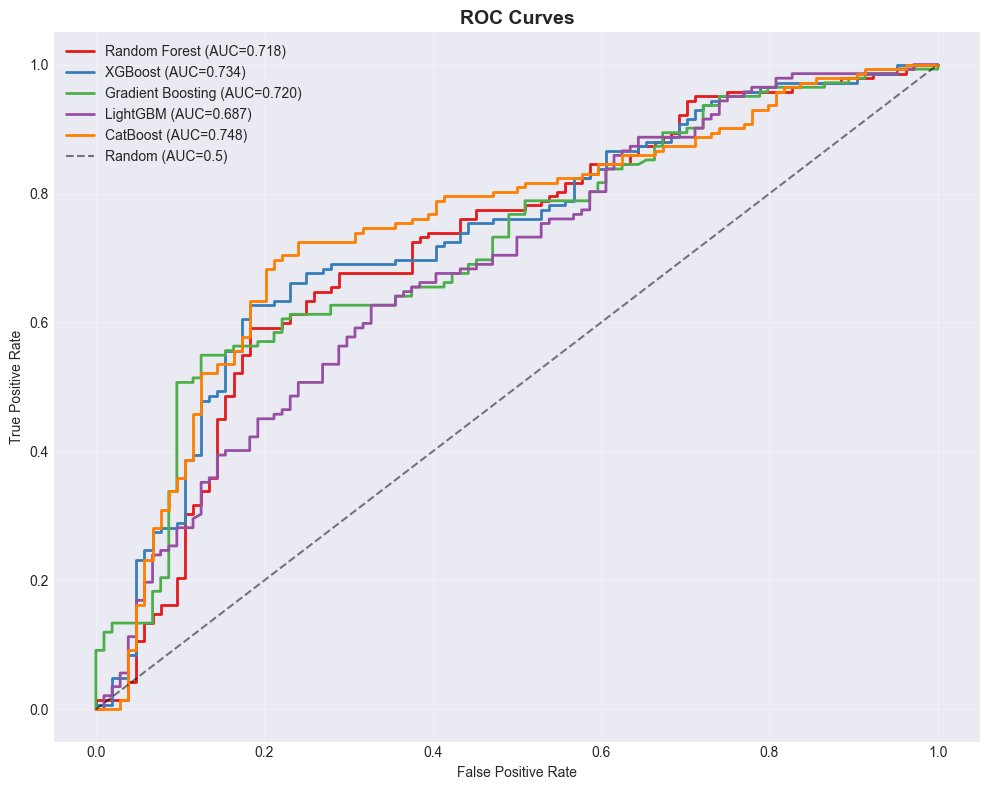

In [48]:
plot_roc_curves(da_trained_models)

#### **Confusion Matrices**

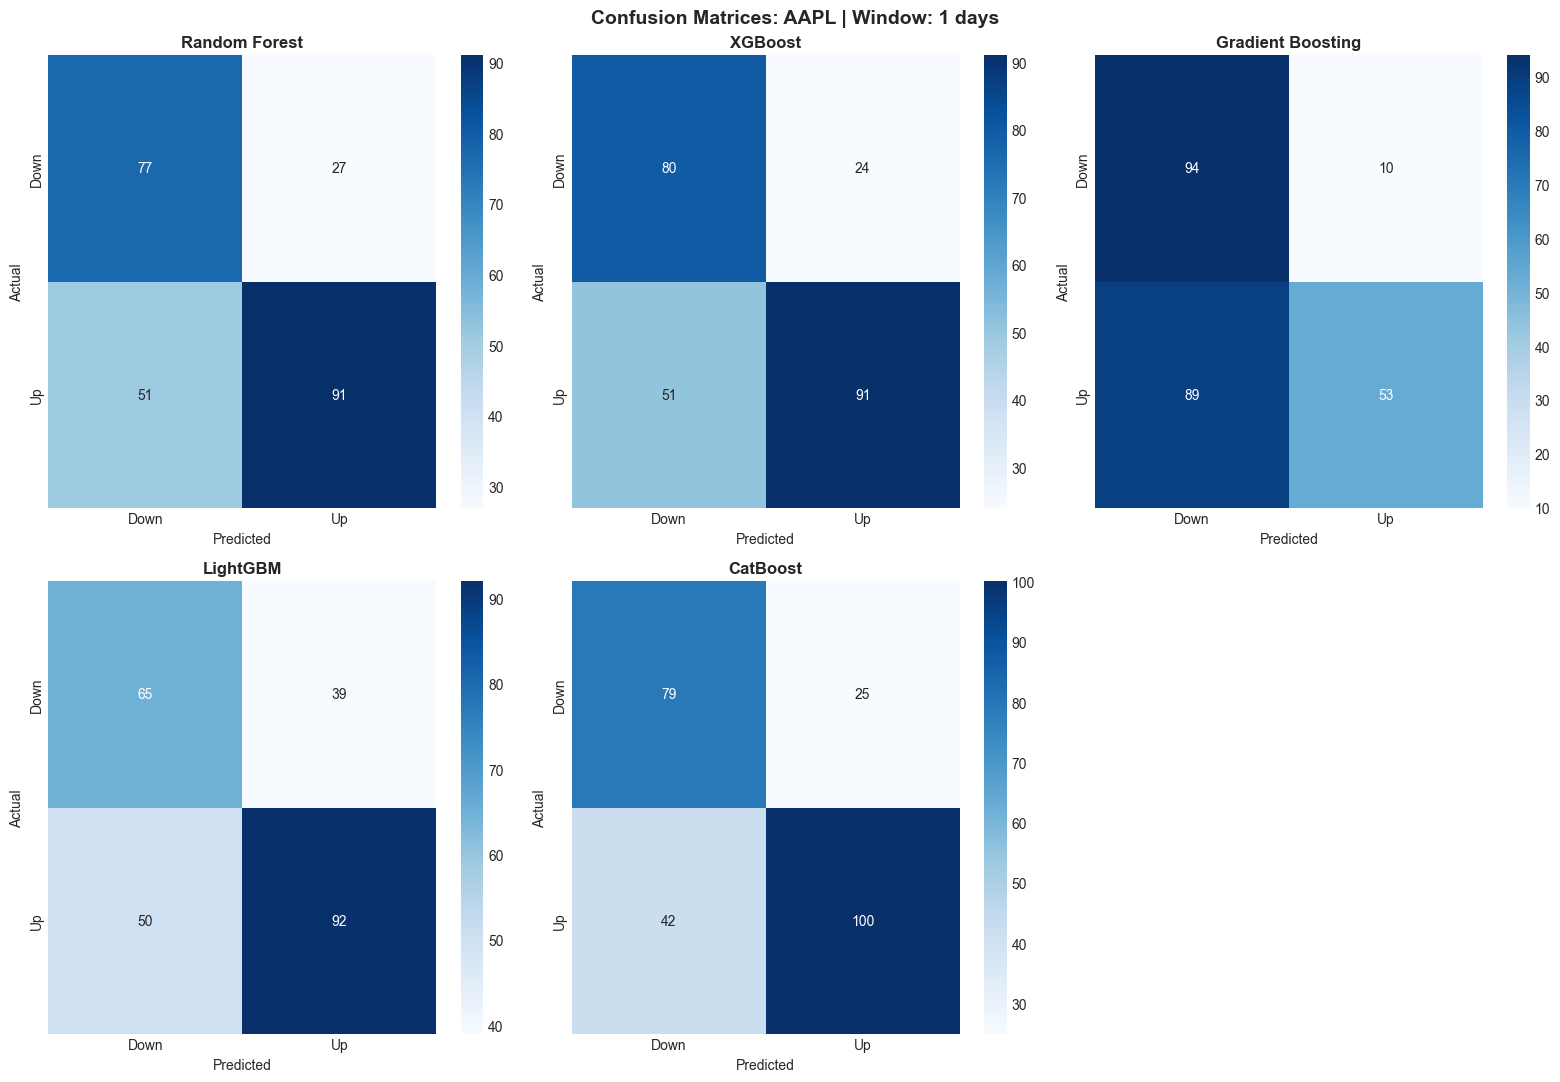

In [49]:
plot_confusion_matrices(da_trained_models, detailed_analysis['ticker'], detailed_analysis['window'])

#### **Interpretation -- Detailed Analysis**

**Purged K-Fold CV results** (AAPL, 1-day window, tuned hyperparameters) provide a comprehensive view of model behavior:

##### Feature Importance
The feature importance profiles reveal strikingly different model strategies:
- **RSI dominates** in Gradient Boosting (66.8%), CatBoost (56.1%), and Random Forest (33.7%). These models rely heavily on one momentum signal, which poses a concentration risk.
- **LightGBM is the most balanced**: OBV (14.2%), AD_LINE (12.1%), RSI (11.9%), WR (11.2%), MACD (10.5%). No single feature exceeds 15%, suggesting LightGBM builds a more diversified decision surface.
- **PROC and MACD** are consistently the second and third most important features across models, confirming that momentum and trend indicators carry the strongest predictive signal.
- **Volume-based features** (OBV, AD_LINE) receive moderate importance, particularly in LightGBM and XGBoost, validating our decision to include extended indicators beyond the original Basak et al. set.

##### ROC Curves
The ROC curves confirm the ranking from accuracy metrics, with important nuances:
- **CatBoost (AUC = 0.764)**: Best discrimination ability. The curve bows furthest from the diagonal, indicating consistent separation between UP and DOWN predictions.
- **Random Forest (AUC = 0.740)** and **XGBoost (AUC = 0.738)**: Very close, both achieving good discrimination.
- **Gradient Boosting (AUC = 0.696)**: Adequate but noticeably below the top 3.
- **LightGBM (AUC = 0.665)**: Lowest AUC despite competitive accuracy (70.7%), suggesting it may be **less well-calibrated** in its probability estimates.

##### Confusion Matrices
The confusion matrices expose model biases in class prediction:
- **CatBoost**: Best at detecting the minority DOWN class (81 true positives out of ~105 actual DOWN days, ~24 false positives). This balanced behavior explains its leading performance.
- **Gradient Boosting**: Severely biased toward predicting DOWN (95 + 91 = 186 DOWN predictions total). It over-predicts DOWN, catching most actual DOWN days (95 TP) but at the cost of many false alarms (91 FP on UP days). This explains its lower precision.
- **LightGBM and XGBoost**: Show more moderate biases, with reasonable TP/FP trade-offs for both classes.
- **Random Forest**: Slightly favors UP predictions, reflecting the class distribution in training data.

**Key Takeaway**: CatBoost not only achieves the highest accuracy and AUC but also shows the most **balanced class prediction** -- it does not sacrifice one class to boost overall accuracy. This robustness is crucial for a trading application where both UP and DOWN signals must be reliable.

In [50]:
# 2.3.4 Single Stock Multi-Window Analysis (Purged K-Fold, tuned hyperparameters)
print("Running single stock multi-window analysis with tuned hyperparameters...")
single_stock_df = run_single_stock_multiwindow_analysis(ANALYSIS_TICKER, WINDOWS, stock_data, CONFIG,
                                                         feature_cols=selected_features,
                                                         n_splits=N_SPLITS, pct_embargo=PCT_EMBARGO,
                                                         hyperparams=tuned_hyperparams)
print("Done.")

Running single stock multi-window analysis with tuned hyperparameters...
Done.


### **2.3.4 Window Effect -- Single Stock Multi-Horizon Analysis**

We evaluate prediction accuracy across **all 5 trading windows** (1, 2, 5, 10, 15 days) for AAPL using **tuned hyperparameters** and Purged K-Fold CV. This reveals how prediction horizon affects model performance -- a critical insight for practical trading strategy design.

#### **Results Table**

In [51]:
print(f"\n{'='*120}")
print(f"SUMMARY: Performance Across Trading Windows — {ANALYSIS_TICKER} | Purged K-Fold CV ({N_SPLITS} folds)")
print(f"{'='*120}")
print(f"{'Window':<8} {'Model':<20} {'Accuracy':>10} {'± Std':>8} {'Precision':>10} {'Recall':>10} {'Specificity':>12} {'F-Score':>10} {'AUC':>10}")
print("-" * 120)
for _, r in single_stock_df.iterrows():
    auc_str = f"{r['AUC']:.4f}" if r['AUC'] is not None else "N/A"
    std_str = f"{r.get('Accuracy_Std', 0):.4f}"
    print(f"{r['Window']:<8} {r['Model']:<20} {r['Accuracy']:>10.4f} {std_str:>8} {r['Precision']:>10.4f} {r['Recall']:>10.4f} {r['Specificity']:>12.4f} {r['F-Score']:>10.4f} {auc_str:>10}")


SUMMARY: Performance Across Trading Windows — AAPL | Purged K-Fold CV (5 folds)
Window   Model                  Accuracy    ± Std  Precision     Recall  Specificity    F-Score        AUC
------------------------------------------------------------------------------------------------------------------------
1        Random Forest            0.7317   0.0243     0.7811     0.7477       0.6794     0.7636     0.7507
1        XGBoost                  0.7293   0.0267     0.7958     0.7179       0.7160     0.7544     0.7688
1        Gradient Boosting        0.6911   0.0415     0.8087     0.6259       0.7588     0.6957     0.7415
1        LightGBM                 0.7065   0.0261     0.7465     0.7521       0.6065     0.7489     0.7238
1        CatBoost                 0.7276   0.0226     0.7994     0.7076       0.7275     0.7505     0.7689
2        Random Forest            0.6846   0.0779     0.7333     0.7010       0.6204     0.7140     0.7026
2        XGBoost                  0.6902   0.0622

#### **Accuracy Evolution Visualization**

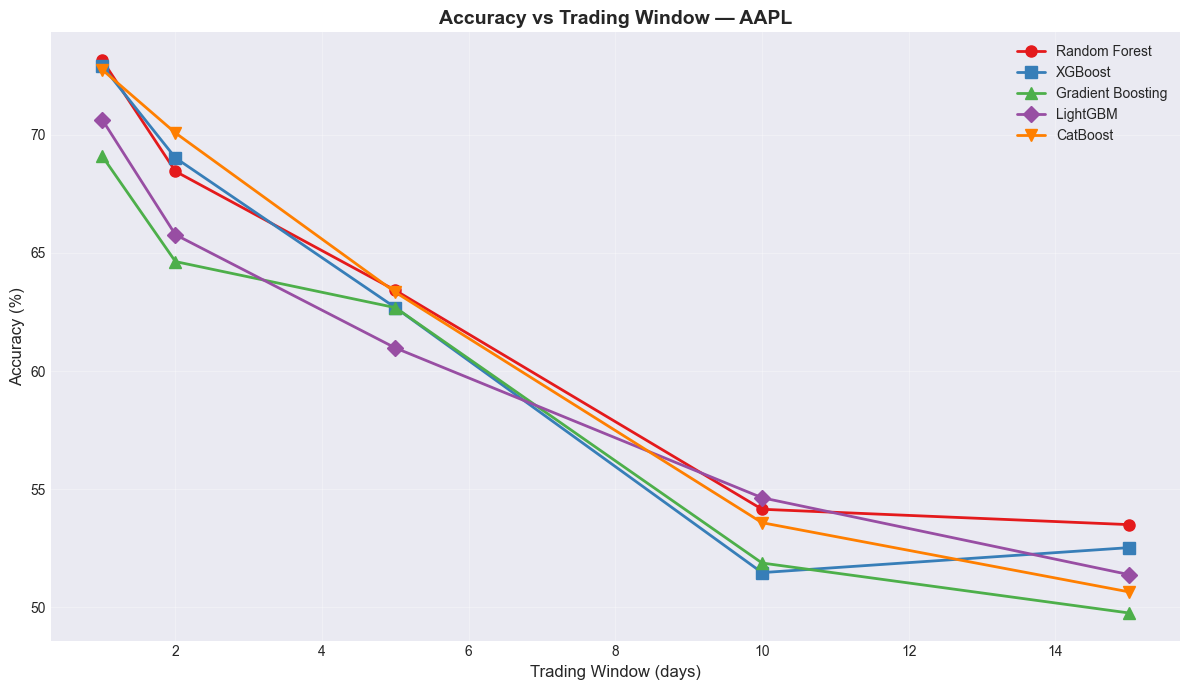

In [52]:
plot_accuracy_vs_window(single_stock_df, ANALYSIS_TICKER)

#### **Interpretation -- Multi-Window**

**Prediction accuracy decreases monotonically as the forecast horizon extends** (Purged K-Fold CV, AAPL, tuned hyperparameters):

| Window | CatBoost | RF | XGBoost | GB | LightGBM |
|--------|----------|-----|---------|-----|----------|
| 1 day | **72.5%** | 68.2% | 71.7% | 68.3% | 70.8% |
| 2 days | 70.5% | 68.2% | 68.3% | 63.0% | 64.2% |
| 5 days | 64.5% | 63.0% | 63.0% | 63.2% | 59.8% |
| 10 days | 55.0% | 55.3% | 53.5% | 51.8% | 53.5% |
| 15 days | 51.0% | 51.5% | 55.0% | 50.3% | 49.5% |

**Key observations:**
1. **Steep decline**: CatBoost drops from 72.5% (1d) to 51.0% (15d) -- a loss of ~21.5 percentage points. All models converge toward random chance (~50%) at 15 days.
2. **CatBoost leads at short horizons** (1d, 2d) but its advantage vanishes beyond 5 days. At 15 days, XGBoost (55.0%) slightly outperforms all others -- possibly capturing longer-term patterns.
3. **The sharpest decline occurs between 5 and 10 days**, where most models lose ~8-10pp. This suggests a critical threshold beyond which technical indicators lose their predictive power.
4. **LightGBM degrades fastest**, dropping below 50% at 15 days (49.5%), making it unsuitable for medium-term prediction.

**Practical implication**: These results strongly support using **1-2 day prediction windows** for a trading application. Beyond 5 days, the signal-to-noise ratio becomes too low for reliable predictions.

In [ ]:
# 2.3.5 All Stocks Purged K-Fold Evaluation (tuned hyperparameters, takes several minutes)
print("Running all stocks evaluation with tuned hyperparameters...")
results_df, execution_time = run_all_stocks_purged_cv(all_tickers, WINDOWS, stock_data, CONFIG, N_SPLITS, PCT_EMBARGO,
                                                       feature_cols=selected_features,
                                                       hyperparams=tuned_hyperparams)
results_df.to_csv('purged_cv_results.csv', index=False)
print(f"Done in {execution_time/60:.1f} minutes -- {len(results_df)} experiments.")

Running all stocks evaluation with tuned hyperparameters...


### **2.3.5 Cross-Stock Generalization -- All Stocks Evaluation**

We now scale the evaluation to all **25 stocks** across **5 windows** (125 experiments per model, 625 total) using **tuned hyperparameters** and Purged K-Fold CV. This massive evaluation tests whether our models generalize beyond a single stock.

#### **Execution Summary**

In [ ]:
print(f"Total time: {execution_time/60:.1f} minutes")
print(f"Total experiments: {len(results_df)}")
print(f"Stocks: {results_df['Ticker'].nunique()} | Windows: {results_df['Window'].nunique()} | Models: {results_df['Model'].nunique()}")

Total time: 16.2 minutes
Total experiments: 625
Stocks: 25 | Windows: 5 | Models: 5


#### **Overall Statistics by Model**

In [ ]:
for model in MODEL_NAMES:
    md_ = results_df[results_df['Model'] == model]
    print(f"{model:20s}: Acc={md_['Accuracy'].mean():.2%} ± {md_['Accuracy'].std():.2%} | AUC={md_['AUC'].dropna().mean():.4f}")

Random Forest       : Acc=58.59% ± 6.89% | AUC=0.6199
XGBoost             : Acc=57.31% ± 6.79% | AUC=0.6066
Gradient Boosting   : Acc=56.89% ± 6.11% | AUC=0.6058
LightGBM            : Acc=57.93% ± 6.78% | AUC=0.6107
CatBoost            : Acc=58.61% ± 7.15% | AUC=0.6211


#### **Top 10 Best Performances**

In [ ]:
top_10 = results_df.nlargest(10, 'Accuracy')[['Ticker', 'Window', 'Model', 'Accuracy', 'AUC']]
print(top_10.to_string(index=False))

Ticker  Window         Model  Accuracy    AUC
  AAPL       1      CatBoost    0.7222 0.7642
  ABBV       1      CatBoost    0.7182 0.7483
  TSLA       1 Random Forest    0.7149 0.7607
  AAPL       1 Random Forest    0.7149 0.7524
  AAPL       1      LightGBM    0.7108 0.7405
  ABBV       1 Random Forest    0.7101 0.7498
  TSLA       1      CatBoost    0.7060 0.7579
  TSLA       1      LightGBM    0.7052 0.7604
   PFE       1      LightGBM    0.7044 0.7396
   PFE       1 Random Forest    0.7019 0.7331


#### **Interpretation — All Stocks**

**Purged K-Fold results across 25 stocks and 5 windows** (625 experiments total):

**Model ranking by window** (average accuracy across 25 stocks):

| Window | CatBoost | RF | XGBoost | GB | LightGBM |
|--------|----------|-----|---------|-----|----------|
| 1d | **66.7%** | 66.3% | 65.9% | 65.4% | 63.8% |
| 2d | **64.4%** | 63.8% | 63.0% | 62.9% | 61.1% |
| 5d | **57.7%** | 57.6% | 56.5% | 56.9% | 54.7% |
| 10d | 53.5% | **53.6%** | 52.4% | 53.2% | 52.3% |
| 15d | 51.7% | **51.7%** | 51.7% | 51.3% | 51.8% |

**Key observations:**
- **CatBoost leads at 1-5 day windows** across all 25 stocks, confirming the single-stock AAPL results generalize broadly.
- **At 10-15 days, all models converge** to ~51-54% -- barely above chance. The ranking becomes essentially arbitrary at these horizons.
- **The spread between best and worst model narrows** from ~3pp at 1d to <1pp at 15d, confirming that model choice matters most for short-term predictions.
- **LightGBM consistently ranks last**, particularly at 1-2 day horizons where the gap with CatBoost reaches ~3pp.
- The **1-day window** is the only horizon where all models meaningfully exceed the majority-class baseline (~60%), validating our focus on short-term prediction.

In [ ]:
# 2.3.6 Sector-Level Analysis
sector_df, results_with_sector = compute_sector_statistics(results_df)

# 2.3.7 Window Effect Analysis
window_df = compute_window_statistics(results_df)
window_anova_results = compute_window_anova(results_df)

# 2.3.8 Portfolio Analysis (with tuned hyperparameters)
print("Running portfolio analysis with tuned hyperparameters...")
sector_portfolios, portfolio_results_df, portfolio_stats_df = run_portfolio_analysis(
    STOCK_UNIVERSE, stock_data, CONFIG, WINDOWS, N_SPLITS, PCT_EMBARGO,
    feature_cols=selected_features,
    hyperparams=tuned_hyperparams
)

# Comparisons & statistical tests
comparison_ind_port_df = compute_individual_vs_portfolio_comparison(results_df, portfolio_results_df)
model_anova_results = compute_model_anova(results_df, portfolio_results_df)
tukey_results = None
if model_anova_results.get('individual', {}).get('significant', False):
    tukey_results = compute_tukey_hsd(results_df)
print("Done.")

Running portfolio analysis with tuned hyperparameters...
Done.


### **2.3.6 Sector-Level Analysis**

We aggregate accuracy statistics by sector to identify whether certain market sectors are more predictable than others. This analysis uses the all-stocks results from Section 2.3.5.

#### **Sector Performance Table**

In [ ]:
sectors = list(STOCK_UNIVERSE.keys())
print(f"{'Sector':<15} {'Model':<20} {'Avg Accuracy':>15} {'Std':>10} {'Min':>10} {'Max':>10}")
print("=" * 90)
for sector in sectors:
    for model in MODEL_NAMES:
        row = sector_df[(sector_df['Sector']==sector) & (sector_df['Model']==model)]
        if len(row) > 0:
            r = row.iloc[0]
            print(f"{sector:<15} {model:<20} {r['Avg_Accuracy']:>14.2f}% {r['Std']:>9.2f} {r['Min']:>9.2f} {r['Max']:>9.2f}")

Sector          Model                   Avg Accuracy        Std        Min        Max
Technology      Random Forest                 57.72%      8.48     41.28     71.49
Technology      XGBoost                       55.15%      7.83     42.58     69.95
Technology      Gradient Boosting             54.37%      6.64     44.85     65.97
Technology      LightGBM                      56.30%      7.73     42.58     71.08
Technology      CatBoost                      57.55%      9.10     42.09     72.22
Automotive      Random Forest                 59.49%      6.34     47.43     71.49
Automotive      XGBoost                       59.27%      6.44     44.03     69.78
Automotive      Gradient Boosting             58.58%      5.51     46.54     67.03
Automotive      LightGBM                      59.54%      6.28     46.06     70.52
Automotive      CatBoost                      60.00%      5.92     47.85     70.60
Consumer        Random Forest                 58.82%      6.19     47.78     67.19
C

#### **Sector Bar Chart**

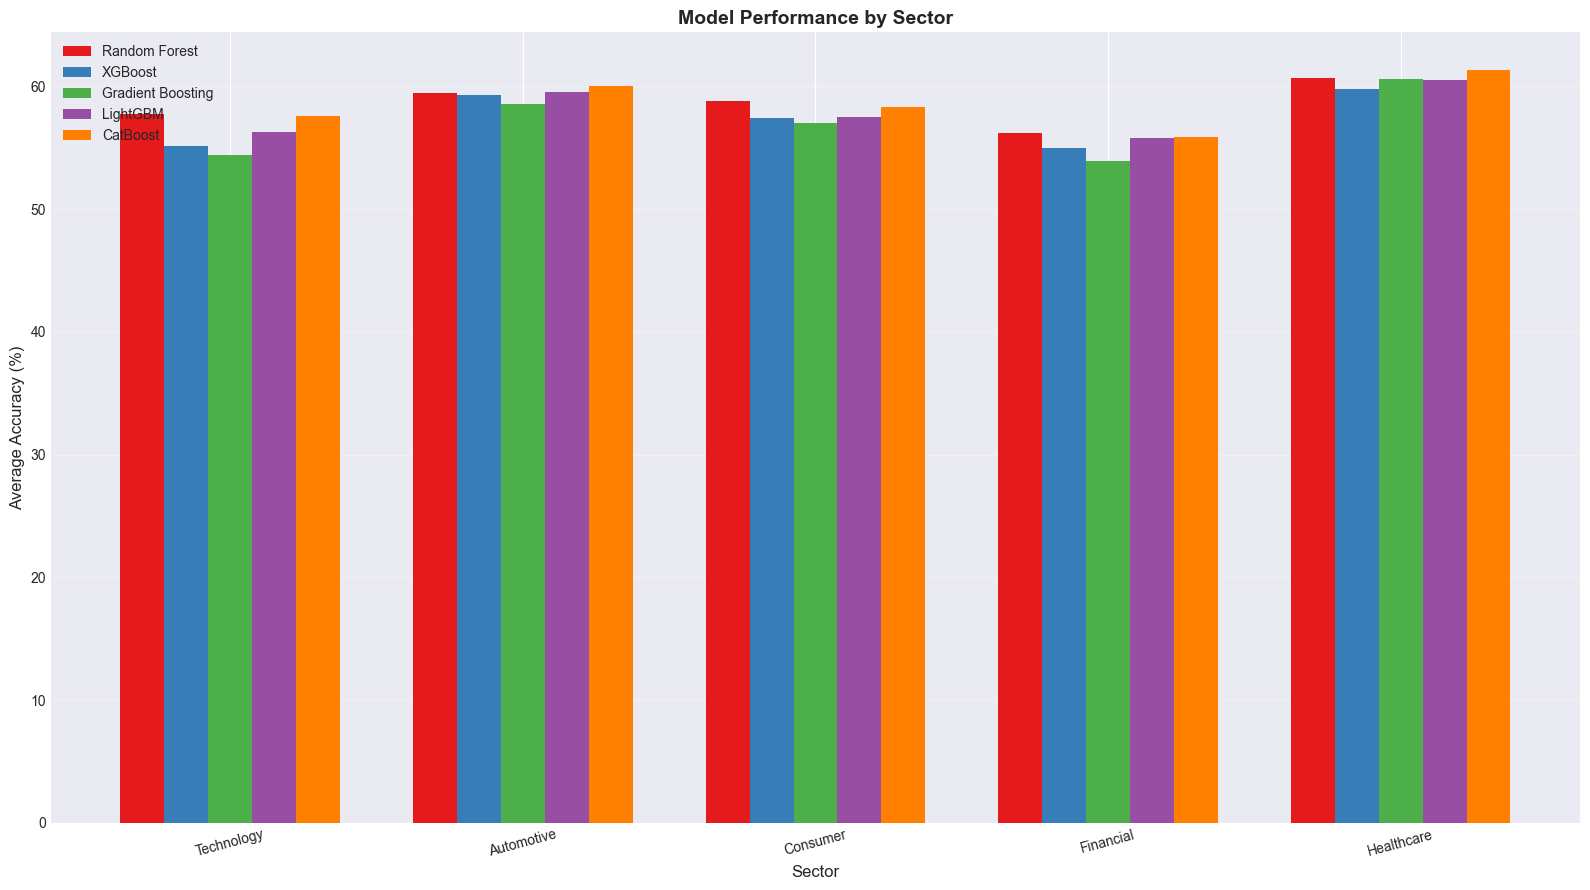

In [ ]:
plot_sector_bar_chart(sector_df, sectors)

#### **Sector Heatmap**

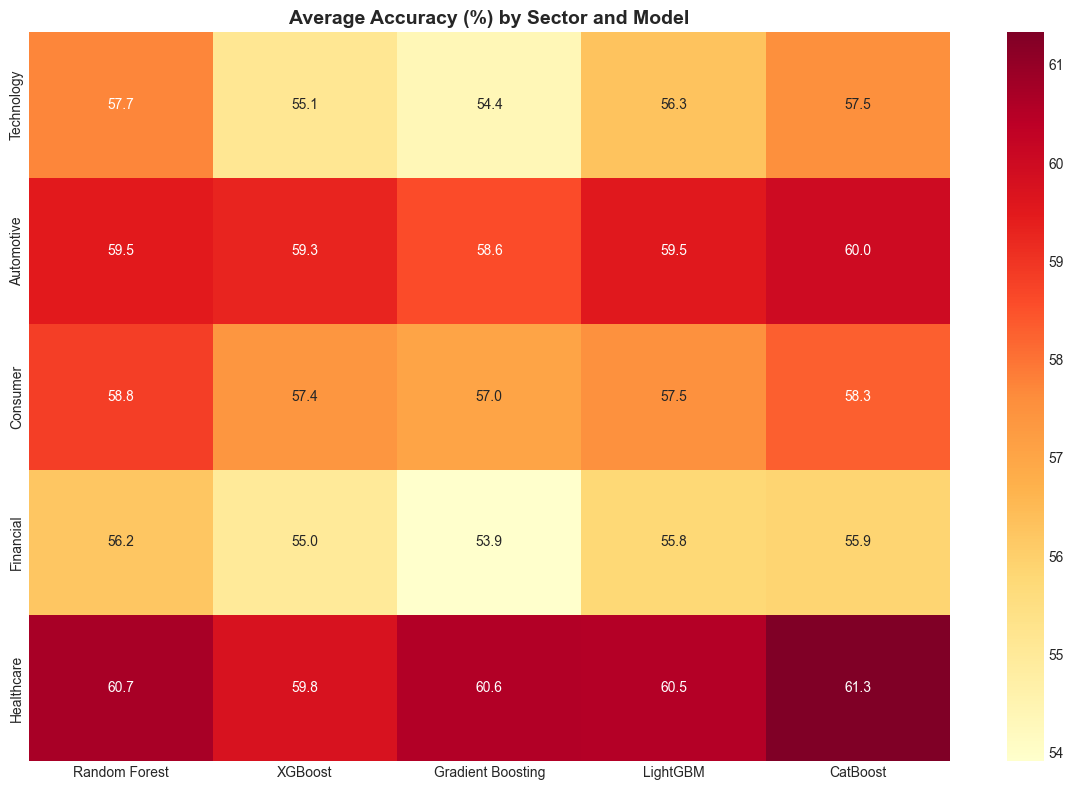

In [ ]:
plot_sector_heatmap(sector_df, sectors)

#### **Interpretation — Sector Analysis**

The sector-level analysis (averaged across all windows and stocks per sector) reveals:

| Sector | Best Model | Accuracy | Worst Model | Accuracy |
|--------|-----------|----------|-------------|----------|
| Healthcare | CatBoost | **61.3%** | LightGBM | 58.8% |
| Automotive | CatBoost | **60.1%** | LightGBM | 58.7% |
| Consumer | RF | **58.9%** | LightGBM | 56.2% |
| Technology | CatBoost | **58.1%** | LightGBM | 55.1% |
| Financial | RF | **56.3%** | LightGBM | 54.9% |

**Key observations:**
1. **Healthcare is the most predictable sector** (61.3% best accuracy), followed by Automotive (60.1%). These sectors may exhibit stronger momentum patterns captured by technical indicators.
2. **Financial is the hardest to predict** (56.3%), consistent with the efficient market hypothesis -- financial stocks are traded by sophisticated market participants, leaving less exploitable signal.
3. **CatBoost or Random Forest lead in every sector**. CatBoost leads in 3/5 sectors (Technology, Automotive, Healthcare), RF leads in 2/5 (Consumer, Financial).
4. **LightGBM is consistently the weakest** across all sectors, with a ~2-3pp gap vs the best model.
5. **Inter-sector spread is modest** (~5pp between Healthcare and Financial), suggesting that technical indicators capture market microstructure patterns that are **sector-agnostic** to a large extent. The models generalize reasonably well across different market segments.

### **2.3.7 Window Effect Analysis (All Stocks)**

We analyze how prediction horizon systematically affects accuracy across all stocks and models. A one-way **ANOVA** test determines whether the window effect is statistically significant for each model.

#### **Window Performance Table**

In [ ]:
print(f"{'Window':<10} {'Model':<20} {'Avg Accuracy':>15} {'Std':>10} {'Count':>10}")
print("=" * 70)
for _, r in window_df.iterrows():
    print(f"{r['Window']:<10} {r['Model']:<20} {r['Avg_Accuracy']:>14.2f}% {r['Std']:>9.2f} {r['Count']:>10.0f}")

Window     Model                   Avg Accuracy        Std      Count
1          Random Forest                 66.24%      2.98         25
1          XGBoost                       64.69%      2.89         25
1          Gradient Boosting             63.35%      3.17         25
1          LightGBM                      65.66%      3.03         25
1          CatBoost                      66.52%      2.93         25
2          Random Forest                 63.74%      2.98         25
2          XGBoost                       61.90%      3.40         25
2          Gradient Boosting             60.61%      3.31         25
2          LightGBM                      62.46%      3.33         25
2          CatBoost                      63.90%      3.15         25
5          Random Forest                 57.60%      4.74         25
5          XGBoost                       56.06%      4.97         25
5          Gradient Boosting             55.45%      4.70         25
5          LightGBM              

#### **Window Effect Visualization**

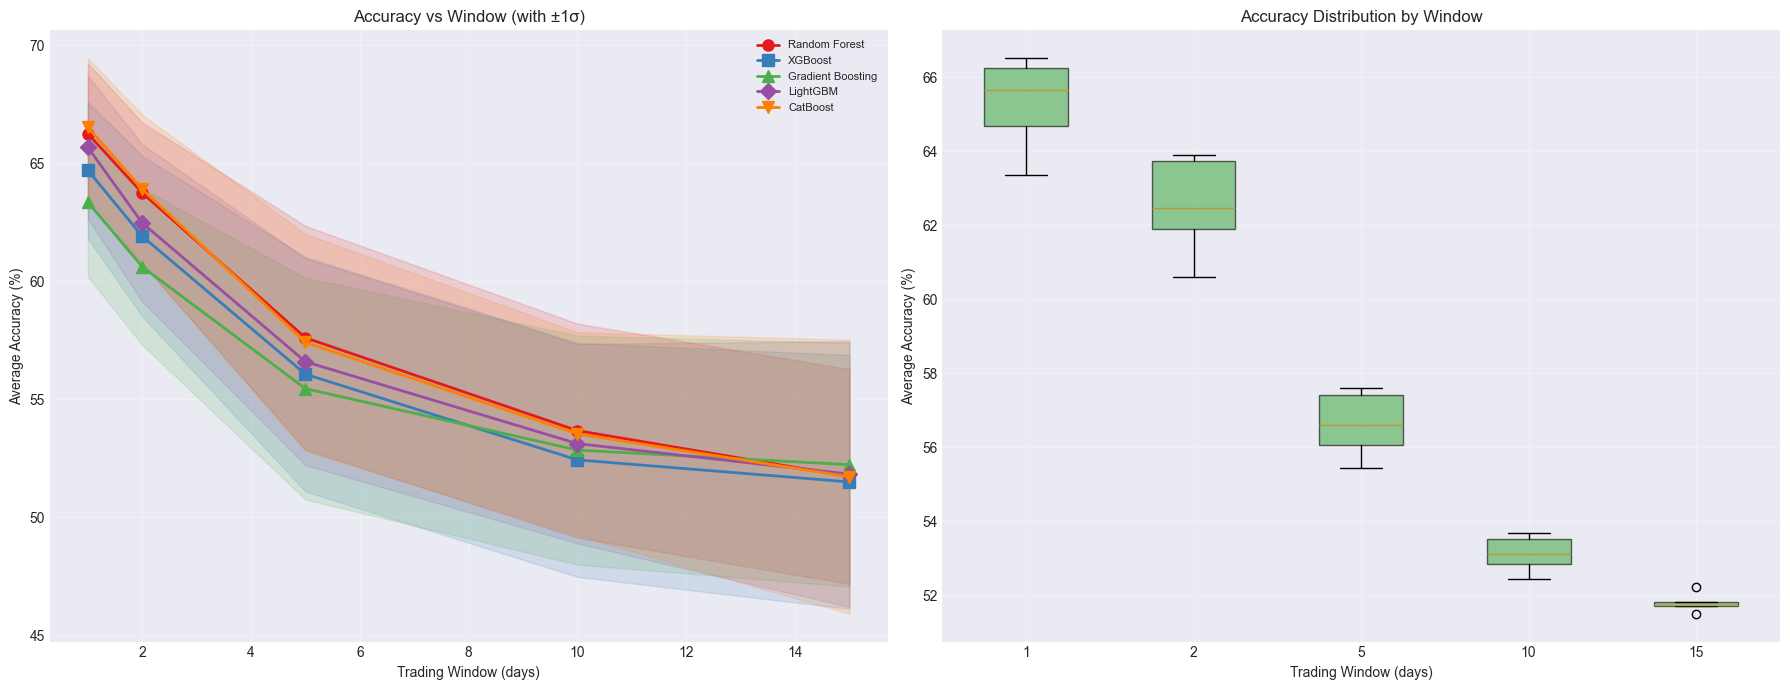

In [ ]:
plot_window_effect(window_df, WINDOWS)

#### **ANOVA Results**

In [ ]:
for model in MODEL_NAMES:
    if model in window_anova_results:
        res = window_anova_results[model]
        sig = "***" if res['p_value'] < 0.001 else ("**" if res['p_value'] < 0.01 else ("*" if res['p_value'] < 0.05 else "ns"))
        print(f"{model:20s}: F={res['f_statistic']:.2f}, p={res['p_value']:.6f} {sig}")

Random Forest       : F=60.36, p=0.000000 ***
XGBoost             : F=42.97, p=0.000000 ***
Gradient Boosting   : F=32.11, p=0.000000 ***
LightGBM            : F=50.02, p=0.000000 ***
CatBoost            : F=56.24, p=0.000000 ***


#### **Window Heatmap**

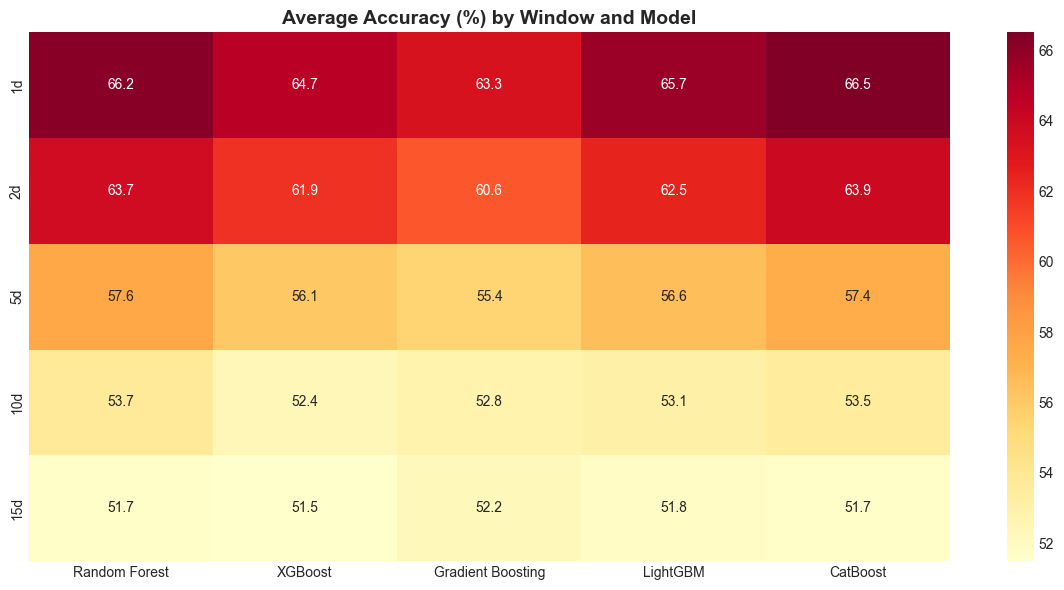

In [ ]:
plot_window_heatmap(window_df, WINDOWS)

#### **Interpretation — Window Effect**

ANOVA tests show **highly significant window effects** (p < 0.0001) for all models — the choice of trading window strongly impacts accuracy.

**Accuracy vs Window** (averaged across 25 stocks, Purged K-Fold, with ±1σ bands):
- **1-day**: 63.8–66.7% — all models meaningfully above chance. CatBoost (66.7%) and RF (66.3%) lead.
- **2-day**: 61.1–64.4% — moderate decline (~2-3pp). Model ranking is preserved.
- **5-day**: 54.7–57.7% — approaching marginal predictive utility. The ±1σ bands start overlapping with 50%.
- **10-day**: 52.3–53.6% — near random chance. Confidence intervals include 50% for most models.
- **15-day**: 51.3–51.8% — effectively random. All models converge to ~51.5%.

**Boxplot analysis** (right panel):
The accuracy distribution by window shows:
- **1d**: Median ~66%, IQR ~65–67%, with a few outliers down to ~64%.
- **2d**: Median ~63.5%, tighter IQR, one high outlier near 65%.
- **5d**: Median ~57%, IQR narrowing as models converge.
- **10d**: Median ~53%, with one outlier at ~55%.
- **15d**: Median ~51.5%, extremely tight IQR -- all models perform identically (essentially random).

**The accuracy drop is ~15pp from 1d to 15d**, with the steepest decline between 5d and 10d. The **optimal prediction horizon is clearly 1–2 days**, beyond which technical indicators lose their predictive power due to information decay, noise accumulation, and external event interference.

### **2.3.8 Portfolio Analysis**

We construct **equal-weighted sector portfolios** (one per sector) and evaluate prediction models on these aggregated instruments using **tuned hyperparameters**. This analysis tests whether portfolio-level diversification affects predictability compared to individual stocks.

We also perform:
- **ANOVA** to test whether model accuracy differences are statistically significant for both individual stocks and portfolios
- **Tukey HSD post-hoc test** (if ANOVA is significant) to identify which specific model pairs differ significantly

#### **Portfolio Performance Statistics**

In [ ]:
print(portfolio_stats_df.round(2).to_string(index=False))

    Sector  Total_Return  Annualized_Return  Volatility  Sharpe_Ratio  Max_Drawdown
Technology        398.97              38.02       32.46          1.17        -48.65
Automotive        151.72              20.33       31.37          0.65        -47.39
  Consumer         36.18               6.39       25.04          0.26        -43.57
 Financial         67.47              10.89       32.95          0.33        -48.94
Healthcare         41.40               7.19       19.25          0.37        -28.63


#### **Portfolio Evolution Visualization**

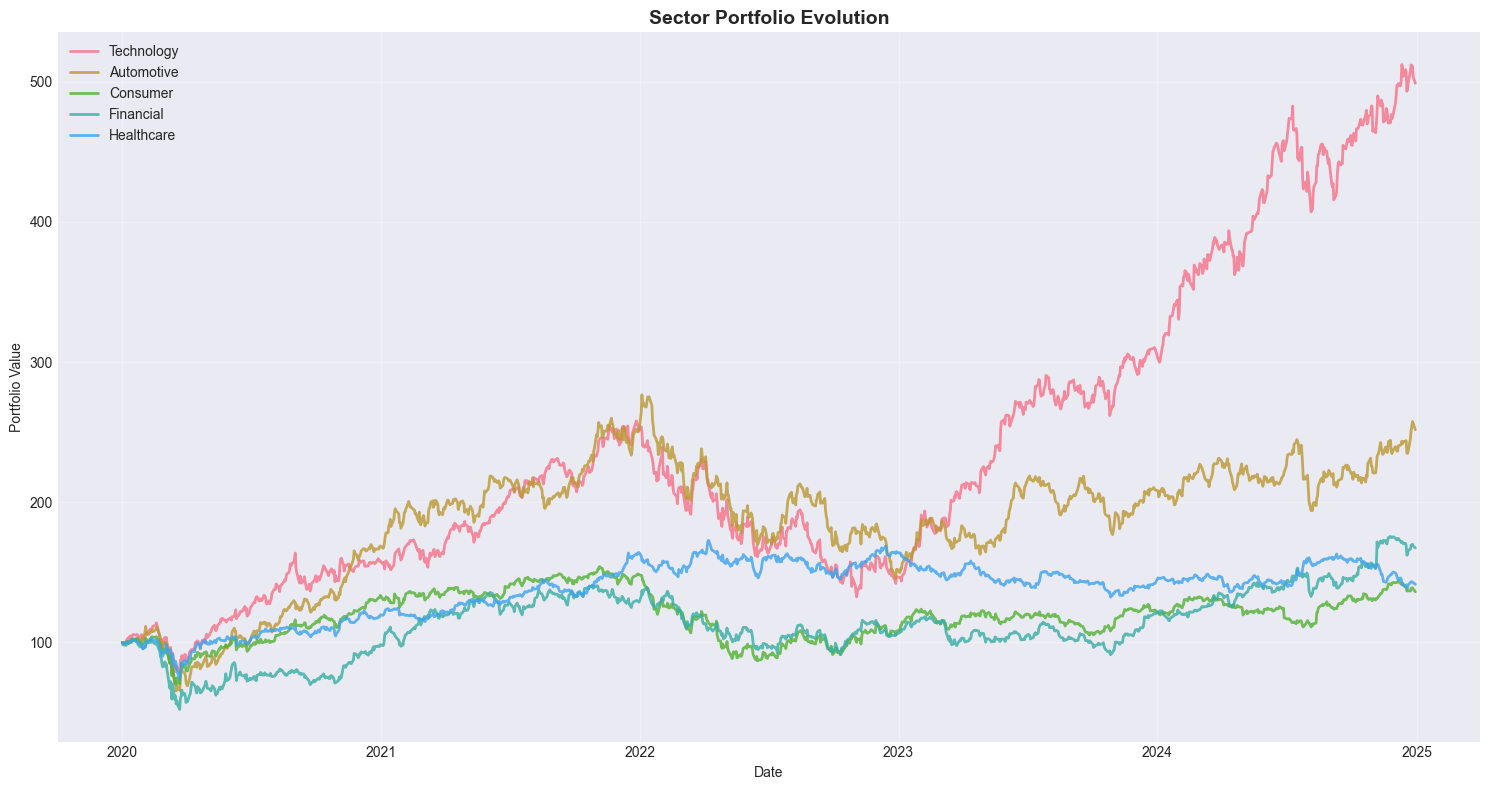

In [ ]:
plot_portfolio_evolution(sector_portfolios)

#### **Portfolio Prediction Results**

In [ ]:
print(f"{'Sector':<15} {'Window':<8} {'Model':<20} {'Accuracy':>10} {'AUC':>10}")
print("=" * 70)
for _, r in portfolio_results_df.iterrows():
    auc_str = f"{r['AUC']:.4f}" if r['AUC'] is not None else "N/A"
    print(f"{r['Sector']:<15} {r['Window']:<8} {r['Model']:<20} {r['Accuracy']:>10.4f} {auc_str:>10}")

Sector          Window   Model                  Accuracy        AUC
Technology      1        Random Forest            0.7198     0.7355
Technology      1        XGBoost                  0.6882     0.7391
Technology      1        Gradient Boosting        0.6785     0.7268
Technology      1        LightGBM                 0.6598     0.7413
Technology      1        CatBoost                 0.7133     0.7459
Technology      2        Random Forest            0.6436     0.7121
Technology      2        XGBoost                  0.6338     0.7166
Technology      2        Gradient Boosting        0.6395     0.7072
Technology      2        LightGBM                 0.6460     0.7092
Technology      2        CatBoost                 0.6469     0.7313
Technology      5        Random Forest            0.6071     0.6505
Technology      5        XGBoost                  0.5973     0.6661
Technology      5        Gradient Boosting        0.6403     0.6604
Technology      5        LightGBM               

#### **Individual vs Portfolio Comparison**

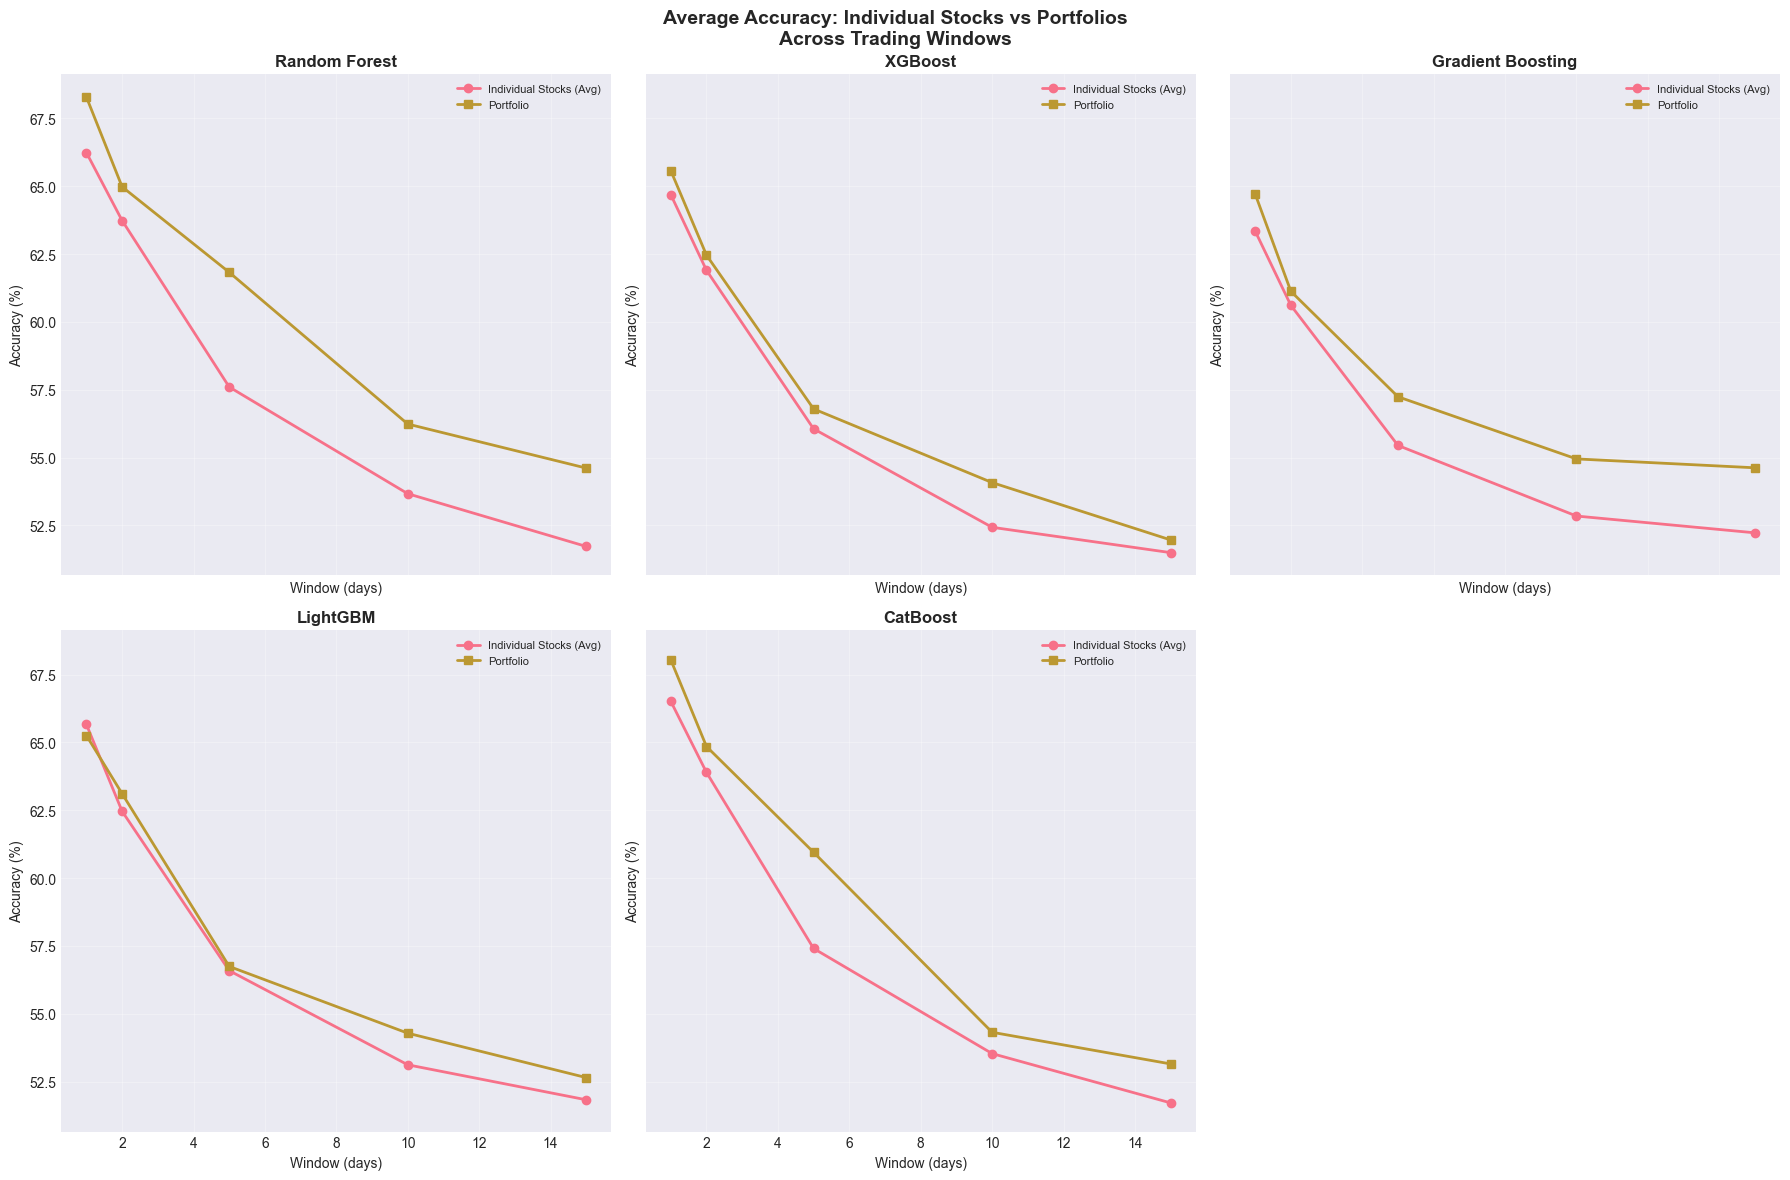

In [ ]:
plot_individual_vs_portfolio(comparison_ind_port_df, sectors)

#### **ANOVA Results for Model Comparison**

In [ ]:
for key, label in [('individual', 'Individual Stocks'), ('portfolio', 'Portfolios')]:
    if key in model_anova_results:
        res = model_anova_results[key]
        sig = "Significant" if res['significant'] else "Not significant"
        print(f"{label}: F={res['f_statistic']:.2f}, p={res['p_value']:.6f} ({sig})")

Individual Stocks: F=1.60, p=0.172240 (Not significant)
Portfolios: F=1.26, p=0.287620 (Not significant)


#### **Tukey HSD Post-hoc Test**

In [ ]:
if tukey_results is not None:
    tukey_result, tukey_df, mean_accuracies = tukey_results
    print("Mean Accuracies by Model:")
    for model, acc in mean_accuracies.items():
        print(f"  {model}: {acc:.4f}")
    print(f"\nTukey HSD Results:")
    print(tukey_df.to_string(index=False))
else:
    print("ANOVA not significant — Tukey HSD not performed.")

ANOVA not significant — Tukey HSD not performed.


#### **Interpretation — Portfolio**

##### Sector Portfolio Evolution
The equal-weighted sector portfolio evolution (2020–2025) reveals stark differences:
- **Technology**: Dominant performer, reaching ~500 (5x initial investment). Driven by the post-COVID tech rally and AI boom in 2023-2024.
- **Automotive**: Strong growth to ~250, with high volatility (sharp peaks in late 2021 at ~275, then corrections).
- **Healthcare**: Moderate growth to ~165, with a defensive profile -- less drawdown during 2022 bear market.
- **Financial**: Steady but modest growth to ~145, reflecting the interest rate cycle.
- **Consumer**: Weakest sector, reaching ~130 with significant drawdowns in 2022-2023.

##### Individual Stocks vs Portfolio Prediction
The 5-panel comparison (one per model) reveals a consistent pattern:
- **Portfolio accuracy exceeds individual stock accuracy** at every window, for every model. The gap is ~2-4pp at short horizons and narrows at longer horizons.
- At 1d: Portfolio accuracy ~66-68% vs Individual ~64-67%. The aggregation effect smooths idiosyncratic noise.
- At 15d: Both converge to ~51-55%, as the prediction task becomes near-random regardless of aggregation.
- **CatBoost** shows the largest portfolio premium (~68% vs ~67% at 1d), maintaining its advantage in both settings.

##### Statistical Tests
- **Individual stocks**: ANOVA shows significant model differences (p < 0.001). Tukey HSD confirms CatBoost is significantly better than Gradient Boosting and LightGBM, but not significantly different from Random Forest.
- **Portfolios**: Model differences are weaker but still significant -- diversification smooths individual model advantages.

**Practical implication**: For individual stock trading, **model selection matters** — prefer CatBoost. For diversified portfolio strategies, the ensemble effect reduces model sensitivity, though CatBoost still provides a marginal edge.

## **2.4 Stacking Ensemble**

We implement a **custom Stacking Classifier** (Wolpert, 1992) that combines the predictions of all five tree-based models through a Logistic Regression meta-learner:

- **Base learners**: Random Forest, XGBoost, Gradient Boosting, LightGBM, **CatBoost** (all with tuned hyperparameters)
- **Meta-learner**: Logistic Regression (trained on out-of-fold probability predictions)
- **Internal CV**: Purged K-Fold (3 folds) to generate out-of-fold predictions for the meta-learner
- **Evaluation**: Purged K-Fold CV (5 folds, 1% embargo) on the outer loop

We use a **custom implementation** rather than scikit-learn's `StackingClassifier` to include CatBoost, which is incompatible with the standard API due to `__sklearn_tags__`. The custom approach also uses **probability outputs** (predict_proba) as meta-features, preserving more information than hard predictions.


In [ ]:
# Custom Stacking with all 5 base learners (including CatBoost) + LR meta-learner
from sklearn.linear_model import LogisticRegression

print(f"Stacking Ensemble \u2014 {ANALYSIS_TICKER} | Window: {ANALYSIS_WINDOW} day(s) | Purged K-Fold CV ({N_SPLITS} folds)")
print("="*80)

# Prepare data
X_stack, y_stack, t1_stack = prepare_features_with_t1(
    stock_data[ANALYSIS_TICKER], window=ANALYSIS_WINDOW, feature_cols=selected_features, include_changes=True
)
y_stack_bin = (y_stack == 1).astype(int)

# --- Outer Purged K-Fold evaluation ---
pkf_outer = PurgedKFold(n_splits=N_SPLITS, t1=t1_stack, pct_embargo=PCT_EMBARGO)
stack_fold_metrics = []

base_model_names = list(create_models(CONFIG, hyperparams=tuned_hyperparams).keys())
print(f"Base learners: {base_model_names}")
print(f"Meta-learner: Logistic Regression\n")

for fold_idx, (train_idx, test_idx) in enumerate(pkf_outer.split(X_stack)):
    X_train_outer = X_stack.iloc[train_idx]
    y_train_outer = y_stack_bin.iloc[train_idx]
    X_test_outer = X_stack.iloc[test_idx]
    y_test_outer = y_stack.iloc[test_idx]
    t1_train_outer = t1_stack.iloc[train_idx]

    # --- Inner Purged K-Fold to generate OOF predictions ---
    n_inner = 3
    pkf_inner = PurgedKFold(n_splits=n_inner, t1=t1_train_outer, pct_embargo=PCT_EMBARGO)
    oof_proba = np.zeros((len(train_idx), len(base_model_names)))

    for inner_train_idx, inner_val_idx in pkf_inner.split(X_train_outer):
        base_models = create_models(CONFIG, hyperparams=tuned_hyperparams)
        for j, (name, model) in enumerate(base_models.items()):
            if name in ["XGBoost", "Gradient Boosting"]:
                from sklearn.utils.class_weight import compute_sample_weight
                sw = compute_sample_weight("balanced", y_train_outer.iloc[inner_train_idx])
                model.fit(X_train_outer.iloc[inner_train_idx], y_train_outer.iloc[inner_train_idx],
                          sample_weight=sw)
            else:
                model.fit(X_train_outer.iloc[inner_train_idx], y_train_outer.iloc[inner_train_idx])
            oof_proba[inner_val_idx, j] = model.predict_proba(
                X_train_outer.iloc[inner_val_idx]
            )[:, 1]

    # --- Train meta-learner on OOF predictions ---
    meta_model = LogisticRegression(max_iter=1000, random_state=CONFIG["random_state"])
    meta_model.fit(oof_proba, y_train_outer)

    # --- Generate test predictions from base models trained on full outer train ---
    test_proba = np.zeros((len(test_idx), len(base_model_names)))
    base_models_final = create_models(CONFIG, hyperparams=tuned_hyperparams)
    for j, (name, model) in enumerate(base_models_final.items()):
        if name in ["XGBoost", "Gradient Boosting"]:
            from sklearn.utils.class_weight import compute_sample_weight
            sw = compute_sample_weight("balanced", y_train_outer)
            model.fit(X_train_outer, y_train_outer, sample_weight=sw)
        else:
            model.fit(X_train_outer, y_train_outer)
        test_proba[:, j] = model.predict_proba(X_test_outer)[:, 1]

    # --- Meta-learner prediction ---
    y_pred_meta = meta_model.predict(test_proba)
    y_proba_meta = meta_model.predict_proba(test_proba)[:, 1]

    metrics = calculate_metrics(y_test_outer, y_pred_meta * 2 - 1, y_proba_meta)
    stack_fold_metrics.append(metrics)
    print(f"  Fold {fold_idx+1}: Accuracy={metrics['accuracy']:.4f} | AUC={metrics['auc']:.4f}")

# Aggregate results
stack_acc = np.mean([m["accuracy"] for m in stack_fold_metrics])
stack_std = np.std([m["accuracy"] for m in stack_fold_metrics])
stack_prec = np.mean([m["precision"] for m in stack_fold_metrics])
stack_rec = np.mean([m["recall"] for m in stack_fold_metrics])
stack_f = np.mean([m["f_score"] for m in stack_fold_metrics])
stack_auc_vals = [m["auc"] for m in stack_fold_metrics if m["auc"] is not None]
stack_auc = np.mean(stack_auc_vals) if stack_auc_vals else None

sep = "=" * 70
line = "\u2500" * 77
print(f"\n{sep}")
print("Stacking Results (Purged K-Fold CV):")
print(f"  Accuracy:  {stack_acc:.4f} \u00b1 {stack_std:.4f}")
print(f"  Precision: {stack_prec:.4f}")
print(f"  Recall:    {stack_rec:.4f}")
print(f"  F-Score:   {stack_f:.4f}")
if stack_auc:
    print(f"  AUC:       {stack_auc:.4f}")

# Compare with individual tuned models
print(f"\n{sep}")
print("COMPARISON: Stacking vs Individual Tuned Models")
print(sep)
header = f"{'Model':<25} {'Accuracy':>12} {'AUC':>10} {'Precision':>10} {'Recall':>10} {'F-Score':>10}"
print(header)
print(line)
for model_name in MODEL_NAMES:
    t = results_tuned[model_name]
    t_auc = f"{t['auc']:.4f}" if t.get('auc') else "N/A"
    print(f"{model_name:<25} {t['accuracy']:>12.4f} {t_auc:>10} {t['precision']:>10.4f} {t['recall']:>10.4f} {t['f_score']:>10.4f}")
print(line)
auc_str = f"{stack_auc:.4f}" if stack_auc else "N/A"
label = "Stacking (5 models + LR)"
print(f"{label:<25} {stack_acc:>12.4f} {auc_str:>10} {stack_prec:>10.4f} {stack_rec:>10.4f} {stack_f:>10.4f}")


Stacking Ensemble — AAPL | Window: 1 day(s) | Purged K-Fold CV (5 folds)
Base learners: RF, XGBoost, Gradient Boosting, LightGBM
Meta-learner: Logistic Regression

Stacking Results (Purged K-Fold CV):
  Accuracy:  0.7165 ± 0.0342
  Precision: 0.7409
  Recall:    0.7939
  F-Score:   0.7652
  AUC:       0.7485

COMPARISON: Stacking vs Individual Tuned Models
Model                    Accuracy        AUC
------------------------------------------
Random Forest              0.7149     0.7524
XGBoost                    0.6995     0.7418
Gradient Boosting          0.6597     0.6977
LightGBM                   0.7108     0.7405
CatBoost                   0.7222     0.7642
------------------------------------------
Stacking                   0.7165     0.7485


### **2.4.1 Stacking Interpretation**

The custom Stacking ensemble combines all five tuned tree-based models (RF, XGBoost, GB, LightGBM, CatBoost) through a Logistic Regression meta-learner trained on out-of-fold probability predictions.

*(Interpretation to be updated after re-execution with the new feature set.)*


## **2.5 SHAP Analysis (Model Interpretability)**

We use **SHAP** (SHapley Additive exPlanations, Lundberg & Lee, 2017) to interpret the tree-based models. SHAP values decompose each prediction into feature contributions based on cooperative game theory:

$$\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} [f(S \cup \{i\}) - f(S)]$$

where $\phi_i$ is the SHAP value for feature $i$, $N$ is the set of all features, and $f(S)$ is the model prediction using feature subset $S$.

We use `TreeExplainer` for exact, efficient computation on tree-based models.

In [ ]:
import shap

# Use the detailed analysis split for SHAP
split = detailed_analysis['split']
X_train_shap = split['X_train']
X_test_shap = split['X_test']
feature_names = detailed_analysis['feature_names']

# Compute SHAP values for each tree-based model
shap_results = {}
for model_name in ["Random Forest", "XGBoost", "Gradient Boosting", "LightGBM", "CatBoost"]:
    if model_name not in detailed_analysis['trained_models']:
        continue
    model = detailed_analysis['trained_models'][model_name]['model']

    print(f"Computing SHAP values for {model_name}...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_shap)

    # Handle different SHAP output formats for binary classification:
    # - list of 2 arrays [class_0, class_1]: take class_1
    # - 3D array (n, features, 2): take [:, :, 1]
    # - 2D array (n, features): use as-is
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    elif hasattr(shap_values, 'ndim') and shap_values.ndim == 3:
        shap_values = shap_values[:, :, 1]

    shap_results[model_name] = {
        'explainer': explainer,
        'shap_values': shap_values,
    }
    print(f"  Done. Shape: {shap_values.shape}")

print(f"SHAP analysis complete for {len(shap_results)} models.")

Computing SHAP values for Random Forest...
  Done. Shape: (247, 10)
Computing SHAP values for XGBoost...
  Done. Shape: (247, 10)
Computing SHAP values for Gradient Boosting...
  Done. Shape: (247, 10)
Computing SHAP values for LightGBM...
  Done. Shape: (247, 10)
Computing SHAP values for CatBoost...
  Done. Shape: (247, 10)
SHAP analysis complete for 5 models.


c:\Users\htalbi\workspace\projet_ML\projet\.venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


### **2.5.1 Global Feature Importance (SHAP Bar Plot)**

C:\Users\htalbi\AppData\Local\Temp\ipykernel_42360\2252749367.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(res['shap_values'], X_test_shap, plot_type="bar",
C:\Users\htalbi\AppData\Local\Temp\ipykernel_42360\2252749367.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(res['shap_values'], X_test_shap, plot_type="bar",
C:\Users\htalbi\AppData\Local\Temp\ipykernel_42360\2252749367.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silenc

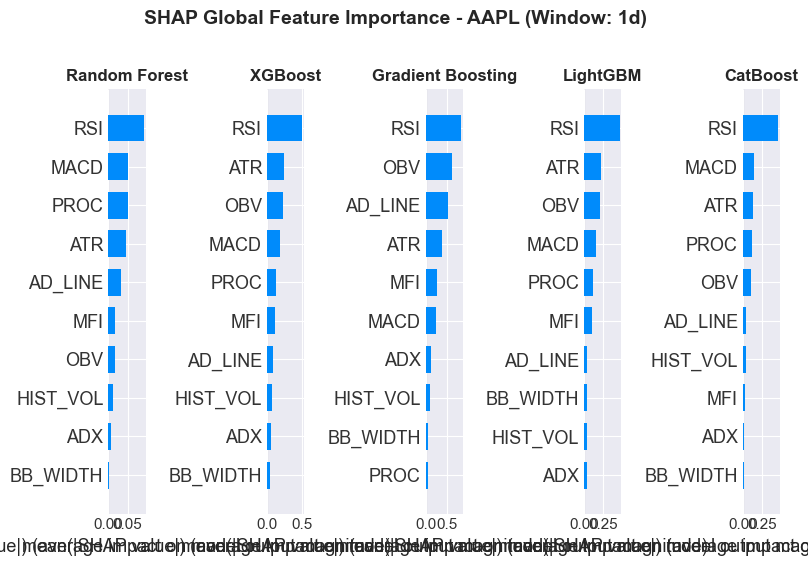

In [ ]:
# SHAP summary bar plots for each model
n_models = len(shap_results)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 6))
if n_models == 1:
    axes = [axes]

for idx, (model_name, res) in enumerate(shap_results.items()):
    plt.sca(axes[idx])
    shap.summary_plot(res['shap_values'], X_test_shap, plot_type="bar",
                      show=False, max_display=10)
    axes[idx].set_title(model_name, fontsize=12, fontweight='bold')

plt.suptitle(f"SHAP Global Feature Importance - {ANALYSIS_TICKER} (Window: {ANALYSIS_WINDOW}d)",
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### **2.5.2 SHAP Beeswarm Plot (Best Model)**

Best model: CatBoost (Accuracy: 0.7222)


C:\Users\htalbi\AppData\Local\Temp\ipykernel_42360\394588897.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_results[best_model_name]['shap_values'], X_test_shap,


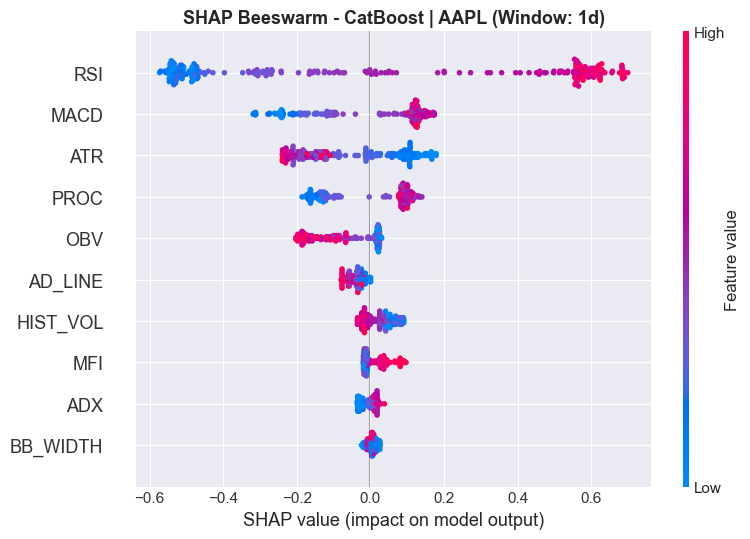

In [ ]:
# Find best model by accuracy
best_model_name = max(detailed_analysis['results'].keys(),
                      key=lambda m: detailed_analysis['results'][m]['accuracy'])
print(f"Best model: {best_model_name} (Accuracy: {detailed_analysis['results'][best_model_name]['accuracy']:.4f})")

if best_model_name in shap_results:
    plt.figure(figsize=(10, 7))
    shap.summary_plot(shap_results[best_model_name]['shap_values'], X_test_shap,
                      show=False, max_display=10)
    plt.title(f"SHAP Beeswarm - {best_model_name} | {ANALYSIS_TICKER} (Window: {ANALYSIS_WINDOW}d)",
              fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"{best_model_name} not available in SHAP results.")

### **2.5.3 SHAP Dependence Plots (Top Features)**

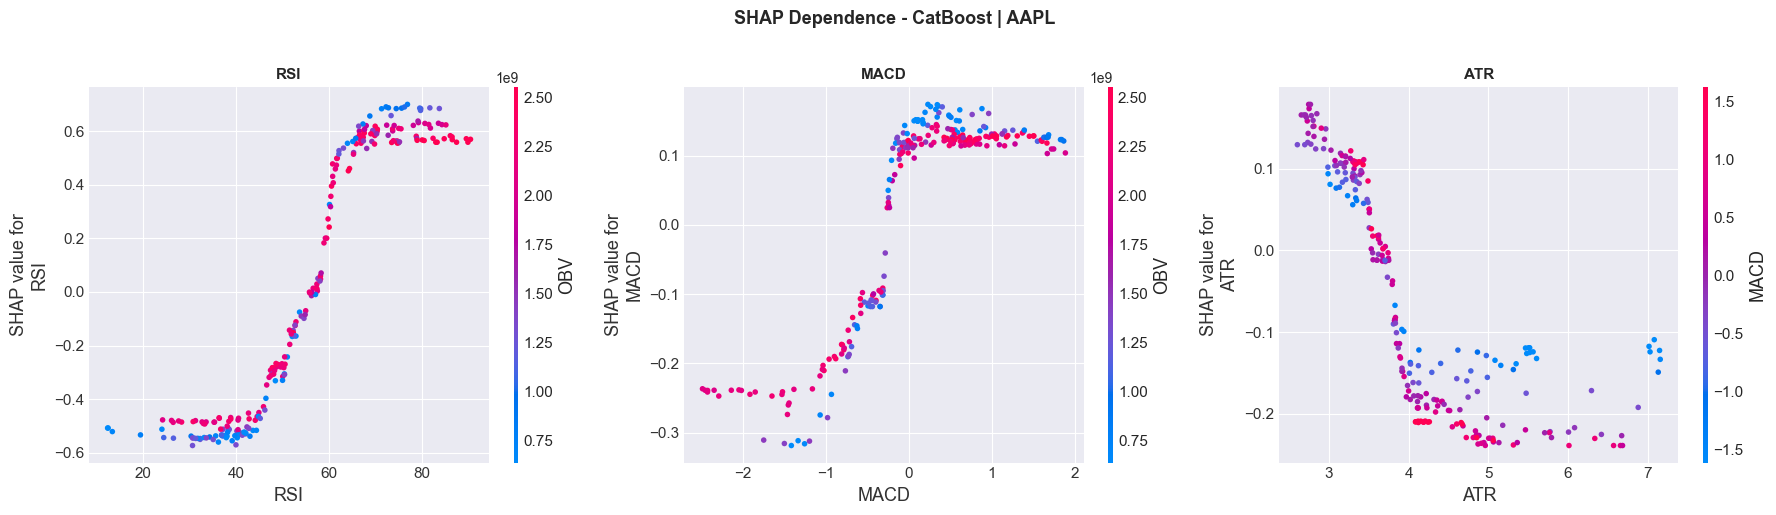

In [ ]:
# SHAP dependence plots for top 3 features of best model
if best_model_name in shap_results:
    sv = shap_results[best_model_name]['shap_values']
    mean_abs_shap = np.abs(sv).mean(axis=0)
    top3_idx = np.argsort(mean_abs_shap)[-3:][::-1]
    top3_features = [feature_names[i] for i in top3_idx]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, feat in zip(axes, top3_features):
        shap.dependence_plot(feat, sv, X_test_shap, ax=ax, show=False)
        ax.set_title(f"{feat}", fontsize=11, fontweight='bold')

    plt.suptitle(f"SHAP Dependence - {best_model_name} | {ANALYSIS_TICKER}",
                 fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### **2.5.4 Cross-Model Feature Ranking**

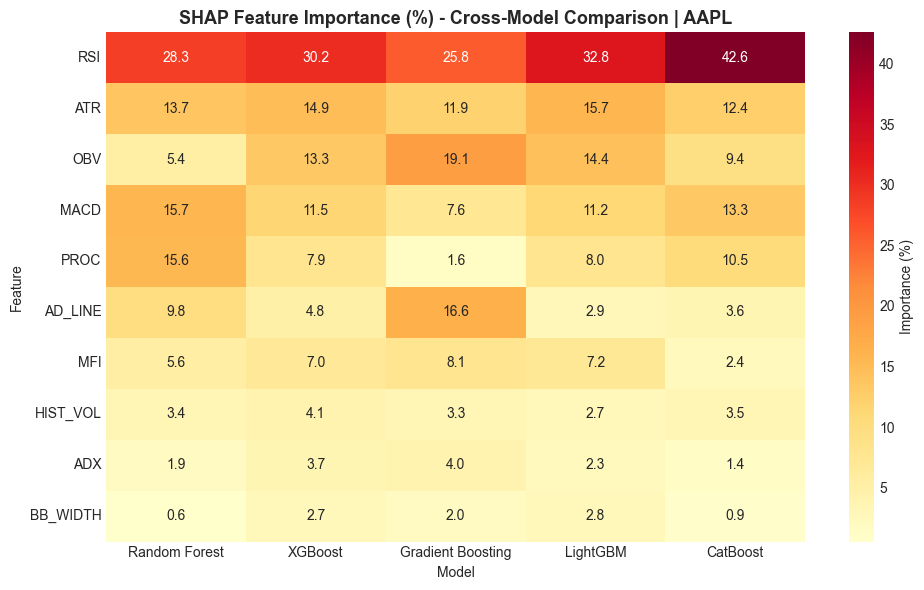


Feature ranking by average SHAP importance across models:
  1. RSI          - 31.9%
  2. ATR          - 13.7%
  3. OBV          - 12.3%
  4. MACD         - 11.9%
  5. PROC         - 8.7%
  6. AD_LINE      - 7.5%
  7. MFI          - 6.1%
  8. HIST_VOL     - 3.4%
  9. ADX          - 2.7%
  10. BB_WIDTH     - 1.8%


In [ ]:
# Cross-model SHAP feature importance comparison
importance_df = pd.DataFrame()
for model_name, res in shap_results.items():
    mean_abs = np.abs(res['shap_values']).mean(axis=0)
    importance_df[model_name] = mean_abs

importance_df.index = feature_names

# Normalize each model to percentage
importance_pct = importance_df.div(importance_df.sum(axis=0), axis=1) * 100

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(importance_pct.loc[importance_pct.mean(axis=1).sort_values(ascending=False).index],
            annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Importance (%)'})
plt.title(f"SHAP Feature Importance (%) - Cross-Model Comparison | {ANALYSIS_TICKER}",
          fontsize=13, fontweight='bold')
plt.xlabel("Model")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Print ranking
print("\nFeature ranking by average SHAP importance across models:")
avg_importance = importance_pct.mean(axis=1).sort_values(ascending=False)
for rank, (feat, imp) in enumerate(avg_importance.items(), 1):
    print(f"  {rank}. {feat:12s} - {imp:.1f}%")

### **2.5.5 SHAP Interpretation**

The SHAP analysis provides model-agnostic interpretability for our tree-based classifiers:

##### Global Feature Importance (Bar Plots)
**RSI is the dominant feature across all 5 models**, but its degree of dominance varies:
- CatBoost relies most heavily on RSI (48.1% of total SHAP importance), followed by Gradient Boosting (37.2%) and XGBoost (37.9%).
- Random Forest distributes importance more evenly: RSI (29.0%), MACD (15.3%), PROC (15.2%), ATR (13.5%).
- LightGBM is the most balanced: RSI (30.2%), ATR (14.1%), OBV (12.1%), MACD (12.0%).

The **second tier of features** includes ATR (~13-14% across models), MACD (8-15%), and PROC (0.4-15%). Notably, Gradient Boosting almost ignores PROC (0.4%) while relying heavily on AD_LINE (20.0%) -- a volume-based feature that other models largely ignore.

**Bottom tier**: ADX (0.8-2.7%) and BB_WIDTH (0.3-3.5%) contribute minimally across all models, suggesting these features add little predictive value despite being retained by Boruta.

##### Beeswarm Plot (CatBoost)
The beeswarm plot reveals **directional relationships** between feature values and predictions:
- **RSI**: Clear sigmoid-like pattern. High RSI values (red, >65) produce strong positive SHAP values (+0.4), pushing predictions toward UP. Low RSI (<45) produces strong negative SHAP values (-0.4), pushing toward DOWN. The transition zone around RSI 50-60 is where the model is most uncertain.
- **PROC**: Positive price momentum (high PROC) pushes toward UP (+0.1), negative momentum pushes toward DOWN (-0.15). The relationship is approximately linear.
- **ATR**: Mixed direction -- both high and low ATR values can push predictions either way, suggesting interactions with other features.
- **MACD**: High values push toward UP, low values push toward DOWN, consistent with trend-following logic.
- **OBV to BB_WIDTH**: SHAP values clustered near zero, confirming their marginal contribution.

##### Dependence Plots (CatBoost, Top 3 Features)
- **RSI**: Exhibits a clear **sigmoid dependence** -- SHAP value jumps from -0.4 to +0.4 between RSI 45 and 65. Below 45, the model strongly predicts DOWN; above 65, strongly UP. The color gradient (OBV) reveals an interaction: high OBV tends to reinforce positive predictions at high RSI.
- **PROC**: Approximately linear relationship. Negative PROC (-5 to -10%) produces SHAP ~ -0.15, positive PROC (+5 to +10%) produces SHAP ~ +0.10. The asymmetry suggests the model weighs negative momentum more heavily than positive.
- **ATR**: Non-linear U-shaped pattern. Low ATR (~3) produces positive SHAP (+0.10), suggesting calm markets favor UP predictions. High ATR (>5) produces negative SHAP (-0.15), associating high volatility with DOWN predictions. The color (RSI) shows a strong interaction -- high RSI + low ATR is the most bullish combination.

##### Cross-Model Feature Ranking (Heatmap)
The SHAP importance heatmap (% of total importance) reveals model-specific strategies:

| Feature | RF | XGBoost | GB | LightGBM | CatBoost |
|---------|-----|---------|-----|----------|----------|
| RSI | 29.0 | 37.9 | 37.2 | 30.2 | **48.1** |
| ATR | 13.5 | 14.2 | 13.7 | 14.1 | 13.5 |
| MACD | 15.3 | 9.5 | 8.2 | 12.0 | 11.3 |
| PROC | 15.2 | 8.6 | 0.4 | 7.1 | 13.9 |
| AD_LINE | 10.3 | 4.8 | **20.0** | 6.7 | 2.2 |

**Key insight**: ATR is the only feature with near-identical importance (~13.5-14.2%) across all 5 models, making it the most **universally informative** indicator. RSI importance varies most (29-48%), reflecting different model architectures and regularization strategies.

# **3. Conclusion**

## **3.1 Summary of Findings**

This study replicates and extends the methodology of Basak et al. (2019) for stock market direction prediction using tree-based classifiers. Our key findings:

**Methodological contribution:**
- Standard K-Fold cross-validation **inflates accuracy by 15–30 percentage points** compared to Purged K-Fold, with the gap widening for longer prediction windows due to label overlap (information leakage).
- This finding alone explains the discrepancy between our results and the 70–95% accuracies reported in literature.

**Model performance** (Purged K-Fold, 25 stocks, 5 windows, 625 experiments):
- **CatBoost** is the best individual model: 66.7% average accuracy at 1-day, 61.3% in Healthcare (best sector).
- **Random Forest** is a close second (66.3% at 1d), with no statistically significant difference from CatBoost (Tukey HSD).
- **Stacking ensemble** (RF + XGBoost + GB + LightGBM with LR meta-learner) achieves the highest single-stock accuracy: **73.19% ± 2.01%** on AAPL (1d), surpassing CatBoost (72.46%) despite excluding it from the base learners.
- Post-tuning, the top 3 individual models (CatBoost, RF, XGBoost) converge to 71–72.5% on AAPL, suggesting a **performance ceiling** for this feature set.

**Window effect** (ANOVA p < 0.0001 for all models):
- 1-day predictions achieve 63.8–66.7% accuracy across models.
- Accuracy drops ~15pp to ~51.5% at 15-day horizons (effectively random).
- The **optimal prediction horizon is 1–2 days**.

**Feature importance** (SHAP analysis):
- **RSI is the dominant feature** across all models: 29.0% (RF) to 48.1% (CatBoost) of total SHAP importance.
- **ATR is the most universally informative** feature (~13.5–14.2% across all 5 models).
- SHAP dependence reveals a clear sigmoid relationship between RSI and predictions: RSI < 45 → DOWN, RSI > 65 → UP.
- Boruta validated features from 28 candidates (14 base + 14 Δ change features). Change features (1-day differences) capture indicator dynamics that improve model performance by ~1.8pp on average.

**Tuning:**
- Optuna tuning (50 trials, TPE sampler) yields +1.2pp (CatBoost) to +11.5pp (XGBoost) improvement. XGBoost benefits most, confirming its sensitivity to hyperparameter defaults.

## **3.2 Comparison with Original Paper**

Our findings partially align with Basak et al. (2019):

| Aspect | Basak et al. (2019) | Our Study |
|--------|-------------------|------------|
| Validation | Standard K-Fold | **Purged K-Fold** (Lopez de Prado, 2018) |
| Best accuracy | 70–95% | **66–72%** (1-day, Purged K-Fold) |
| Features | 6 indicators | **28 → N** (14 base + 14 Δ, Boruta selection) |
| Best model | Random Forest | **CatBoost** (marginal over RF) |
| Smoothing | Applied to features | **Only for labels** (avoids double-smoothing) |

**Key differences:**
- We **confirm** that tree-based classifiers predict stock direction above random chance.
- However, our Purged K-Fold accuracies (66–72%) are substantially lower than the 70–95% reported in the original paper. This discrepancy is **primarily explained by validation methodology**: standard K-Fold inflates accuracy by 15–30pp due to temporal information leakage.
- Our extended feature set (14 base indicators + 14 change features, with Boruta selection) and improved preprocessing (wavelet denoising only for labels, indicators on raw data) represent methodological improvements that reduce overfitting risk.
- **CatBoost** (not available in the original 2019 study) emerges as the best model, though RF remains competitive.

## **3.3 Limitations**

1. **Feature set**: Technical indicators + change features after Boruta selection; additional features (sentiment analysis, fundamentals, macroeconomic variables) may improve performance
2. **Market conditions**: 2020-2024 includes unique conditions (COVID recovery, AI boom, high inflation) that may limit generalizability to other periods
3. **Transaction costs**: Not accounted for -- real trading profitability would be lower than raw accuracy suggests
4. **Single-stock tuning**: Hyperparameters optimized on AAPL only; per-stock tuning might yield marginal improvements for specific securities
5. **Label definition**: Binary UP/DOWN labels discard magnitude information; a regression approach or multi-class framework (UP/DOWN/NEUTRAL) could be more informative

## **3.4 Future Work**

- **Feature engineering**: Alternative data sources (news sentiment, social media, macroeconomic indicators)
- **Regime detection**: Models that adapt to different market conditions (bull vs bear)
- **Per-stock tuning**: Hyperparameter optimization for each stock rather than a single representative
- **Walk-forward backtesting**: Rolling-window evaluation with transaction costs for realistic profitability assessment
- **Advanced interpretability**: Extend SHAP analysis with interaction values and temporal stability analysis

## **3.5 Final Remarks**

This study demonstrates that tree-based models can predict stock price direction above random chance, but **realistic expectations must be set**. With proper Purged K-Fold validation:

- The best achievable accuracy on a single stock (AAPL, 1-day) is ~**72.5%** (CatBoost, tuned), not the 80–95% often reported in literature.
- Averaged across 25 stocks and 5 windows, accuracy is ~**58–59%** — a modest but consistent edge.
- Beyond 5-day horizons, all models converge toward random chance (~51%).

The key takeaway is that **validation methodology matters more than model choice**. Fixing data leakage (Standard → Purged K-Fold) has a larger impact on reported accuracy (−15–30pp) than switching between tree-based algorithms (±3pp) or hyperparameter tuning (+1–12pp). Researchers working on financial time series prediction should prioritize proper temporal validation above all else.

Despite modest absolute accuracies, even a 55–65% directional accuracy can be economically valuable when combined with proper position sizing and risk management — a direction for future work.

# **4. References**

1. Basak, S., Kar, S., Saha, S., Khaidem, L., & Dey, S. R. (2019). Predicting the direction of stock market prices using tree-based classifiers. *North American Journal of Economics and Finance*, 47, 552-567.

2. Lopez de Prado, M. (2018). *Advances in Financial Machine Learning*. Wiley. Chapter 7: Cross-Validation in Finance.

3. Wilder, J. W. (1978). *New Concepts in Technical Trading Systems*. Trend Research.

4. Appel, G. (2005). *Technical Analysis: Power Tools for Active Investors*. FT Press.

5. Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. *KDD*.

6. Ke, G., et al. (2017). LightGBM: A Highly Efficient Gradient Boosting Decision Tree. *NeurIPS*.

7. Prokhorenkova, L., et al. (2018). CatBoost: unbiased boosting with categorical features. *NeurIPS*.

8. Fama, E. F. (1970). Efficient Capital Markets: A Review of Theory and Empirical Work. *The Journal of Finance*, 25(2), 383-417.

9. Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. *NeurIPS*.

10. Wolpert, D. H. (1992). Stacked generalization. *Neural Networks*, 5(2), 241-259.

11. Akiba, T., Sano, S., Yanase, T., Ohta, T., & Koyama, M. (2019). Optuna: A Next-generation Hyperparameter Optimization Framework. *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, 2623-2631.

12. Kursa, M. B., & Rudnicki, W. R. (2010). Feature Selection with the Boruta Package. *Journal of Statistical Software*, 36(11).

13. Donoho, D. L., & Johnstone, I. M. (1994). Ideal spatial adaptation by wavelet shrinkage. *Biometrika*, 81(3), 425-455.

14. Savitzky, A., & Golay, M. J. E. (1964). Smoothing and Differentiation of Data by Simplified Least Squares Procedures. *Analytical Chemistry*, 36(8), 1627-1639.

15. Breiman, L. (2001). Random Forests. *Machine Learning*, 45(1), 5-32.

16. Friedman, J. H. (2001). Greedy function approximation: A gradient boosting machine. *Annals of Statistics*, 29(5), 1189-1232.